# TESS Atlas fit for TOI 524

**Version: 0.1.0**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 524.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/master/notebooks/0.1.0/toi-524.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/master/notebooks/0.1.0/toi-524.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/master/notebooks/0.1.0/toi-524.ipynb).

## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Data & de-trending](#Data-%26amp%3B-de-trending)
3. [Removing stellar variability](#Removing-stellar-variability)
4. [Transit model in PyMC3 & exoplanet](#Transit-model-in-PyMC3-%26amp%3B-exoplanet)
5. [Sampling](#Sampling)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

## Data & de-trending

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [3]:
toi_num = 524

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# Extract the stellar radius from the table
toi_r_star = toi['Stellar Radius (R_Sun)']
toi_r_star_err = toi['Stellar Radius (R_Sun) err']
toi_logg_star = toi['Stellar log(g) (cm/s^2)']
toi_logg_star_err = toi['Stellar log(g) (cm/s^2) err']

# If there is no entry in the table (does this ever happen?)
if not (np.isfinite(toi_r_star) and np.isfinite(toi_r_star_err)):
    raise ValueError("no radius measurement in table")
if not (np.isfinite(toi_logg_star) and np.isfinite(toi_logg_star_err)):
    raise ValueError("no logg measurement in table")

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI 524 was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

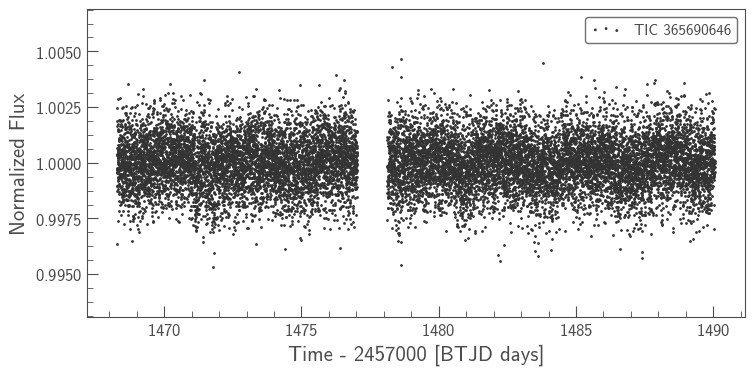

In [4]:
# Download the target pixel files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all()
if tpf_collection is None or not len(tpf_collection):
    raise ValueError("the TESS atlas only works for TPF files")

# tpf_collection[0].to_lightcurve(aperture_mask="pipeline").plot()
# assert 0
    
# Extract the exposure time associated with the TPF
hdr = tpf_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF to extract the light curves
lc_collection = []
for tpf in tpf_collection:
    mask = np.zeros_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask |= get_transit_mask(tpf.time, t0s[i], periods[i], 5*durations[i])    
    pld = tpf.to_corrector("pld")
    try:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=2)
    except ValueError:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=1)
    lc_collection.append(lc.normalize())

# Normalize and stitch the sectors
lc = lc_collection[0]
if len(lc_collection) > 1:
    lc = lc.append([next_lc for next_lc in lc_collection[1:]])
lc = lc.remove_outliers()
    
lc.scatter();

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [5]:
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] *= 1000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2), J=2)
    pm.Potential("loglike", gp.log_likelihood(y))
    
    map_soln = xo.optimize()
    pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y -= pred

optimizing logp for variables: ['logrho', 'logsigma', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -24361.172235689355 -> -24218.751984756786


## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean (out-of-transit) flux of the star,
* `r_star`: the radius of the star (with the prior from the TOI list),
* `logg_star`: the surface gravity of the star (with the prior from the TOI list),
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the obribatl periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [6]:
# factor * 10**logg / r_star = rho
factor = 5.141596357654149e-05

def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        
        logg_star = pm.Normal("logg_star", mu=toi_logg_star, sd=toi_logg_star_err)
        r_star = pm.Bound(pm.Normal, lower=0.0)("r_star", mu=toi_r_star, sd=toi_r_star_err)
        rho_star = pm.Deterministic("rho_star", factor * 10**logg_star / r_star)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=1.0,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )
        r_pl = pm.Deterministic("r_pl", r * r_star)

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b, r_star=r_star, rho_star=rho_star)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r_pl, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logg_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -23819.963883336244 -> -22835.80035193359


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -22835.800351933587 -> -22783.835013647356


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -22783.835013647356 -> -22783.834779814973


optimizing logp for variables: ['mean', 't0', 'logP']


message: Optimization terminated successfully.
logp: -22783.834779814973 -> -22779.79162717989


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -22779.79162717989 -> -22779.170000845825


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Optimization terminated successfully.
logp: -22779.170000845825 -> -22716.105049596117


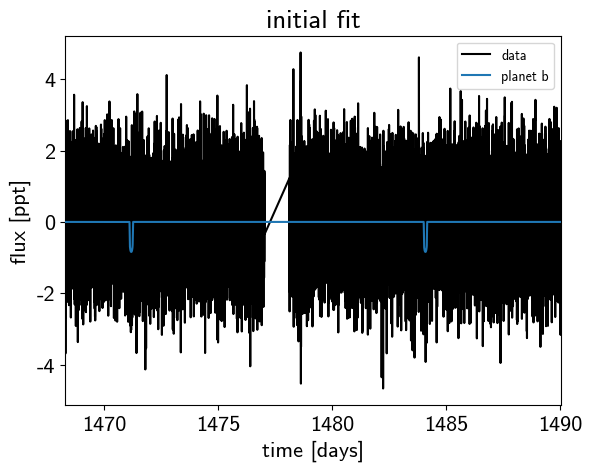

In [7]:
model = build_model(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [8]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2, cores=2)
    trace = sampler.sample(draws=1000, chains=2, cores=2)

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   8%|▊         | 8/104 [00:00<00:01, 63.41draws/s]

Sampling 2 chains:  10%|▉         | 10/104 [00:00<00:09,  9.53draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:01<00:14,  6.30draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:02<00:19,  4.55draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:02<00:16,  5.37draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:02<00:24,  3.59draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:02<00:20,  4.23draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:03<00:26,  3.23draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:03<00:22,  3.81draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:03<00:26,  3.15draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:03<00:21,  3.88draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:04<00:23,  3.44draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:04<00:20,  3.88draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:04<00:20,  3.89draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:05<00:21,  3.63draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:05<00:17,  4.37draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:05<00:22,  3.45draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:06<00:20,  3.66draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:06<00:19,  3.75draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:06<00:17,  4.22draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:07<00:18,  3.91draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:07<00:17,  3.94draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:07<00:16,  4.13draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:07<00:18,  3.72draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:08<00:15,  4.42draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:08<00:18,  3.52draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:08<00:17,  3.65draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:09<00:14,  4.42draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:09<00:16,  3.78draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:09<00:15,  3.86draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:09<00:15,  3.82draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:10<00:17,  3.37draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:10<00:14,  4.13draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:10<00:17,  3.26draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:11<00:14,  3.88draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:11<00:14,  3.70draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:11<00:16,  3.19draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:11<00:13,  3.94draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:12<00:16,  3.22draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:12<00:16,  3.15draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:12<00:13,  3.83draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:13<00:15,  3.15draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:13<00:15,  3.14draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:13<00:12,  3.69draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:14<00:15,  3.02draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:14<00:13,  3.29draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:15<00:12,  3.35draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:15<00:11,  3.55draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:16<00:10,  3.75draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:16<00:08,  4.61draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:16<00:09,  3.84draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:17<00:08,  3.96draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:17<00:07,  4.05draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:18<00:07,  4.08draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:18<00:05,  4.95draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:18<00:07,  3.94draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:18<00:06,  4.03draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:19<00:05,  4.09draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:19<00:04,  4.69draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:19<00:05,  4.06draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:20<00:04,  4.77draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:20<00:04,  4.52draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:21<00:03,  4.38draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:21<00:03,  4.23draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:21<00:03,  4.30draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:22<00:02,  4.15draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:22<00:02,  4.15draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:23<00:01,  4.12draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:23<00:01,  3.26draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:24<00:01,  2.90draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:24<00:01,  2.68draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:25<00:00,  3.07draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:25<00:00,  2.80draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:27<00:00,  1.32draws/s]

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:00<00:05, 18.31draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:00<00:09,  9.52draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:12,  7.13draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:01<00:12,  7.40draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:01<00:16,  5.28draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:01<00:15,  5.64draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:02<00:18,  4.78draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:02<00:17,  5.05draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:02<00:19,  4.26draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:02<00:17,  4.86draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:03<00:15,  5.23draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:03<00:19,  4.31draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:03<00:16,  4.98draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:03<00:18,  4.29draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:03<00:15,  5.01draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:04<00:21,  3.66draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:04<00:19,  3.91draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:04<00:16,  4.66draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:05<00:19,  3.78draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:05<00:15,  4.59draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:05<00:18,  3.88draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:06<00:17,  4.02draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:06<00:16,  4.15draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:06<00:12,  5.16draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:07<00:13,  4.86draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:07<00:13,  4.77draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:08<00:12,  4.62draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:08<00:11,  5.30draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:08<00:17,  3.27draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:09<00:14,  4.04draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:09<00:12,  4.38draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:09<00:11,  4.61draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:09<00:14,  3.68draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:10<00:14,  3.70draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:10<00:12,  3.94draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:11<00:11,  4.11draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:11<00:10,  4.24draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:12<00:10,  4.31draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:12<00:09,  4.47draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:12<00:09,  4.30draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:12<00:09,  4.54draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:13<00:08,  4.48draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:13<00:08,  4.50draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:13<00:07,  5.04draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:14<00:08,  4.26draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:14<00:06,  4.94draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:14<00:08,  3.98draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:14<00:06,  5.14draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:15<00:07,  3.81draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:15<00:07,  3.93draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:15<00:05,  4.68draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:16<00:06,  4.06draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:16<00:06,  4.04draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:16<00:05,  4.21draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:16<00:06,  3.67draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:17<00:05,  3.81draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:17<00:04,  4.66draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:17<00:05,  3.74draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:18<00:04,  3.93draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:18<00:03,  4.08draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:18<00:02,  4.95draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:19<00:02,  4.15draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:19<00:02,  4.94draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:19<00:02,  4.20draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:19<00:01,  4.76draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:20<00:01,  4.03draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:20<00:01,  4.71draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:20<00:01,  4.11draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:20<00:01,  4.76draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:21<00:01,  4.00draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:21<00:00,  4.52draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:21<00:00,  3.71draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:23<00:00,  1.46draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:23<00:00,  1.58draws/s]

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|▏         | 3/204 [00:00<00:11, 17.60draws/s]

Sampling 2 chains:   2%|▏         | 5/204 [00:00<00:11, 17.63draws/s]

Sampling 2 chains:   4%|▍         | 8/204 [00:00<00:09, 20.10draws/s]

Sampling 2 chains:   5%|▍         | 10/204 [00:00<00:16, 12.04draws/s]

Sampling 2 chains:   6%|▋         | 13/204 [00:00<00:15, 12.69draws/s]

Sampling 2 chains:   7%|▋         | 15/204 [00:01<00:13, 13.69draws/s]

Sampling 2 chains:   8%|▊         | 17/204 [00:01<00:12, 14.67draws/s]

Sampling 2 chains:  10%|▉         | 20/204 [00:01<00:15, 12.16draws/s]

Sampling 2 chains:  11%|█▏        | 23/204 [00:01<00:13, 13.38draws/s]

Sampling 2 chains:  13%|█▎        | 26/204 [00:01<00:11, 16.03draws/s]

Sampling 2 chains:  14%|█▎        | 28/204 [00:01<00:12, 13.92draws/s]

Sampling 2 chains:  15%|█▍        | 30/204 [00:02<00:12, 13.65draws/s]

Sampling 2 chains:  16%|█▌        | 32/204 [00:02<00:18,  9.23draws/s]

Sampling 2 chains:  18%|█▊        | 36/204 [00:02<00:14, 11.92draws/s]

Sampling 2 chains:  20%|█▉        | 40/204 [00:02<00:11, 13.94draws/s]

Sampling 2 chains:  21%|██        | 43/204 [00:02<00:10, 15.79draws/s]

Sampling 2 chains:  23%|██▎       | 46/204 [00:03<00:08, 18.10draws/s]

Sampling 2 chains:  25%|██▍       | 50/204 [00:03<00:07, 21.33draws/s]

Sampling 2 chains:  26%|██▋       | 54/204 [00:03<00:07, 20.35draws/s]

Sampling 2 chains:  28%|██▊       | 57/204 [00:03<00:07, 19.98draws/s]

Sampling 2 chains:  29%|██▉       | 60/204 [00:03<00:07, 20.45draws/s]

Sampling 2 chains:  31%|███       | 63/204 [00:03<00:07, 19.69draws/s]

Sampling 2 chains:  32%|███▏      | 66/204 [00:04<00:08, 16.51draws/s]

Sampling 2 chains:  34%|███▍      | 69/204 [00:04<00:08, 16.37draws/s]

Sampling 2 chains:  35%|███▍      | 71/204 [00:04<00:12, 10.45draws/s]

Sampling 2 chains:  36%|███▌      | 73/204 [00:04<00:12, 10.27draws/s]

Sampling 2 chains:  37%|███▋      | 76/204 [00:04<00:10, 12.30draws/s]

Sampling 2 chains:  39%|███▉      | 80/204 [00:05<00:08, 14.63draws/s]

Sampling 2 chains:  40%|████      | 82/204 [00:05<00:08, 15.24draws/s]

Sampling 2 chains:  41%|████      | 84/204 [00:05<00:08, 13.62draws/s]

Sampling 2 chains:  43%|████▎     | 87/204 [00:05<00:07, 15.27draws/s]

Sampling 2 chains:  44%|████▎     | 89/204 [00:05<00:09, 12.62draws/s]

Sampling 2 chains:  45%|████▌     | 92/204 [00:05<00:07, 15.26draws/s]

Sampling 2 chains:  46%|████▌     | 94/204 [00:05<00:07, 15.48draws/s]

Sampling 2 chains:  47%|████▋     | 96/204 [00:06<00:07, 14.51draws/s]

Sampling 2 chains:  48%|████▊     | 98/204 [00:06<00:11,  9.09draws/s]

Sampling 2 chains:  49%|████▉     | 100/204 [00:06<00:11,  9.38draws/s]

Sampling 2 chains:  50%|█████     | 102/204 [00:06<00:09, 10.30draws/s]

Sampling 2 chains:  51%|█████     | 104/204 [00:06<00:08, 11.70draws/s]

Sampling 2 chains:  52%|█████▏    | 106/204 [00:07<00:07, 12.77draws/s]

Sampling 2 chains:  53%|█████▎    | 109/204 [00:07<00:06, 14.96draws/s]

Sampling 2 chains:  55%|█████▍    | 112/204 [00:07<00:06, 13.96draws/s]

Sampling 2 chains:  56%|█████▌    | 114/204 [00:07<00:07, 12.11draws/s]

Sampling 2 chains:  57%|█████▋    | 116/204 [00:07<00:07, 11.63draws/s]

Sampling 2 chains:  58%|█████▊    | 118/204 [00:08<00:06, 12.60draws/s]

Sampling 2 chains:  59%|█████▉    | 120/204 [00:08<00:07, 11.11draws/s]

Sampling 2 chains:  60%|██████    | 123/204 [00:08<00:05, 13.58draws/s]

Sampling 2 chains:  61%|██████▏   | 125/204 [00:08<00:10,  7.75draws/s]

Sampling 2 chains:  64%|██████▎   | 130/204 [00:08<00:07, 10.29draws/s]

Sampling 2 chains:  65%|██████▌   | 133/204 [00:09<00:05, 12.51draws/s]

Sampling 2 chains:  67%|██████▋   | 136/204 [00:09<00:04, 13.92draws/s]

Sampling 2 chains:  68%|██████▊   | 139/204 [00:09<00:07,  8.84draws/s]

Sampling 2 chains:  69%|██████▉   | 141/204 [00:10<00:06, 10.36draws/s]

Sampling 2 chains:  70%|███████   | 143/204 [00:10<00:05, 10.31draws/s]

Sampling 2 chains:  71%|███████   | 145/204 [00:10<00:05, 10.47draws/s]

Sampling 2 chains:  72%|███████▏  | 147/204 [00:10<00:04, 12.01draws/s]

Sampling 2 chains:  74%|███████▎  | 150/204 [00:10<00:03, 14.03draws/s]

Sampling 2 chains:  75%|███████▍  | 152/204 [00:10<00:03, 15.11draws/s]

Sampling 2 chains:  75%|███████▌  | 154/204 [00:11<00:04, 11.29draws/s]

Sampling 2 chains:  76%|███████▋  | 156/204 [00:11<00:04, 11.39draws/s]

Sampling 2 chains:  78%|███████▊  | 159/204 [00:11<00:03, 13.52draws/s]

Sampling 2 chains:  79%|███████▉  | 162/204 [00:11<00:02, 16.11draws/s]

Sampling 2 chains:  81%|████████  | 165/204 [00:11<00:02, 16.14draws/s]

Sampling 2 chains:  82%|████████▏ | 167/204 [00:11<00:02, 14.67draws/s]

Sampling 2 chains:  83%|████████▎ | 170/204 [00:11<00:01, 17.13draws/s]

Sampling 2 chains:  85%|████████▍ | 173/204 [00:12<00:02, 12.94draws/s]

Sampling 2 chains:  86%|████████▌ | 175/204 [00:12<00:02, 14.31draws/s]

Sampling 2 chains:  87%|████████▋ | 177/204 [00:12<00:02,  9.49draws/s]

Sampling 2 chains:  88%|████████▊ | 179/204 [00:13<00:03,  7.08draws/s]

Sampling 2 chains:  89%|████████▊ | 181/204 [00:13<00:03,  5.94draws/s]

Sampling 2 chains:  90%|████████▉ | 183/204 [00:13<00:02,  7.35draws/s]

Sampling 2 chains:  91%|█████████ | 185/204 [00:13<00:02,  8.58draws/s]

Sampling 2 chains:  92%|█████████▏| 187/204 [00:14<00:01,  9.72draws/s]

Sampling 2 chains:  93%|█████████▎| 189/204 [00:14<00:01, 11.02draws/s]

Sampling 2 chains:  94%|█████████▎| 191/204 [00:14<00:01, 10.98draws/s]

Sampling 2 chains:  95%|█████████▍| 193/204 [00:14<00:01, 10.44draws/s]

Sampling 2 chains:  96%|█████████▌| 195/204 [00:14<00:00,  9.77draws/s]

Sampling 2 chains:  97%|█████████▋| 198/204 [00:15<00:00, 10.11draws/s]

Sampling 2 chains:  98%|█████████▊| 200/204 [00:15<00:00,  7.83draws/s]

Sampling 2 chains:  99%|█████████▊| 201/204 [00:15<00:00,  7.48draws/s]

Sampling 2 chains: 100%|█████████▉| 203/204 [00:15<00:00,  7.22draws/s]

Sampling 2 chains: 100%|██████████| 204/204 [00:16<00:00,  7.13draws/s]

Sampling 2 chains:   0%|          | 0/404 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 3/404 [00:00<00:21, 18.53draws/s]

Sampling 2 chains:   1%|          | 5/404 [00:00<00:23, 16.80draws/s]

Sampling 2 chains:   2%|▏         | 7/404 [00:00<00:33, 11.74draws/s]

Sampling 2 chains:   2%|▏         | 9/404 [00:01<00:48,  8.21draws/s]

Sampling 2 chains:   3%|▎         | 11/404 [00:01<00:53,  7.40draws/s]

Sampling 2 chains:   3%|▎         | 13/404 [00:01<00:47,  8.29draws/s]

Sampling 2 chains:   4%|▎         | 15/404 [00:01<00:42,  9.06draws/s]

Sampling 2 chains:   4%|▍         | 17/404 [00:01<00:38,  9.93draws/s]

Sampling 2 chains:   5%|▍         | 19/404 [00:01<00:35, 10.85draws/s]

Sampling 2 chains:   5%|▌         | 22/404 [00:02<00:30, 12.62draws/s]

Sampling 2 chains:   6%|▌         | 25/404 [00:02<00:25, 14.63draws/s]

Sampling 2 chains:   7%|▋         | 28/404 [00:02<00:22, 17.07draws/s]

Sampling 2 chains:   8%|▊         | 31/404 [00:02<00:19, 18.84draws/s]

Sampling 2 chains:   8%|▊         | 34/404 [00:02<00:17, 21.10draws/s]

Sampling 2 chains:   9%|▉         | 38/404 [00:02<00:15, 24.21draws/s]

Sampling 2 chains:  10%|█         | 41/404 [00:02<00:18, 20.00draws/s]

Sampling 2 chains:  11%|█         | 44/404 [00:03<00:22, 16.28draws/s]

Sampling 2 chains:  12%|█▏        | 47/404 [00:03<00:23, 15.24draws/s]

Sampling 2 chains:  12%|█▏        | 49/404 [00:03<00:21, 16.31draws/s]

Sampling 2 chains:  13%|█▎        | 51/404 [00:03<00:26, 13.54draws/s]

Sampling 2 chains:  13%|█▎        | 54/404 [00:03<00:21, 16.01draws/s]

Sampling 2 chains:  14%|█▍        | 56/404 [00:04<00:27, 12.56draws/s]

Sampling 2 chains:  14%|█▍        | 58/404 [00:04<00:27, 12.46draws/s]

Sampling 2 chains:  15%|█▌        | 61/404 [00:04<00:22, 14.93draws/s]

Sampling 2 chains:  16%|█▌        | 63/404 [00:04<00:23, 14.52draws/s]

Sampling 2 chains:  16%|█▋        | 66/404 [00:04<00:20, 16.58draws/s]

Sampling 2 chains:  17%|█▋        | 68/404 [00:04<00:19, 17.03draws/s]

Sampling 2 chains:  18%|█▊        | 72/404 [00:04<00:18, 18.15draws/s]

Sampling 2 chains:  18%|█▊        | 74/404 [00:05<00:20, 16.03draws/s]

Sampling 2 chains:  19%|█▉        | 76/404 [00:05<00:24, 13.64draws/s]

Sampling 2 chains:  20%|█▉        | 79/404 [00:05<00:21, 15.30draws/s]

Sampling 2 chains:  20%|██        | 81/404 [00:05<00:31, 10.16draws/s]

Sampling 2 chains:  21%|██        | 83/404 [00:05<00:28, 11.24draws/s]

Sampling 2 chains:  21%|██        | 85/404 [00:06<00:25, 12.42draws/s]

Sampling 2 chains:  22%|██▏       | 88/404 [00:06<00:23, 13.30draws/s]

Sampling 2 chains:  22%|██▏       | 90/404 [00:06<00:23, 13.48draws/s]

Sampling 2 chains:  23%|██▎       | 92/404 [00:06<00:21, 14.74draws/s]

Sampling 2 chains:  24%|██▎       | 95/404 [00:06<00:21, 14.11draws/s]

Sampling 2 chains:  24%|██▍       | 97/404 [00:06<00:25, 11.94draws/s]

Sampling 2 chains:  25%|██▍       | 99/404 [00:07<00:29, 10.23draws/s]

Sampling 2 chains:  25%|██▌       | 102/404 [00:07<00:25, 11.73draws/s]

Sampling 2 chains:  26%|██▌       | 105/404 [00:07<00:23, 13.00draws/s]

Sampling 2 chains:  27%|██▋       | 108/404 [00:07<00:19, 15.27draws/s]

Sampling 2 chains:  27%|██▋       | 111/404 [00:07<00:18, 15.91draws/s]

Sampling 2 chains:  28%|██▊       | 113/404 [00:08<00:26, 11.00draws/s]

Sampling 2 chains:  28%|██▊       | 115/404 [00:08<00:24, 11.60draws/s]

Sampling 2 chains:  29%|██▉       | 117/404 [00:08<00:30,  9.44draws/s]

Sampling 2 chains:  29%|██▉       | 119/404 [00:08<00:29,  9.54draws/s]

Sampling 2 chains:  30%|██▉       | 121/404 [00:08<00:25, 10.94draws/s]

Sampling 2 chains:  31%|███       | 124/404 [00:09<00:21, 13.13draws/s]

Sampling 2 chains:  31%|███       | 126/404 [00:09<00:21, 13.16draws/s]

Sampling 2 chains:  32%|███▏      | 128/404 [00:09<00:18, 14.63draws/s]

Sampling 2 chains:  32%|███▏      | 130/404 [00:09<00:17, 15.61draws/s]

Sampling 2 chains:  33%|███▎      | 132/404 [00:09<00:17, 15.94draws/s]

Sampling 2 chains:  33%|███▎      | 135/404 [00:09<00:14, 18.41draws/s]

Sampling 2 chains:  34%|███▍      | 139/404 [00:09<00:12, 20.49draws/s]

Sampling 2 chains:  35%|███▌      | 142/404 [00:09<00:12, 21.54draws/s]

Sampling 2 chains:  36%|███▌      | 145/404 [00:10<00:13, 18.74draws/s]

Sampling 2 chains:  37%|███▋      | 148/404 [00:10<00:12, 20.27draws/s]

Sampling 2 chains:  37%|███▋      | 151/404 [00:10<00:12, 20.54draws/s]

Sampling 2 chains:  38%|███▊      | 154/404 [00:10<00:11, 21.07draws/s]

Sampling 2 chains:  39%|███▉      | 157/404 [00:10<00:12, 20.26draws/s]

Sampling 2 chains:  40%|███▉      | 161/404 [00:10<00:11, 20.28draws/s]

Sampling 2 chains:  41%|████      | 164/404 [00:11<00:14, 16.09draws/s]

Sampling 2 chains:  41%|████▏     | 167/404 [00:11<00:13, 17.77draws/s]

Sampling 2 chains:  42%|████▏     | 170/404 [00:11<00:12, 18.92draws/s]

Sampling 2 chains:  43%|████▎     | 173/404 [00:11<00:13, 16.56draws/s]

Sampling 2 chains:  43%|████▎     | 175/404 [00:11<00:15, 14.66draws/s]

Sampling 2 chains:  44%|████▍     | 177/404 [00:11<00:15, 14.80draws/s]

Sampling 2 chains:  44%|████▍     | 179/404 [00:12<00:16, 13.66draws/s]

Sampling 2 chains:  45%|████▍     | 181/404 [00:12<00:16, 13.26draws/s]

Sampling 2 chains:  45%|████▌     | 183/404 [00:12<00:15, 14.46draws/s]

Sampling 2 chains:  46%|████▌     | 185/404 [00:12<00:14, 15.35draws/s]

Sampling 2 chains:  46%|████▋     | 187/404 [00:12<00:14, 14.84draws/s]

Sampling 2 chains:  47%|████▋     | 190/404 [00:12<00:13, 16.25draws/s]

Sampling 2 chains:  48%|████▊     | 192/404 [00:12<00:12, 16.95draws/s]

Sampling 2 chains:  48%|████▊     | 194/404 [00:12<00:13, 16.03draws/s]

Sampling 2 chains:  49%|████▊     | 196/404 [00:13<00:12, 16.68draws/s]

Sampling 2 chains:  49%|████▉     | 198/404 [00:13<00:11, 17.53draws/s]

Sampling 2 chains:  50%|████▉     | 201/404 [00:13<00:10, 18.76draws/s]

Sampling 2 chains:  50%|█████     | 204/404 [00:13<00:10, 19.66draws/s]

Sampling 2 chains:  51%|█████     | 207/404 [00:13<00:09, 20.17draws/s]

Sampling 2 chains:  52%|█████▏    | 210/404 [00:13<00:09, 20.43draws/s]

Sampling 2 chains:  53%|█████▎    | 214/404 [00:13<00:08, 22.17draws/s]

Sampling 2 chains:  54%|█████▎    | 217/404 [00:14<00:08, 23.14draws/s]

Sampling 2 chains:  55%|█████▍    | 221/404 [00:14<00:07, 25.01draws/s]

Sampling 2 chains:  56%|█████▌    | 226/404 [00:14<00:06, 28.24draws/s]

Sampling 2 chains:  57%|█████▋    | 230/404 [00:14<00:06, 26.40draws/s]

Sampling 2 chains:  58%|█████▊    | 233/404 [00:14<00:06, 25.52draws/s]

Sampling 2 chains:  58%|█████▊    | 236/404 [00:14<00:07, 23.53draws/s]

Sampling 2 chains:  59%|█████▉    | 239/404 [00:14<00:06, 24.49draws/s]

Sampling 2 chains:  60%|█████▉    | 242/404 [00:14<00:06, 23.35draws/s]

Sampling 2 chains:  61%|██████    | 245/404 [00:15<00:06, 24.69draws/s]

Sampling 2 chains:  61%|██████▏   | 248/404 [00:15<00:06, 23.46draws/s]

Sampling 2 chains:  62%|██████▏   | 252/404 [00:15<00:06, 24.71draws/s]

Sampling 2 chains:  63%|██████▎   | 256/404 [00:15<00:05, 25.78draws/s]

Sampling 2 chains:  64%|██████▍   | 260/404 [00:15<00:05, 28.24draws/s]

Sampling 2 chains:  66%|██████▌   | 265/404 [00:15<00:05, 27.34draws/s]

Sampling 2 chains:  66%|██████▋   | 268/404 [00:15<00:05, 24.27draws/s]

Sampling 2 chains:  67%|██████▋   | 271/404 [00:16<00:05, 25.10draws/s]

Sampling 2 chains:  68%|██████▊   | 274/404 [00:16<00:05, 23.47draws/s]

Sampling 2 chains:  69%|██████▉   | 278/404 [00:16<00:05, 24.25draws/s]

Sampling 2 chains:  70%|██████▉   | 281/404 [00:16<00:04, 25.05draws/s]

Sampling 2 chains:  70%|███████   | 284/404 [00:16<00:05, 22.36draws/s]

Sampling 2 chains:  71%|███████   | 287/404 [00:16<00:06, 19.11draws/s]

Sampling 2 chains:  72%|███████▏  | 290/404 [00:16<00:05, 19.66draws/s]

Sampling 2 chains:  73%|███████▎  | 293/404 [00:17<00:05, 20.29draws/s]

Sampling 2 chains:  74%|███████▎  | 297/404 [00:17<00:04, 22.42draws/s]

Sampling 2 chains:  75%|███████▍  | 301/404 [00:17<00:04, 24.33draws/s]

Sampling 2 chains:  75%|███████▌  | 305/404 [00:17<00:04, 24.66draws/s]

Sampling 2 chains:  76%|███████▋  | 309/404 [00:17<00:03, 26.38draws/s]

Sampling 2 chains:  77%|███████▋  | 312/404 [00:17<00:03, 26.05draws/s]

Sampling 2 chains:  78%|███████▊  | 316/404 [00:17<00:03, 28.74draws/s]

Sampling 2 chains:  79%|███████▉  | 320/404 [00:18<00:02, 29.05draws/s]

Sampling 2 chains:  80%|████████  | 324/404 [00:18<00:03, 26.37draws/s]

Sampling 2 chains:  81%|████████  | 327/404 [00:18<00:03, 23.08draws/s]

Sampling 2 chains:  82%|████████▏ | 330/404 [00:18<00:03, 23.99draws/s]

Sampling 2 chains:  82%|████████▏ | 333/404 [00:18<00:03, 19.84draws/s]

Sampling 2 chains:  83%|████████▎ | 336/404 [00:18<00:04, 15.90draws/s]

Sampling 2 chains:  84%|████████▎ | 338/404 [00:19<00:04, 13.32draws/s]

Sampling 2 chains:  84%|████████▍ | 340/404 [00:19<00:04, 13.56draws/s]

Sampling 2 chains:  85%|████████▍ | 342/404 [00:19<00:04, 13.76draws/s]

Sampling 2 chains:  85%|████████▌ | 344/404 [00:19<00:04, 13.80draws/s]

Sampling 2 chains:  86%|████████▌ | 346/404 [00:19<00:04, 13.85draws/s]

Sampling 2 chains:  86%|████████▌ | 348/404 [00:19<00:04, 13.62draws/s]

Sampling 2 chains:  87%|████████▋ | 350/404 [00:20<00:04, 12.30draws/s]

Sampling 2 chains:  87%|████████▋ | 352/404 [00:20<00:04, 12.49draws/s]

Sampling 2 chains:  88%|████████▊ | 354/404 [00:20<00:03, 12.85draws/s]

Sampling 2 chains:  88%|████████▊ | 356/404 [00:20<00:03, 13.08draws/s]

Sampling 2 chains:  89%|████████▊ | 358/404 [00:20<00:03, 13.33draws/s]

Sampling 2 chains:  89%|████████▉ | 360/404 [00:20<00:03, 13.51draws/s]

Sampling 2 chains:  90%|████████▉ | 362/404 [00:20<00:02, 14.65draws/s]

Sampling 2 chains:  90%|█████████ | 364/404 [00:21<00:02, 14.60draws/s]

Sampling 2 chains:  91%|█████████ | 366/404 [00:21<00:02, 14.44draws/s]

Sampling 2 chains:  91%|█████████ | 368/404 [00:21<00:02, 14.35draws/s]

Sampling 2 chains:  92%|█████████▏| 370/404 [00:21<00:02, 14.28draws/s]

Sampling 2 chains:  92%|█████████▏| 372/404 [00:21<00:02, 13.47draws/s]

Sampling 2 chains:  93%|█████████▎| 374/404 [00:22<00:03,  9.90draws/s]

Sampling 2 chains:  93%|█████████▎| 376/404 [00:22<00:03,  8.28draws/s]

Sampling 2 chains:  93%|█████████▎| 377/404 [00:22<00:04,  6.61draws/s]

Sampling 2 chains:  94%|█████████▎| 378/404 [00:22<00:03,  7.20draws/s]

Sampling 2 chains:  94%|█████████▍| 379/404 [00:22<00:04,  6.17draws/s]

Sampling 2 chains:  94%|█████████▍| 380/404 [00:23<00:04,  5.62draws/s]

Sampling 2 chains:  94%|█████████▍| 381/404 [00:23<00:04,  5.27draws/s]

Sampling 2 chains:  95%|█████████▍| 382/404 [00:23<00:03,  6.04draws/s]

Sampling 2 chains:  95%|█████████▍| 383/404 [00:23<00:03,  6.73draws/s]

Sampling 2 chains:  95%|█████████▌| 384/404 [00:23<00:03,  5.87draws/s]

Sampling 2 chains:  95%|█████████▌| 385/404 [00:23<00:02,  6.47draws/s]

Sampling 2 chains:  96%|█████████▌| 386/404 [00:24<00:02,  7.10draws/s]

Sampling 2 chains:  96%|█████████▌| 388/404 [00:24<00:01,  8.08draws/s]

Sampling 2 chains:  96%|█████████▋| 389/404 [00:24<00:01,  8.37draws/s]

Sampling 2 chains:  97%|█████████▋| 390/404 [00:24<00:01,  8.58draws/s]

Sampling 2 chains:  97%|█████████▋| 392/404 [00:24<00:01,  9.40draws/s]

Sampling 2 chains:  97%|█████████▋| 393/404 [00:24<00:01,  9.37draws/s]

Sampling 2 chains:  98%|█████████▊| 394/404 [00:24<00:01,  8.92draws/s]

Sampling 2 chains:  98%|█████████▊| 395/404 [00:24<00:01,  8.36draws/s]

Sampling 2 chains:  98%|█████████▊| 396/404 [00:25<00:01,  7.89draws/s]

Sampling 2 chains:  98%|█████████▊| 397/404 [00:25<00:00,  7.58draws/s]

Sampling 2 chains:  99%|█████████▉| 399/404 [00:25<00:00,  8.78draws/s]

Sampling 2 chains:  99%|█████████▉| 401/404 [00:25<00:00,  9.91draws/s]

Sampling 2 chains: 100%|█████████▉| 403/404 [00:25<00:00,  9.75draws/s]

Sampling 2 chains: 100%|██████████| 404/404 [00:25<00:00, 15.67draws/s]

Sampling 2 chains:   0%|          | 0/804 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/804 [00:00<00:29, 26.72draws/s]

Sampling 2 chains:   1%|          | 6/804 [00:00<00:30, 26.58draws/s]

Sampling 2 chains:   1%|          | 8/804 [00:00<00:50, 15.73draws/s]

Sampling 2 chains:   1%|          | 10/804 [00:00<01:02, 12.70draws/s]

Sampling 2 chains:   2%|▏         | 13/804 [00:00<00:59, 13.32draws/s]

Sampling 2 chains:   2%|▏         | 15/804 [00:01<01:13, 10.76draws/s]

Sampling 2 chains:   2%|▏         | 17/804 [00:01<01:15, 10.41draws/s]

Sampling 2 chains:   2%|▏         | 19/804 [00:01<01:20,  9.70draws/s]

Sampling 2 chains:   3%|▎         | 22/804 [00:01<01:13, 10.61draws/s]

Sampling 2 chains:   3%|▎         | 24/804 [00:02<01:17, 10.10draws/s]

Sampling 2 chains:   3%|▎         | 26/804 [00:02<01:06, 11.68draws/s]

Sampling 2 chains:   3%|▎         | 28/804 [00:02<00:59, 13.10draws/s]

Sampling 2 chains:   4%|▍         | 31/804 [00:02<00:49, 15.55draws/s]

Sampling 2 chains:   4%|▍         | 33/804 [00:02<00:58, 13.11draws/s]

Sampling 2 chains:   4%|▍         | 35/804 [00:02<01:02, 12.40draws/s]

Sampling 2 chains:   5%|▍         | 37/804 [00:02<00:56, 13.47draws/s]

Sampling 2 chains:   5%|▍         | 39/804 [00:03<01:05, 11.72draws/s]

Sampling 2 chains:   5%|▌         | 41/804 [00:03<01:13, 10.32draws/s]

Sampling 2 chains:   5%|▌         | 43/804 [00:03<01:04, 11.86draws/s]

Sampling 2 chains:   6%|▌         | 45/804 [00:03<00:57, 13.28draws/s]

Sampling 2 chains:   6%|▌         | 48/804 [00:03<00:53, 14.26draws/s]

Sampling 2 chains:   6%|▌         | 50/804 [00:03<00:49, 15.13draws/s]

Sampling 2 chains:   7%|▋         | 53/804 [00:03<00:43, 17.46draws/s]

Sampling 2 chains:   7%|▋         | 55/804 [00:04<00:55, 13.46draws/s]

Sampling 2 chains:   7%|▋         | 57/804 [00:04<01:04, 11.49draws/s]

Sampling 2 chains:   7%|▋         | 59/804 [00:04<01:00, 12.40draws/s]

Sampling 2 chains:   8%|▊         | 61/804 [00:04<01:25,  8.71draws/s]

Sampling 2 chains:   8%|▊         | 63/804 [00:05<01:12, 10.24draws/s]

Sampling 2 chains:   8%|▊         | 65/804 [00:05<01:16,  9.61draws/s]

Sampling 2 chains:   8%|▊         | 67/804 [00:05<01:19,  9.25draws/s]

Sampling 2 chains:   9%|▊         | 70/804 [00:05<01:10, 10.46draws/s]

Sampling 2 chains:   9%|▉         | 72/804 [00:05<01:02, 11.68draws/s]

Sampling 2 chains:   9%|▉         | 74/804 [00:06<01:02, 11.61draws/s]

Sampling 2 chains:  10%|▉         | 77/804 [00:06<00:51, 14.03draws/s]

Sampling 2 chains:  10%|▉         | 79/804 [00:06<00:59, 12.11draws/s]

Sampling 2 chains:  10%|█         | 81/804 [00:06<01:02, 11.59draws/s]

Sampling 2 chains:  10%|█         | 83/804 [00:06<01:02, 11.54draws/s]

Sampling 2 chains:  11%|█         | 85/804 [00:06<00:57, 12.58draws/s]

Sampling 2 chains:  11%|█         | 87/804 [00:07<01:01, 11.68draws/s]

Sampling 2 chains:  11%|█         | 89/804 [00:07<01:00, 11.85draws/s]

Sampling 2 chains:  11%|█▏        | 91/804 [00:07<00:55, 12.91draws/s]

Sampling 2 chains:  12%|█▏        | 93/804 [00:07<01:06, 10.67draws/s]

Sampling 2 chains:  12%|█▏        | 95/804 [00:07<01:06, 10.59draws/s]

Sampling 2 chains:  12%|█▏        | 98/804 [00:07<00:58, 12.11draws/s]

Sampling 2 chains:  13%|█▎        | 101/804 [00:08<00:48, 14.53draws/s]

Sampling 2 chains:  13%|█▎        | 103/804 [00:08<00:45, 15.42draws/s]

Sampling 2 chains:  13%|█▎        | 105/804 [00:08<00:43, 15.89draws/s]

Sampling 2 chains:  13%|█▎        | 108/804 [00:08<00:44, 15.54draws/s]

Sampling 2 chains:  14%|█▍        | 111/804 [00:08<00:39, 17.50draws/s]

Sampling 2 chains:  14%|█▍        | 114/804 [00:08<00:37, 18.54draws/s]

Sampling 2 chains:  14%|█▍        | 116/804 [00:08<00:39, 17.44draws/s]

Sampling 2 chains:  15%|█▍        | 118/804 [00:09<00:52, 13.19draws/s]

Sampling 2 chains:  15%|█▍        | 120/804 [00:09<00:58, 11.66draws/s]

Sampling 2 chains:  15%|█▌        | 122/804 [00:09<00:59, 11.45draws/s]

Sampling 2 chains:  15%|█▌        | 124/804 [00:09<01:06, 10.27draws/s]

Sampling 2 chains:  16%|█▌        | 126/804 [00:09<01:00, 11.18draws/s]

Sampling 2 chains:  16%|█▌        | 128/804 [00:10<00:58, 11.59draws/s]

Sampling 2 chains:  16%|█▋        | 132/804 [00:10<00:48, 13.81draws/s]

Sampling 2 chains:  17%|█▋        | 135/804 [00:10<00:41, 16.30draws/s]

Sampling 2 chains:  17%|█▋        | 137/804 [00:10<00:39, 17.01draws/s]

Sampling 2 chains:  17%|█▋        | 140/804 [00:10<00:34, 19.35draws/s]

Sampling 2 chains:  18%|█▊        | 143/804 [00:10<00:32, 20.05draws/s]

Sampling 2 chains:  18%|█▊        | 146/804 [00:10<00:30, 21.75draws/s]

Sampling 2 chains:  19%|█▉        | 151/804 [00:10<00:26, 24.68draws/s]

Sampling 2 chains:  19%|█▉        | 154/804 [00:11<00:25, 25.50draws/s]

Sampling 2 chains:  20%|█▉        | 158/804 [00:11<00:23, 27.77draws/s]

Sampling 2 chains:  20%|██        | 161/804 [00:11<00:23, 27.56draws/s]

Sampling 2 chains:  21%|██        | 165/804 [00:11<00:21, 29.63draws/s]

Sampling 2 chains:  21%|██        | 169/804 [00:11<00:28, 22.44draws/s]

Sampling 2 chains:  21%|██▏       | 172/804 [00:11<00:36, 17.46draws/s]

Sampling 2 chains:  22%|██▏       | 175/804 [00:12<00:37, 16.57draws/s]

Sampling 2 chains:  22%|██▏       | 178/804 [00:12<00:33, 18.80draws/s]

Sampling 2 chains:  23%|██▎       | 181/804 [00:12<00:29, 20.93draws/s]

Sampling 2 chains:  23%|██▎       | 184/804 [00:12<00:28, 22.14draws/s]

Sampling 2 chains:  23%|██▎       | 187/804 [00:12<00:26, 23.45draws/s]

Sampling 2 chains:  24%|██▎       | 190/804 [00:12<00:31, 19.28draws/s]

Sampling 2 chains:  24%|██▍       | 193/804 [00:12<00:31, 19.46draws/s]

Sampling 2 chains:  24%|██▍       | 196/804 [00:13<00:30, 20.03draws/s]

Sampling 2 chains:  25%|██▍       | 199/804 [00:13<00:30, 20.12draws/s]

Sampling 2 chains:  25%|██▌       | 202/804 [00:13<00:32, 18.60draws/s]

Sampling 2 chains:  25%|██▌       | 205/804 [00:13<00:35, 16.93draws/s]

Sampling 2 chains:  26%|██▌       | 208/804 [00:13<00:32, 18.26draws/s]

Sampling 2 chains:  26%|██▌       | 211/804 [00:13<00:29, 19.80draws/s]

Sampling 2 chains:  27%|██▋       | 214/804 [00:14<00:27, 21.23draws/s]

Sampling 2 chains:  27%|██▋       | 217/804 [00:14<00:25, 22.69draws/s]

Sampling 2 chains:  27%|██▋       | 221/804 [00:14<00:24, 23.55draws/s]

Sampling 2 chains:  28%|██▊       | 225/804 [00:14<00:21, 26.33draws/s]

Sampling 2 chains:  28%|██▊       | 229/804 [00:14<00:20, 27.79draws/s]

Sampling 2 chains:  29%|██▉       | 232/804 [00:14<00:23, 24.54draws/s]

Sampling 2 chains:  29%|██▉       | 236/804 [00:14<00:21, 26.29draws/s]

Sampling 2 chains:  30%|██▉       | 240/804 [00:14<00:20, 28.11draws/s]

Sampling 2 chains:  30%|███       | 244/804 [00:15<00:18, 30.33draws/s]

Sampling 2 chains:  31%|███       | 248/804 [00:15<00:21, 25.90draws/s]

Sampling 2 chains:  31%|███       | 251/804 [00:15<00:24, 22.64draws/s]

Sampling 2 chains:  32%|███▏      | 254/804 [00:15<00:22, 24.13draws/s]

Sampling 2 chains:  32%|███▏      | 257/804 [00:15<00:25, 21.42draws/s]

Sampling 2 chains:  32%|███▏      | 260/804 [00:15<00:23, 22.92draws/s]

Sampling 2 chains:  33%|███▎      | 263/804 [00:16<00:28, 19.04draws/s]

Sampling 2 chains:  33%|███▎      | 266/804 [00:16<00:27, 19.48draws/s]

Sampling 2 chains:  33%|███▎      | 269/804 [00:16<00:27, 19.47draws/s]

Sampling 2 chains:  34%|███▍      | 272/804 [00:16<00:26, 19.75draws/s]

Sampling 2 chains:  34%|███▍      | 276/804 [00:16<00:24, 21.68draws/s]

Sampling 2 chains:  35%|███▍      | 280/804 [00:16<00:21, 24.09draws/s]

Sampling 2 chains:  35%|███▌      | 284/804 [00:16<00:19, 26.65draws/s]

Sampling 2 chains:  36%|███▌      | 287/804 [00:16<00:19, 27.15draws/s]

Sampling 2 chains:  36%|███▌      | 291/804 [00:17<00:17, 29.36draws/s]

Sampling 2 chains:  37%|███▋      | 295/804 [00:17<00:16, 30.68draws/s]

Sampling 2 chains:  37%|███▋      | 299/804 [00:17<00:15, 32.90draws/s]

Sampling 2 chains:  38%|███▊      | 303/804 [00:17<00:14, 34.05draws/s]

Sampling 2 chains:  38%|███▊      | 307/804 [00:17<00:14, 33.98draws/s]

Sampling 2 chains:  39%|███▊      | 311/804 [00:17<00:13, 35.38draws/s]

Sampling 2 chains:  39%|███▉      | 315/804 [00:17<00:15, 32.26draws/s]

Sampling 2 chains:  40%|███▉      | 320/804 [00:17<00:14, 33.47draws/s]

Sampling 2 chains:  40%|████      | 324/804 [00:18<00:15, 31.99draws/s]

Sampling 2 chains:  41%|████      | 328/804 [00:18<00:18, 25.71draws/s]

Sampling 2 chains:  41%|████      | 331/804 [00:18<00:18, 25.58draws/s]

Sampling 2 chains:  42%|████▏     | 334/804 [00:18<00:19, 23.70draws/s]

Sampling 2 chains:  42%|████▏     | 338/804 [00:18<00:19, 24.43draws/s]

Sampling 2 chains:  43%|████▎     | 342/804 [00:18<00:17, 27.06draws/s]

Sampling 2 chains:  43%|████▎     | 345/804 [00:18<00:17, 25.94draws/s]

Sampling 2 chains:  43%|████▎     | 349/804 [00:19<00:16, 27.30draws/s]

Sampling 2 chains:  44%|████▍     | 353/804 [00:19<00:16, 27.78draws/s]

Sampling 2 chains:  44%|████▍     | 357/804 [00:19<00:15, 27.95draws/s]

Sampling 2 chains:  45%|████▌     | 362/804 [00:19<00:15, 28.90draws/s]

Sampling 2 chains:  46%|████▌     | 366/804 [00:19<00:15, 27.94draws/s]

Sampling 2 chains:  46%|████▌     | 370/804 [00:19<00:14, 29.93draws/s]

Sampling 2 chains:  47%|████▋     | 374/804 [00:19<00:13, 31.71draws/s]

Sampling 2 chains:  47%|████▋     | 378/804 [00:19<00:12, 32.87draws/s]

Sampling 2 chains:  48%|████▊     | 382/804 [00:20<00:13, 32.28draws/s]

Sampling 2 chains:  48%|████▊     | 386/804 [00:20<00:13, 31.12draws/s]

Sampling 2 chains:  49%|████▊     | 390/804 [00:20<00:14, 28.93draws/s]

Sampling 2 chains:  49%|████▉     | 394/804 [00:20<00:13, 30.52draws/s]

Sampling 2 chains:  50%|████▉     | 398/804 [00:20<00:13, 30.96draws/s]

Sampling 2 chains:  50%|█████     | 402/804 [00:20<00:15, 25.94draws/s]

Sampling 2 chains:  50%|█████     | 406/804 [00:20<00:14, 27.96draws/s]

Sampling 2 chains:  51%|█████     | 410/804 [00:21<00:13, 28.81draws/s]

Sampling 2 chains:  51%|█████▏    | 414/804 [00:21<00:12, 30.97draws/s]

Sampling 2 chains:  52%|█████▏    | 418/804 [00:21<00:11, 32.93draws/s]

Sampling 2 chains:  52%|█████▏    | 422/804 [00:21<00:12, 31.29draws/s]

Sampling 2 chains:  53%|█████▎    | 426/804 [00:21<00:12, 30.85draws/s]

Sampling 2 chains:  53%|█████▎    | 430/804 [00:21<00:12, 29.82draws/s]

Sampling 2 chains:  54%|█████▍    | 434/804 [00:21<00:12, 29.01draws/s]

Sampling 2 chains:  54%|█████▍    | 438/804 [00:22<00:13, 27.76draws/s]

Sampling 2 chains:  55%|█████▍    | 442/804 [00:22<00:12, 29.01draws/s]

Sampling 2 chains:  56%|█████▌    | 447/804 [00:22<00:11, 31.08draws/s]

Sampling 2 chains:  56%|█████▌    | 452/804 [00:22<00:10, 32.85draws/s]

Sampling 2 chains:  57%|█████▋    | 456/804 [00:22<00:11, 29.78draws/s]

Sampling 2 chains:  57%|█████▋    | 460/804 [00:22<00:11, 28.82draws/s]

Sampling 2 chains:  58%|█████▊    | 463/804 [00:22<00:11, 28.80draws/s]

Sampling 2 chains:  58%|█████▊    | 466/804 [00:22<00:12, 27.24draws/s]

Sampling 2 chains:  58%|█████▊    | 469/804 [00:23<00:12, 26.75draws/s]

Sampling 2 chains:  59%|█████▊    | 472/804 [00:23<00:16, 20.29draws/s]

Sampling 2 chains:  59%|█████▉    | 475/804 [00:23<00:15, 20.68draws/s]

Sampling 2 chains:  59%|█████▉    | 478/804 [00:23<00:17, 18.29draws/s]

Sampling 2 chains:  60%|█████▉    | 481/804 [00:23<00:15, 20.55draws/s]

Sampling 2 chains:  60%|██████    | 484/804 [00:23<00:16, 19.66draws/s]

Sampling 2 chains:  61%|██████    | 487/804 [00:24<00:15, 20.20draws/s]

Sampling 2 chains:  61%|██████    | 490/804 [00:24<00:15, 20.69draws/s]

Sampling 2 chains:  61%|██████▏   | 493/804 [00:24<00:17, 17.90draws/s]

Sampling 2 chains:  62%|██████▏   | 496/804 [00:24<00:17, 18.01draws/s]

Sampling 2 chains:  62%|██████▏   | 499/804 [00:24<00:16, 17.96draws/s]

Sampling 2 chains:  62%|██████▏   | 502/804 [00:24<00:16, 18.07draws/s]

Sampling 2 chains:  63%|██████▎   | 507/804 [00:25<00:13, 21.89draws/s]

Sampling 2 chains:  64%|██████▎   | 511/804 [00:25<00:11, 24.72draws/s]

Sampling 2 chains:  64%|██████▍   | 515/804 [00:25<00:10, 27.05draws/s]

Sampling 2 chains:  65%|██████▍   | 519/804 [00:25<00:10, 26.74draws/s]

Sampling 2 chains:  65%|██████▌   | 523/804 [00:25<00:10, 26.51draws/s]

Sampling 2 chains:  66%|██████▌   | 527/804 [00:25<00:09, 28.11draws/s]

Sampling 2 chains:  66%|██████▌   | 531/804 [00:25<00:09, 29.90draws/s]

Sampling 2 chains:  67%|██████▋   | 535/804 [00:25<00:09, 28.89draws/s]

Sampling 2 chains:  67%|██████▋   | 540/804 [00:26<00:08, 31.04draws/s]

Sampling 2 chains:  68%|██████▊   | 544/804 [00:26<00:07, 33.11draws/s]

Sampling 2 chains:  68%|██████▊   | 548/804 [00:26<00:08, 30.33draws/s]

Sampling 2 chains:  69%|██████▊   | 552/804 [00:26<00:08, 31.40draws/s]

Sampling 2 chains:  69%|██████▉   | 556/804 [00:26<00:08, 29.58draws/s]

Sampling 2 chains:  70%|██████▉   | 560/804 [00:26<00:08, 28.40draws/s]

Sampling 2 chains:  70%|███████   | 565/804 [00:26<00:08, 29.58draws/s]

Sampling 2 chains:  71%|███████   | 569/804 [00:27<00:08, 27.55draws/s]

Sampling 2 chains:  71%|███████   | 572/804 [00:27<00:08, 26.23draws/s]

Sampling 2 chains:  72%|███████▏  | 576/804 [00:27<00:07, 29.04draws/s]

Sampling 2 chains:  72%|███████▏  | 581/804 [00:27<00:06, 32.00draws/s]

Sampling 2 chains:  73%|███████▎  | 585/804 [00:27<00:06, 32.28draws/s]

Sampling 2 chains:  73%|███████▎  | 589/804 [00:27<00:06, 33.31draws/s]

Sampling 2 chains:  74%|███████▍  | 593/804 [00:27<00:06, 34.26draws/s]

Sampling 2 chains:  74%|███████▍  | 597/804 [00:27<00:07, 28.19draws/s]

Sampling 2 chains:  75%|███████▍  | 601/804 [00:28<00:08, 25.07draws/s]

Sampling 2 chains:  75%|███████▌  | 604/804 [00:28<00:07, 25.86draws/s]

Sampling 2 chains:  76%|███████▌  | 608/804 [00:28<00:06, 28.22draws/s]

Sampling 2 chains:  76%|███████▌  | 612/804 [00:28<00:07, 27.04draws/s]

Sampling 2 chains:  77%|███████▋  | 616/804 [00:28<00:06, 27.26draws/s]

Sampling 2 chains:  77%|███████▋  | 620/804 [00:28<00:07, 26.00draws/s]

Sampling 2 chains:  77%|███████▋  | 623/804 [00:29<00:10, 16.49draws/s]

Sampling 2 chains:  78%|███████▊  | 626/804 [00:29<00:10, 17.20draws/s]

Sampling 2 chains:  78%|███████▊  | 630/804 [00:29<00:09, 19.33draws/s]

Sampling 2 chains:  79%|███████▊  | 633/804 [00:29<00:07, 21.41draws/s]

Sampling 2 chains:  79%|███████▉  | 636/804 [00:29<00:08, 20.99draws/s]

Sampling 2 chains:  79%|███████▉  | 639/804 [00:29<00:07, 22.48draws/s]

Sampling 2 chains:  80%|███████▉  | 642/804 [00:30<00:07, 21.50draws/s]

Sampling 2 chains:  80%|████████  | 645/804 [00:30<00:07, 22.18draws/s]

Sampling 2 chains:  81%|████████  | 648/804 [00:30<00:06, 22.90draws/s]

Sampling 2 chains:  81%|████████  | 651/804 [00:30<00:06, 22.52draws/s]

Sampling 2 chains:  81%|████████▏ | 654/804 [00:30<00:06, 23.18draws/s]

Sampling 2 chains:  82%|████████▏ | 658/804 [00:30<00:05, 25.56draws/s]

Sampling 2 chains:  82%|████████▏ | 662/804 [00:30<00:05, 27.90draws/s]

Sampling 2 chains:  83%|████████▎ | 665/804 [00:30<00:05, 27.50draws/s]

Sampling 2 chains:  83%|████████▎ | 668/804 [00:31<00:05, 24.90draws/s]

Sampling 2 chains:  83%|████████▎ | 671/804 [00:31<00:05, 23.31draws/s]

Sampling 2 chains:  84%|████████▍ | 674/804 [00:31<00:05, 21.96draws/s]

Sampling 2 chains:  84%|████████▍ | 678/804 [00:31<00:05, 24.45draws/s]

Sampling 2 chains:  85%|████████▍ | 683/804 [00:31<00:04, 27.81draws/s]

Sampling 2 chains:  85%|████████▌ | 687/804 [00:31<00:04, 26.09draws/s]

Sampling 2 chains:  86%|████████▌ | 690/804 [00:31<00:04, 26.30draws/s]

Sampling 2 chains:  86%|████████▌ | 693/804 [00:31<00:04, 26.27draws/s]

Sampling 2 chains:  87%|████████▋ | 696/804 [00:32<00:04, 23.80draws/s]

Sampling 2 chains:  87%|████████▋ | 699/804 [00:32<00:04, 22.44draws/s]

Sampling 2 chains:  87%|████████▋ | 703/804 [00:32<00:04, 25.03draws/s]

Sampling 2 chains:  88%|████████▊ | 706/804 [00:32<00:03, 25.11draws/s]

Sampling 2 chains:  88%|████████▊ | 709/804 [00:32<00:04, 22.98draws/s]

Sampling 2 chains:  89%|████████▊ | 712/804 [00:32<00:03, 23.95draws/s]

Sampling 2 chains:  89%|████████▉ | 715/804 [00:32<00:04, 22.06draws/s]

Sampling 2 chains:  89%|████████▉ | 718/804 [00:33<00:04, 20.09draws/s]

Sampling 2 chains:  90%|████████▉ | 721/804 [00:33<00:04, 20.18draws/s]

Sampling 2 chains:  90%|█████████ | 724/804 [00:33<00:04, 19.77draws/s]

Sampling 2 chains:  90%|█████████ | 727/804 [00:33<00:03, 19.93draws/s]

Sampling 2 chains:  91%|█████████ | 730/804 [00:33<00:03, 20.43draws/s]

Sampling 2 chains:  91%|█████████ | 733/804 [00:33<00:03, 18.44draws/s]

Sampling 2 chains:  91%|█████████▏| 735/804 [00:34<00:03, 17.83draws/s]

Sampling 2 chains:  92%|█████████▏| 737/804 [00:34<00:03, 17.19draws/s]

Sampling 2 chains:  92%|█████████▏| 739/804 [00:34<00:03, 17.22draws/s]

Sampling 2 chains:  92%|█████████▏| 741/804 [00:34<00:03, 16.94draws/s]

Sampling 2 chains:  92%|█████████▏| 743/804 [00:34<00:03, 15.85draws/s]

Sampling 2 chains:  93%|█████████▎| 745/804 [00:34<00:03, 15.40draws/s]

Sampling 2 chains:  93%|█████████▎| 747/804 [00:34<00:04, 13.80draws/s]

Sampling 2 chains:  93%|█████████▎| 749/804 [00:35<00:03, 14.24draws/s]

Sampling 2 chains:  94%|█████████▎| 752/804 [00:35<00:03, 14.84draws/s]

Sampling 2 chains:  94%|█████████▍| 754/804 [00:35<00:03, 15.58draws/s]

Sampling 2 chains:  94%|█████████▍| 757/804 [00:35<00:02, 17.42draws/s]

Sampling 2 chains:  94%|█████████▍| 759/804 [00:35<00:02, 17.47draws/s]

Sampling 2 chains:  95%|█████████▍| 761/804 [00:35<00:02, 15.21draws/s]

Sampling 2 chains:  95%|█████████▍| 763/804 [00:35<00:03, 12.03draws/s]

Sampling 2 chains:  95%|█████████▌| 765/804 [00:36<00:04,  9.04draws/s]

Sampling 2 chains:  95%|█████████▌| 767/804 [00:36<00:05,  7.10draws/s]

Sampling 2 chains:  96%|█████████▌| 768/804 [00:36<00:04,  7.32draws/s]

Sampling 2 chains:  96%|█████████▌| 769/804 [00:36<00:04,  7.59draws/s]

Sampling 2 chains:  96%|█████████▌| 771/804 [00:37<00:04,  7.12draws/s]

Sampling 2 chains:  96%|█████████▌| 772/804 [00:37<00:04,  7.42draws/s]

Sampling 2 chains:  96%|█████████▌| 773/804 [00:37<00:04,  7.57draws/s]

Sampling 2 chains:  96%|█████████▋| 775/804 [00:37<00:03,  8.50draws/s]

Sampling 2 chains:  97%|█████████▋| 776/804 [00:37<00:04,  6.71draws/s]

Sampling 2 chains:  97%|█████████▋| 777/804 [00:38<00:04,  5.87draws/s]

Sampling 2 chains:  97%|█████████▋| 778/804 [00:38<00:04,  5.39draws/s]

Sampling 2 chains:  97%|█████████▋| 779/804 [00:38<00:04,  5.11draws/s]

Sampling 2 chains:  97%|█████████▋| 780/804 [00:38<00:04,  5.88draws/s]

Sampling 2 chains:  97%|█████████▋| 782/804 [00:38<00:03,  6.85draws/s]

Sampling 2 chains:  97%|█████████▋| 783/804 [00:38<00:02,  7.40draws/s]

Sampling 2 chains:  98%|█████████▊| 784/804 [00:39<00:02,  7.40draws/s]

Sampling 2 chains:  98%|█████████▊| 785/804 [00:39<00:02,  6.74draws/s]

Sampling 2 chains:  98%|█████████▊| 787/804 [00:39<00:02,  6.96draws/s]

Sampling 2 chains:  98%|█████████▊| 788/804 [00:39<00:03,  5.13draws/s]

Sampling 2 chains:  98%|█████████▊| 789/804 [00:40<00:02,  5.90draws/s]

Sampling 2 chains:  98%|█████████▊| 790/804 [00:40<00:02,  5.42draws/s]

Sampling 2 chains:  98%|█████████▊| 791/804 [00:40<00:02,  6.17draws/s]

Sampling 2 chains:  99%|█████████▊| 792/804 [00:40<00:01,  6.15draws/s]

Sampling 2 chains:  99%|█████████▊| 793/804 [00:40<00:01,  6.71draws/s]

Sampling 2 chains:  99%|█████████▉| 794/804 [00:40<00:01,  5.87draws/s]

Sampling 2 chains:  99%|█████████▉| 795/804 [00:40<00:01,  6.56draws/s]

Sampling 2 chains:  99%|█████████▉| 796/804 [00:41<00:01,  7.16draws/s]

Sampling 2 chains:  99%|█████████▉| 797/804 [00:41<00:00,  7.65draws/s]

Sampling 2 chains:  99%|█████████▉| 798/804 [00:41<00:00,  8.03draws/s]

Sampling 2 chains: 100%|█████████▉| 800/804 [00:41<00:00,  8.93draws/s]

Sampling 2 chains: 100%|█████████▉| 801/804 [00:41<00:00,  8.98draws/s]

Sampling 2 chains: 100%|█████████▉| 802/804 [00:41<00:00,  9.01draws/s]

Sampling 2 chains: 100%|█████████▉| 803/804 [00:41<00:00,  8.85draws/s]

Sampling 2 chains: 100%|██████████| 804/804 [00:41<00:00,  8.42draws/s]

Sampling 2 chains:   0%|          | 0/4404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 4/4404 [00:00<01:53, 38.61draws/s]

Sampling 2 chains:   0%|          | 7/4404 [00:00<02:26, 30.11draws/s]

Sampling 2 chains:   0%|          | 9/4404 [00:00<03:01, 24.24draws/s]

Sampling 2 chains:   0%|          | 11/4404 [00:00<04:43, 15.51draws/s]

Sampling 2 chains:   0%|          | 13/4404 [00:00<05:53, 12.43draws/s]

Sampling 2 chains:   0%|          | 15/4404 [00:01<06:47, 10.78draws/s]

Sampling 2 chains:   0%|          | 17/4404 [00:01<05:57, 12.28draws/s]

Sampling 2 chains:   0%|          | 19/4404 [00:01<05:32, 13.17draws/s]

Sampling 2 chains:   0%|          | 21/4404 [00:01<05:47, 12.60draws/s]

Sampling 2 chains:   1%|          | 24/4404 [00:01<04:54, 14.86draws/s]

Sampling 2 chains:   1%|          | 26/4404 [00:01<05:50, 12.50draws/s]

Sampling 2 chains:   1%|          | 28/4404 [00:01<05:32, 13.15draws/s]

Sampling 2 chains:   1%|          | 30/4404 [00:02<05:07, 14.24draws/s]

Sampling 2 chains:   1%|          | 32/4404 [00:02<05:23, 13.50draws/s]

Sampling 2 chains:   1%|          | 35/4404 [00:02<04:48, 15.16draws/s]

Sampling 2 chains:   1%|          | 38/4404 [00:02<04:23, 16.55draws/s]

Sampling 2 chains:   1%|          | 41/4404 [00:02<03:55, 18.50draws/s]

Sampling 2 chains:   1%|          | 44/4404 [00:02<03:37, 20.03draws/s]

Sampling 2 chains:   1%|          | 47/4404 [00:02<03:49, 19.01draws/s]

Sampling 2 chains:   1%|          | 50/4404 [00:03<03:56, 18.41draws/s]

Sampling 2 chains:   1%|          | 52/4404 [00:03<04:25, 16.37draws/s]

Sampling 2 chains:   1%|          | 54/4404 [00:03<05:07, 14.13draws/s]

Sampling 2 chains:   1%|▏         | 56/4404 [00:03<06:49, 10.61draws/s]

Sampling 2 chains:   1%|▏         | 59/4404 [00:03<06:01, 12.02draws/s]

Sampling 2 chains:   1%|▏         | 61/4404 [00:04<06:10, 11.71draws/s]

Sampling 2 chains:   1%|▏         | 64/4404 [00:04<05:22, 13.44draws/s]

Sampling 2 chains:   1%|▏         | 66/4404 [00:04<06:20, 11.40draws/s]

Sampling 2 chains:   2%|▏         | 68/4404 [00:04<05:39, 12.76draws/s]

Sampling 2 chains:   2%|▏         | 70/4404 [00:04<05:13, 13.81draws/s]

Sampling 2 chains:   2%|▏         | 72/4404 [00:04<04:55, 14.65draws/s]

Sampling 2 chains:   2%|▏         | 74/4404 [00:05<05:24, 13.34draws/s]

Sampling 2 chains:   2%|▏         | 76/4404 [00:05<05:35, 12.88draws/s]

Sampling 2 chains:   2%|▏         | 78/4404 [00:05<05:08, 14.01draws/s]

Sampling 2 chains:   2%|▏         | 80/4404 [00:05<04:54, 14.70draws/s]

Sampling 2 chains:   2%|▏         | 82/4404 [00:05<04:36, 15.61draws/s]

Sampling 2 chains:   2%|▏         | 86/4404 [00:05<04:54, 14.67draws/s]

Sampling 2 chains:   2%|▏         | 88/4404 [00:06<05:55, 12.13draws/s]

Sampling 2 chains:   2%|▏         | 90/4404 [00:06<05:29, 13.10draws/s]

Sampling 2 chains:   2%|▏         | 92/4404 [00:06<06:08, 11.72draws/s]

Sampling 2 chains:   2%|▏         | 95/4404 [00:06<06:07, 11.74draws/s]

Sampling 2 chains:   2%|▏         | 97/4404 [00:06<06:48, 10.55draws/s]

Sampling 2 chains:   2%|▏         | 99/4404 [00:07<06:32, 10.97draws/s]

Sampling 2 chains:   2%|▏         | 101/4404 [00:07<07:32,  9.50draws/s]

Sampling 2 chains:   2%|▏         | 103/4404 [00:07<07:03, 10.16draws/s]

Sampling 2 chains:   2%|▏         | 105/4404 [00:07<07:52,  9.10draws/s]

Sampling 2 chains:   2%|▏         | 106/4404 [00:08<11:23,  6.29draws/s]

Sampling 2 chains:   2%|▏         | 107/4404 [00:08<10:44,  6.67draws/s]

Sampling 2 chains:   2%|▏         | 108/4404 [00:08<10:50,  6.61draws/s]

Sampling 2 chains:   2%|▏         | 109/4404 [00:08<10:01,  7.13draws/s]

Sampling 2 chains:   3%|▎         | 111/4404 [00:08<08:56,  8.00draws/s]

Sampling 2 chains:   3%|▎         | 113/4404 [00:08<07:50,  9.13draws/s]

Sampling 2 chains:   3%|▎         | 115/4404 [00:08<07:10,  9.95draws/s]

Sampling 2 chains:   3%|▎         | 117/4404 [00:09<08:29,  8.42draws/s]

Sampling 2 chains:   3%|▎         | 118/4404 [00:09<09:15,  7.71draws/s]

Sampling 2 chains:   3%|▎         | 119/4404 [00:09<08:58,  7.95draws/s]

Sampling 2 chains:   3%|▎         | 121/4404 [00:09<07:37,  9.36draws/s]

Sampling 2 chains:   3%|▎         | 123/4404 [00:09<07:46,  9.18draws/s]

Sampling 2 chains:   3%|▎         | 126/4404 [00:10<06:29, 10.97draws/s]

Sampling 2 chains:   3%|▎         | 128/4404 [00:10<06:00, 11.87draws/s]

Sampling 2 chains:   3%|▎         | 130/4404 [00:10<05:33, 12.83draws/s]

Sampling 2 chains:   3%|▎         | 132/4404 [00:10<05:27, 13.06draws/s]

Sampling 2 chains:   3%|▎         | 134/4404 [00:10<05:24, 13.17draws/s]

Sampling 2 chains:   3%|▎         | 136/4404 [00:10<05:31, 12.88draws/s]

Sampling 2 chains:   3%|▎         | 138/4404 [00:10<05:24, 13.15draws/s]

Sampling 2 chains:   3%|▎         | 140/4404 [00:11<05:41, 12.49draws/s]

Sampling 2 chains:   3%|▎         | 143/4404 [00:11<05:04, 13.98draws/s]

Sampling 2 chains:   3%|▎         | 145/4404 [00:11<05:12, 13.62draws/s]

Sampling 2 chains:   3%|▎         | 147/4404 [00:11<04:48, 14.77draws/s]

Sampling 2 chains:   3%|▎         | 150/4404 [00:11<04:15, 16.65draws/s]

Sampling 2 chains:   3%|▎         | 152/4404 [00:11<04:07, 17.21draws/s]

Sampling 2 chains:   4%|▎         | 155/4404 [00:11<03:50, 18.47draws/s]

Sampling 2 chains:   4%|▎         | 157/4404 [00:12<04:46, 14.81draws/s]

Sampling 2 chains:   4%|▎         | 159/4404 [00:12<05:13, 13.53draws/s]

Sampling 2 chains:   4%|▎         | 161/4404 [00:12<05:32, 12.78draws/s]

Sampling 2 chains:   4%|▎         | 163/4404 [00:12<08:19,  8.50draws/s]

Sampling 2 chains:   4%|▎         | 165/4404 [00:13<08:20,  8.47draws/s]

Sampling 2 chains:   4%|▍         | 167/4404 [00:13<09:09,  7.72draws/s]

Sampling 2 chains:   4%|▍         | 168/4404 [00:13<08:50,  7.98draws/s]

Sampling 2 chains:   4%|▍         | 169/4404 [00:13<09:10,  7.70draws/s]

Sampling 2 chains:   4%|▍         | 171/4404 [00:13<07:54,  8.91draws/s]

Sampling 2 chains:   4%|▍         | 173/4404 [00:13<07:01, 10.04draws/s]

Sampling 2 chains:   4%|▍         | 176/4404 [00:14<05:54, 11.92draws/s]

Sampling 2 chains:   4%|▍         | 178/4404 [00:14<05:52, 12.00draws/s]

Sampling 2 chains:   4%|▍         | 181/4404 [00:14<05:14, 13.42draws/s]

Sampling 2 chains:   4%|▍         | 183/4404 [00:14<05:31, 12.72draws/s]

Sampling 2 chains:   4%|▍         | 186/4404 [00:14<04:51, 14.46draws/s]

Sampling 2 chains:   4%|▍         | 189/4404 [00:14<04:12, 16.70draws/s]

Sampling 2 chains:   4%|▍         | 192/4404 [00:14<03:42, 18.91draws/s]

Sampling 2 chains:   4%|▍         | 195/4404 [00:15<03:36, 19.43draws/s]

Sampling 2 chains:   5%|▍         | 199/4404 [00:15<03:16, 21.45draws/s]

Sampling 2 chains:   5%|▍         | 202/4404 [00:15<03:01, 23.18draws/s]

Sampling 2 chains:   5%|▍         | 207/4404 [00:15<02:32, 27.44draws/s]

Sampling 2 chains:   5%|▍         | 211/4404 [00:15<03:01, 23.14draws/s]

Sampling 2 chains:   5%|▍         | 214/4404 [00:15<02:55, 23.85draws/s]

Sampling 2 chains:   5%|▍         | 217/4404 [00:15<03:02, 22.90draws/s]

Sampling 2 chains:   5%|▍         | 220/4404 [00:16<03:21, 20.73draws/s]

Sampling 2 chains:   5%|▌         | 223/4404 [00:16<03:14, 21.46draws/s]

Sampling 2 chains:   5%|▌         | 228/4404 [00:16<02:45, 25.18draws/s]

Sampling 2 chains:   5%|▌         | 234/4404 [00:16<02:21, 29.50draws/s]

Sampling 2 chains:   5%|▌         | 238/4404 [00:16<02:44, 25.31draws/s]

Sampling 2 chains:   5%|▌         | 242/4404 [00:16<03:01, 22.97draws/s]

Sampling 2 chains:   6%|▌         | 245/4404 [00:17<03:06, 22.24draws/s]

Sampling 2 chains:   6%|▌         | 249/4404 [00:17<02:46, 24.98draws/s]

Sampling 2 chains:   6%|▌         | 253/4404 [00:17<02:38, 26.14draws/s]

Sampling 2 chains:   6%|▌         | 256/4404 [00:17<02:53, 23.85draws/s]

Sampling 2 chains:   6%|▌         | 259/4404 [00:17<03:04, 22.41draws/s]

Sampling 2 chains:   6%|▌         | 262/4404 [00:17<02:54, 23.73draws/s]

Sampling 2 chains:   6%|▌         | 265/4404 [00:17<03:10, 21.75draws/s]

Sampling 2 chains:   6%|▌         | 268/4404 [00:18<03:08, 21.95draws/s]

Sampling 2 chains:   6%|▌         | 271/4404 [00:18<02:57, 23.35draws/s]

Sampling 2 chains:   6%|▌         | 275/4404 [00:18<02:39, 25.95draws/s]

Sampling 2 chains:   6%|▋         | 278/4404 [00:18<02:39, 25.81draws/s]

Sampling 2 chains:   6%|▋         | 282/4404 [00:18<02:36, 26.27draws/s]

Sampling 2 chains:   6%|▋         | 285/4404 [00:18<02:48, 24.44draws/s]

Sampling 2 chains:   7%|▋         | 289/4404 [00:18<02:31, 27.24draws/s]

Sampling 2 chains:   7%|▋         | 292/4404 [00:18<03:16, 20.96draws/s]

Sampling 2 chains:   7%|▋         | 295/4404 [00:19<03:29, 19.62draws/s]

Sampling 2 chains:   7%|▋         | 298/4404 [00:19<03:23, 20.20draws/s]

Sampling 2 chains:   7%|▋         | 301/4404 [00:19<03:21, 20.41draws/s]

Sampling 2 chains:   7%|▋         | 304/4404 [00:19<03:11, 21.38draws/s]

Sampling 2 chains:   7%|▋         | 308/4404 [00:19<03:07, 21.84draws/s]

Sampling 2 chains:   7%|▋         | 311/4404 [00:19<02:57, 23.04draws/s]

Sampling 2 chains:   7%|▋         | 314/4404 [00:19<02:49, 24.11draws/s]

Sampling 2 chains:   7%|▋         | 317/4404 [00:20<02:52, 23.66draws/s]

Sampling 2 chains:   7%|▋         | 321/4404 [00:20<02:36, 26.16draws/s]

Sampling 2 chains:   7%|▋         | 324/4404 [00:20<03:03, 22.18draws/s]

Sampling 2 chains:   7%|▋         | 327/4404 [00:20<03:16, 20.70draws/s]

Sampling 2 chains:   7%|▋         | 330/4404 [00:20<03:00, 22.59draws/s]

Sampling 2 chains:   8%|▊         | 333/4404 [00:20<03:28, 19.55draws/s]

Sampling 2 chains:   8%|▊         | 336/4404 [00:21<03:37, 18.71draws/s]

Sampling 2 chains:   8%|▊         | 339/4404 [00:21<03:25, 19.74draws/s]

Sampling 2 chains:   8%|▊         | 342/4404 [00:21<03:16, 20.63draws/s]

Sampling 2 chains:   8%|▊         | 345/4404 [00:21<03:25, 19.79draws/s]

Sampling 2 chains:   8%|▊         | 348/4404 [00:21<03:17, 20.55draws/s]

Sampling 2 chains:   8%|▊         | 351/4404 [00:21<02:58, 22.68draws/s]

Sampling 2 chains:   8%|▊         | 354/4404 [00:21<03:13, 20.97draws/s]

Sampling 2 chains:   8%|▊         | 357/4404 [00:22<03:17, 20.47draws/s]

Sampling 2 chains:   8%|▊         | 360/4404 [00:22<03:18, 20.37draws/s]

Sampling 2 chains:   8%|▊         | 364/4404 [00:22<02:54, 23.18draws/s]

Sampling 2 chains:   8%|▊         | 368/4404 [00:22<02:39, 25.38draws/s]

Sampling 2 chains:   8%|▊         | 372/4404 [00:22<02:23, 28.11draws/s]

Sampling 2 chains:   9%|▊         | 376/4404 [00:22<02:30, 26.81draws/s]

Sampling 2 chains:   9%|▊         | 380/4404 [00:22<02:32, 26.37draws/s]

Sampling 2 chains:   9%|▊         | 384/4404 [00:22<02:27, 27.25draws/s]

Sampling 2 chains:   9%|▉         | 388/4404 [00:23<02:22, 28.16draws/s]

Sampling 2 chains:   9%|▉         | 394/4404 [00:23<02:07, 31.55draws/s]

Sampling 2 chains:   9%|▉         | 398/4404 [00:23<02:01, 33.03draws/s]

Sampling 2 chains:   9%|▉         | 402/4404 [00:23<02:11, 30.42draws/s]

Sampling 2 chains:   9%|▉         | 406/4404 [00:23<02:22, 28.11draws/s]

Sampling 2 chains:   9%|▉         | 410/4404 [00:23<02:20, 28.48draws/s]

Sampling 2 chains:   9%|▉         | 413/4404 [00:23<02:19, 28.69draws/s]

Sampling 2 chains:   9%|▉         | 416/4404 [00:24<02:26, 27.19draws/s]

Sampling 2 chains:  10%|▉         | 419/4404 [00:24<02:25, 27.38draws/s]

Sampling 2 chains:  10%|▉         | 422/4404 [00:24<02:34, 25.75draws/s]

Sampling 2 chains:  10%|▉         | 425/4404 [00:24<02:31, 26.32draws/s]

Sampling 2 chains:  10%|▉         | 428/4404 [00:24<02:46, 23.90draws/s]

Sampling 2 chains:  10%|▉         | 432/4404 [00:24<02:34, 25.75draws/s]

Sampling 2 chains:  10%|▉         | 436/4404 [00:24<02:21, 28.05draws/s]

Sampling 2 chains:  10%|▉         | 440/4404 [00:24<02:12, 29.90draws/s]

Sampling 2 chains:  10%|█         | 444/4404 [00:24<02:05, 31.55draws/s]

Sampling 2 chains:  10%|█         | 449/4404 [00:25<02:01, 32.58draws/s]

Sampling 2 chains:  10%|█         | 453/4404 [00:25<02:11, 30.13draws/s]

Sampling 2 chains:  10%|█         | 457/4404 [00:25<02:05, 31.40draws/s]

Sampling 2 chains:  10%|█         | 461/4404 [00:25<01:58, 33.35draws/s]

Sampling 2 chains:  11%|█         | 465/4404 [00:25<02:20, 27.98draws/s]

Sampling 2 chains:  11%|█         | 469/4404 [00:25<02:19, 28.22draws/s]

Sampling 2 chains:  11%|█         | 473/4404 [00:25<02:11, 29.79draws/s]

Sampling 2 chains:  11%|█         | 477/4404 [00:26<02:05, 31.24draws/s]

Sampling 2 chains:  11%|█         | 481/4404 [00:26<02:24, 27.15draws/s]

Sampling 2 chains:  11%|█         | 484/4404 [00:26<02:35, 25.22draws/s]

Sampling 2 chains:  11%|█         | 488/4404 [00:26<02:21, 27.68draws/s]

Sampling 2 chains:  11%|█         | 491/4404 [00:26<02:36, 25.06draws/s]

Sampling 2 chains:  11%|█         | 494/4404 [00:26<02:40, 24.40draws/s]

Sampling 2 chains:  11%|█▏        | 498/4404 [00:26<02:23, 27.18draws/s]

Sampling 2 chains:  11%|█▏        | 502/4404 [00:27<02:12, 29.38draws/s]

Sampling 2 chains:  11%|█▏        | 506/4404 [00:27<02:04, 31.33draws/s]

Sampling 2 chains:  12%|█▏        | 510/4404 [00:27<02:02, 31.83draws/s]

Sampling 2 chains:  12%|█▏        | 514/4404 [00:27<02:08, 30.36draws/s]

Sampling 2 chains:  12%|█▏        | 519/4404 [00:27<01:58, 32.67draws/s]

Sampling 2 chains:  12%|█▏        | 524/4404 [00:27<01:50, 35.03draws/s]

Sampling 2 chains:  12%|█▏        | 528/4404 [00:27<01:58, 32.64draws/s]

Sampling 2 chains:  12%|█▏        | 532/4404 [00:27<02:08, 30.17draws/s]

Sampling 2 chains:  12%|█▏        | 536/4404 [00:28<02:23, 27.05draws/s]

Sampling 2 chains:  12%|█▏        | 539/4404 [00:28<02:37, 24.54draws/s]

Sampling 2 chains:  12%|█▏        | 542/4404 [00:28<02:32, 25.25draws/s]

Sampling 2 chains:  12%|█▏        | 545/4404 [00:28<03:23, 18.94draws/s]

Sampling 2 chains:  12%|█▏        | 548/4404 [00:28<03:17, 19.50draws/s]

Sampling 2 chains:  13%|█▎        | 551/4404 [00:28<03:14, 19.77draws/s]

Sampling 2 chains:  13%|█▎        | 555/4404 [00:29<02:48, 22.91draws/s]

Sampling 2 chains:  13%|█▎        | 558/4404 [00:29<02:41, 23.78draws/s]

Sampling 2 chains:  13%|█▎        | 561/4404 [00:29<02:40, 23.99draws/s]

Sampling 2 chains:  13%|█▎        | 564/4404 [00:29<02:50, 22.56draws/s]

Sampling 2 chains:  13%|█▎        | 568/4404 [00:29<02:37, 24.37draws/s]

Sampling 2 chains:  13%|█▎        | 571/4404 [00:29<02:29, 25.59draws/s]

Sampling 2 chains:  13%|█▎        | 575/4404 [00:29<02:19, 27.55draws/s]

Sampling 2 chains:  13%|█▎        | 579/4404 [00:29<02:09, 29.43draws/s]

Sampling 2 chains:  13%|█▎        | 583/4404 [00:30<02:05, 30.43draws/s]

Sampling 2 chains:  13%|█▎        | 587/4404 [00:30<02:01, 31.41draws/s]

Sampling 2 chains:  13%|█▎        | 591/4404 [00:30<02:00, 31.70draws/s]

Sampling 2 chains:  14%|█▎        | 595/4404 [00:30<02:07, 29.81draws/s]

Sampling 2 chains:  14%|█▎        | 599/4404 [00:30<02:15, 28.09draws/s]

Sampling 2 chains:  14%|█▎        | 602/4404 [00:30<02:12, 28.59draws/s]

Sampling 2 chains:  14%|█▍        | 606/4404 [00:30<02:19, 27.15draws/s]

Sampling 2 chains:  14%|█▍        | 609/4404 [00:30<02:16, 27.89draws/s]

Sampling 2 chains:  14%|█▍        | 612/4404 [00:31<02:19, 27.23draws/s]

Sampling 2 chains:  14%|█▍        | 617/4404 [00:31<02:08, 29.55draws/s]

Sampling 2 chains:  14%|█▍        | 621/4404 [00:31<02:14, 28.18draws/s]

Sampling 2 chains:  14%|█▍        | 625/4404 [00:31<02:14, 28.06draws/s]

Sampling 2 chains:  14%|█▍        | 629/4404 [00:31<02:14, 28.14draws/s]

Sampling 2 chains:  14%|█▍        | 632/4404 [00:31<02:11, 28.63draws/s]

Sampling 2 chains:  14%|█▍        | 636/4404 [00:31<02:03, 30.44draws/s]

Sampling 2 chains:  15%|█▍        | 641/4404 [00:31<01:49, 34.43draws/s]

Sampling 2 chains:  15%|█▍        | 647/4404 [00:32<01:42, 36.82draws/s]

Sampling 2 chains:  15%|█▍        | 651/4404 [00:32<01:42, 36.70draws/s]

Sampling 2 chains:  15%|█▍        | 655/4404 [00:32<01:59, 31.46draws/s]

Sampling 2 chains:  15%|█▍        | 659/4404 [00:32<01:53, 32.96draws/s]

Sampling 2 chains:  15%|█▌        | 663/4404 [00:32<01:51, 33.59draws/s]

Sampling 2 chains:  15%|█▌        | 667/4404 [00:32<01:50, 33.91draws/s]

Sampling 2 chains:  15%|█▌        | 671/4404 [00:32<01:46, 35.06draws/s]

Sampling 2 chains:  15%|█▌        | 675/4404 [00:32<01:51, 33.55draws/s]

Sampling 2 chains:  15%|█▌        | 679/4404 [00:33<01:52, 33.03draws/s]

Sampling 2 chains:  16%|█▌        | 683/4404 [00:33<01:54, 32.37draws/s]

Sampling 2 chains:  16%|█▌        | 687/4404 [00:33<02:08, 29.00draws/s]

Sampling 2 chains:  16%|█▌        | 690/4404 [00:33<02:21, 26.28draws/s]

Sampling 2 chains:  16%|█▌        | 695/4404 [00:33<02:10, 28.43draws/s]

Sampling 2 chains:  16%|█▌        | 699/4404 [00:33<02:05, 29.61draws/s]

Sampling 2 chains:  16%|█▌        | 703/4404 [00:33<01:59, 30.88draws/s]

Sampling 2 chains:  16%|█▌        | 707/4404 [00:34<02:04, 29.70draws/s]

Sampling 2 chains:  16%|█▌        | 711/4404 [00:34<02:16, 27.10draws/s]

Sampling 2 chains:  16%|█▌        | 714/4404 [00:34<02:23, 25.65draws/s]

Sampling 2 chains:  16%|█▋        | 718/4404 [00:34<02:13, 27.62draws/s]

Sampling 2 chains:  16%|█▋        | 721/4404 [00:34<02:18, 26.63draws/s]

Sampling 2 chains:  16%|█▋        | 724/4404 [00:34<02:24, 25.51draws/s]

Sampling 2 chains:  17%|█▋        | 727/4404 [00:34<02:23, 25.59draws/s]

Sampling 2 chains:  17%|█▋        | 730/4404 [00:34<02:21, 26.06draws/s]

Sampling 2 chains:  17%|█▋        | 733/4404 [00:35<02:25, 25.30draws/s]

Sampling 2 chains:  17%|█▋        | 736/4404 [00:35<02:25, 25.21draws/s]

Sampling 2 chains:  17%|█▋        | 739/4404 [00:35<02:29, 24.56draws/s]

Sampling 2 chains:  17%|█▋        | 742/4404 [00:35<02:22, 25.70draws/s]

Sampling 2 chains:  17%|█▋        | 745/4404 [00:35<02:31, 24.18draws/s]

Sampling 2 chains:  17%|█▋        | 748/4404 [00:35<03:04, 19.86draws/s]

Sampling 2 chains:  17%|█▋        | 751/4404 [00:35<03:02, 20.07draws/s]

Sampling 2 chains:  17%|█▋        | 754/4404 [00:36<02:47, 21.85draws/s]

Sampling 2 chains:  17%|█▋        | 757/4404 [00:36<03:02, 20.02draws/s]

Sampling 2 chains:  17%|█▋        | 760/4404 [00:36<03:01, 20.13draws/s]

Sampling 2 chains:  17%|█▋        | 763/4404 [00:36<02:47, 21.78draws/s]

Sampling 2 chains:  17%|█▋        | 767/4404 [00:36<02:37, 23.05draws/s]

Sampling 2 chains:  18%|█▊        | 771/4404 [00:36<02:21, 25.72draws/s]

Sampling 2 chains:  18%|█▊        | 775/4404 [00:36<02:08, 28.14draws/s]

Sampling 2 chains:  18%|█▊        | 778/4404 [00:36<02:09, 27.99draws/s]

Sampling 2 chains:  18%|█▊        | 781/4404 [00:37<02:20, 25.77draws/s]

Sampling 2 chains:  18%|█▊        | 784/4404 [00:37<02:19, 25.94draws/s]

Sampling 2 chains:  18%|█▊        | 787/4404 [00:37<02:31, 23.81draws/s]

Sampling 2 chains:  18%|█▊        | 790/4404 [00:37<02:29, 24.18draws/s]

Sampling 2 chains:  18%|█▊        | 793/4404 [00:37<02:37, 22.97draws/s]

Sampling 2 chains:  18%|█▊        | 797/4404 [00:37<02:30, 23.92draws/s]

Sampling 2 chains:  18%|█▊        | 800/4404 [00:37<02:32, 23.63draws/s]

Sampling 2 chains:  18%|█▊        | 803/4404 [00:38<02:30, 23.91draws/s]

Sampling 2 chains:  18%|█▊        | 806/4404 [00:38<02:26, 24.64draws/s]

Sampling 2 chains:  18%|█▊        | 809/4404 [00:38<02:53, 20.71draws/s]

Sampling 2 chains:  18%|█▊        | 812/4404 [00:38<03:05, 19.39draws/s]

Sampling 2 chains:  19%|█▊        | 815/4404 [00:38<03:30, 17.09draws/s]

Sampling 2 chains:  19%|█▊        | 818/4404 [00:38<03:35, 16.64draws/s]

Sampling 2 chains:  19%|█▊        | 820/4404 [00:39<03:35, 16.61draws/s]

Sampling 2 chains:  19%|█▊        | 823/4404 [00:39<03:17, 18.17draws/s]

Sampling 2 chains:  19%|█▉        | 826/4404 [00:39<03:03, 19.49draws/s]

Sampling 2 chains:  19%|█▉        | 829/4404 [00:39<02:57, 20.10draws/s]

Sampling 2 chains:  19%|█▉        | 832/4404 [00:39<03:14, 18.33draws/s]

Sampling 2 chains:  19%|█▉        | 836/4404 [00:39<03:05, 19.27draws/s]

Sampling 2 chains:  19%|█▉        | 838/4404 [00:39<03:11, 18.60draws/s]

Sampling 2 chains:  19%|█▉        | 840/4404 [00:40<03:48, 15.60draws/s]

Sampling 2 chains:  19%|█▉        | 842/4404 [00:40<03:37, 16.34draws/s]

Sampling 2 chains:  19%|█▉        | 845/4404 [00:40<03:24, 17.38draws/s]

Sampling 2 chains:  19%|█▉        | 847/4404 [00:40<03:32, 16.78draws/s]

Sampling 2 chains:  19%|█▉        | 849/4404 [00:40<03:29, 16.95draws/s]

Sampling 2 chains:  19%|█▉        | 851/4404 [00:40<03:42, 15.97draws/s]

Sampling 2 chains:  19%|█▉        | 853/4404 [00:40<03:55, 15.11draws/s]

Sampling 2 chains:  19%|█▉        | 856/4404 [00:41<03:42, 15.93draws/s]

Sampling 2 chains:  19%|█▉        | 858/4404 [00:41<03:33, 16.61draws/s]

Sampling 2 chains:  20%|█▉        | 860/4404 [00:41<03:25, 17.23draws/s]

Sampling 2 chains:  20%|█▉        | 862/4404 [00:41<03:29, 16.94draws/s]

Sampling 2 chains:  20%|█▉        | 865/4404 [00:41<03:14, 18.24draws/s]

Sampling 2 chains:  20%|█▉        | 867/4404 [00:41<03:24, 17.30draws/s]

Sampling 2 chains:  20%|█▉        | 869/4404 [00:41<04:00, 14.68draws/s]

Sampling 2 chains:  20%|█▉        | 871/4404 [00:41<03:55, 15.02draws/s]

Sampling 2 chains:  20%|█▉        | 874/4404 [00:42<03:28, 16.90draws/s]

Sampling 2 chains:  20%|█▉        | 877/4404 [00:42<03:05, 19.03draws/s]

Sampling 2 chains:  20%|█▉        | 880/4404 [00:42<03:01, 19.43draws/s]

Sampling 2 chains:  20%|██        | 883/4404 [00:42<02:56, 19.97draws/s]

Sampling 2 chains:  20%|██        | 887/4404 [00:42<02:35, 22.66draws/s]

Sampling 2 chains:  20%|██        | 890/4404 [00:42<02:35, 22.58draws/s]

Sampling 2 chains:  20%|██        | 894/4404 [00:42<02:25, 24.10draws/s]

Sampling 2 chains:  20%|██        | 897/4404 [00:43<02:39, 22.05draws/s]

Sampling 2 chains:  20%|██        | 900/4404 [00:43<03:12, 18.23draws/s]

Sampling 2 chains:  21%|██        | 903/4404 [00:43<02:55, 19.96draws/s]

Sampling 2 chains:  21%|██        | 906/4404 [00:43<02:59, 19.47draws/s]

Sampling 2 chains:  21%|██        | 909/4404 [00:43<02:45, 21.15draws/s]

Sampling 2 chains:  21%|██        | 912/4404 [00:43<03:33, 16.39draws/s]

Sampling 2 chains:  21%|██        | 914/4404 [00:44<03:37, 16.02draws/s]

Sampling 2 chains:  21%|██        | 916/4404 [00:44<04:28, 12.97draws/s]

Sampling 2 chains:  21%|██        | 919/4404 [00:44<03:46, 15.38draws/s]

Sampling 2 chains:  21%|██        | 921/4404 [00:44<04:19, 13.40draws/s]

Sampling 2 chains:  21%|██        | 923/4404 [00:44<03:55, 14.79draws/s]

Sampling 2 chains:  21%|██        | 926/4404 [00:44<03:34, 16.19draws/s]

Sampling 2 chains:  21%|██        | 928/4404 [00:44<03:35, 16.14draws/s]

Sampling 2 chains:  21%|██        | 931/4404 [00:45<03:13, 17.97draws/s]

Sampling 2 chains:  21%|██        | 934/4404 [00:45<03:02, 18.98draws/s]

Sampling 2 chains:  21%|██▏       | 937/4404 [00:45<02:55, 19.80draws/s]

Sampling 2 chains:  21%|██▏       | 940/4404 [00:45<03:11, 18.13draws/s]

Sampling 2 chains:  21%|██▏       | 943/4404 [00:45<03:21, 17.19draws/s]

Sampling 2 chains:  21%|██▏       | 946/4404 [00:45<03:08, 18.32draws/s]

Sampling 2 chains:  22%|██▏       | 948/4404 [00:46<03:08, 18.29draws/s]

Sampling 2 chains:  22%|██▏       | 951/4404 [00:46<02:57, 19.44draws/s]

Sampling 2 chains:  22%|██▏       | 954/4404 [00:46<02:47, 20.64draws/s]

Sampling 2 chains:  22%|██▏       | 957/4404 [00:46<02:42, 21.27draws/s]

Sampling 2 chains:  22%|██▏       | 960/4404 [00:46<02:31, 22.78draws/s]

Sampling 2 chains:  22%|██▏       | 963/4404 [00:46<02:22, 24.22draws/s]

Sampling 2 chains:  22%|██▏       | 966/4404 [00:46<03:05, 18.57draws/s]

Sampling 2 chains:  22%|██▏       | 969/4404 [00:47<03:25, 16.72draws/s]

Sampling 2 chains:  22%|██▏       | 971/4404 [00:47<03:22, 16.95draws/s]

Sampling 2 chains:  22%|██▏       | 973/4404 [00:47<03:48, 14.99draws/s]

Sampling 2 chains:  22%|██▏       | 975/4404 [00:47<03:55, 14.54draws/s]

Sampling 2 chains:  22%|██▏       | 977/4404 [00:47<03:37, 15.77draws/s]

Sampling 2 chains:  22%|██▏       | 979/4404 [00:47<04:14, 13.46draws/s]

Sampling 2 chains:  22%|██▏       | 981/4404 [00:47<03:52, 14.75draws/s]

Sampling 2 chains:  22%|██▏       | 983/4404 [00:48<05:10, 11.02draws/s]

Sampling 2 chains:  22%|██▏       | 985/4404 [00:48<04:40, 12.20draws/s]

Sampling 2 chains:  22%|██▏       | 987/4404 [00:48<04:10, 13.66draws/s]

Sampling 2 chains:  22%|██▏       | 989/4404 [00:48<04:08, 13.74draws/s]

Sampling 2 chains:  23%|██▎       | 991/4404 [00:48<03:56, 14.44draws/s]

Sampling 2 chains:  23%|██▎       | 993/4404 [00:48<03:43, 15.27draws/s]

Sampling 2 chains:  23%|██▎       | 995/4404 [00:48<04:01, 14.12draws/s]

Sampling 2 chains:  23%|██▎       | 997/4404 [00:49<03:45, 15.13draws/s]

Sampling 2 chains:  23%|██▎       | 999/4404 [00:49<03:32, 15.99draws/s]

Sampling 2 chains:  23%|██▎       | 1001/4404 [00:49<03:38, 15.56draws/s]

Sampling 2 chains:  23%|██▎       | 1003/4404 [00:49<03:59, 14.22draws/s]

Sampling 2 chains:  23%|██▎       | 1006/4404 [00:49<03:41, 15.35draws/s]

Sampling 2 chains:  23%|██▎       | 1009/4404 [00:49<03:24, 16.57draws/s]

Sampling 2 chains:  23%|██▎       | 1012/4404 [00:49<03:06, 18.17draws/s]

Sampling 2 chains:  23%|██▎       | 1015/4404 [00:50<02:46, 20.33draws/s]

Sampling 2 chains:  23%|██▎       | 1018/4404 [00:50<02:32, 22.21draws/s]

Sampling 2 chains:  23%|██▎       | 1022/4404 [00:50<02:15, 24.96draws/s]

Sampling 2 chains:  23%|██▎       | 1025/4404 [00:50<02:28, 22.79draws/s]

Sampling 2 chains:  23%|██▎       | 1028/4404 [00:50<02:23, 23.54draws/s]

Sampling 2 chains:  23%|██▎       | 1031/4404 [00:50<02:19, 24.11draws/s]

Sampling 2 chains:  23%|██▎       | 1034/4404 [00:50<02:25, 23.14draws/s]

Sampling 2 chains:  24%|██▎       | 1038/4404 [00:50<02:09, 26.08draws/s]

Sampling 2 chains:  24%|██▎       | 1043/4404 [00:51<01:55, 29.10draws/s]

Sampling 2 chains:  24%|██▍       | 1047/4404 [00:51<01:51, 30.07draws/s]

Sampling 2 chains:  24%|██▍       | 1051/4404 [00:51<01:51, 30.19draws/s]

Sampling 2 chains:  24%|██▍       | 1055/4404 [00:51<01:57, 28.45draws/s]

Sampling 2 chains:  24%|██▍       | 1058/4404 [00:51<02:09, 25.82draws/s]

Sampling 2 chains:  24%|██▍       | 1062/4404 [00:51<02:04, 26.75draws/s]

Sampling 2 chains:  24%|██▍       | 1066/4404 [00:51<01:55, 28.79draws/s]

Sampling 2 chains:  24%|██▍       | 1071/4404 [00:51<01:47, 30.91draws/s]

Sampling 2 chains:  24%|██▍       | 1075/4404 [00:52<01:45, 31.41draws/s]

Sampling 2 chains:  25%|██▍       | 1079/4404 [00:52<01:44, 31.72draws/s]

Sampling 2 chains:  25%|██▍       | 1083/4404 [00:52<01:44, 31.74draws/s]

Sampling 2 chains:  25%|██▍       | 1088/4404 [00:52<01:38, 33.61draws/s]

Sampling 2 chains:  25%|██▍       | 1092/4404 [00:52<01:42, 32.34draws/s]

Sampling 2 chains:  25%|██▍       | 1096/4404 [00:52<01:47, 30.85draws/s]

Sampling 2 chains:  25%|██▍       | 1100/4404 [00:52<01:43, 31.90draws/s]

Sampling 2 chains:  25%|██▌       | 1104/4404 [00:53<01:49, 30.10draws/s]

Sampling 2 chains:  25%|██▌       | 1108/4404 [00:53<01:55, 28.56draws/s]

Sampling 2 chains:  25%|██▌       | 1112/4404 [00:53<01:56, 28.14draws/s]

Sampling 2 chains:  25%|██▌       | 1115/4404 [00:53<01:57, 27.91draws/s]

Sampling 2 chains:  25%|██▌       | 1119/4404 [00:53<01:49, 30.12draws/s]

Sampling 2 chains:  25%|██▌       | 1123/4404 [00:53<01:44, 31.51draws/s]

Sampling 2 chains:  26%|██▌       | 1127/4404 [00:53<01:58, 27.69draws/s]

Sampling 2 chains:  26%|██▌       | 1130/4404 [00:53<02:07, 25.60draws/s]

Sampling 2 chains:  26%|██▌       | 1133/4404 [00:54<02:05, 26.08draws/s]

Sampling 2 chains:  26%|██▌       | 1138/4404 [00:54<02:03, 26.54draws/s]

Sampling 2 chains:  26%|██▌       | 1142/4404 [00:54<01:53, 28.62draws/s]

Sampling 2 chains:  26%|██▌       | 1145/4404 [00:54<01:58, 27.56draws/s]

Sampling 2 chains:  26%|██▌       | 1148/4404 [00:54<01:56, 27.93draws/s]

Sampling 2 chains:  26%|██▌       | 1151/4404 [00:54<01:57, 27.64draws/s]

Sampling 2 chains:  26%|██▌       | 1154/4404 [00:54<02:08, 25.25draws/s]

Sampling 2 chains:  26%|██▋       | 1158/4404 [00:54<02:00, 27.02draws/s]

Sampling 2 chains:  26%|██▋       | 1161/4404 [00:55<02:15, 23.96draws/s]

Sampling 2 chains:  26%|██▋       | 1164/4404 [00:55<02:09, 24.95draws/s]

Sampling 2 chains:  27%|██▋       | 1169/4404 [00:55<01:54, 28.19draws/s]

Sampling 2 chains:  27%|██▋       | 1173/4404 [00:55<01:45, 30.56draws/s]

Sampling 2 chains:  27%|██▋       | 1177/4404 [00:55<02:04, 25.97draws/s]

Sampling 2 chains:  27%|██▋       | 1180/4404 [00:55<02:06, 25.46draws/s]

Sampling 2 chains:  27%|██▋       | 1184/4404 [00:55<01:59, 27.04draws/s]

Sampling 2 chains:  27%|██▋       | 1189/4404 [00:56<01:46, 30.11draws/s]

Sampling 2 chains:  27%|██▋       | 1195/4404 [00:56<01:34, 33.98draws/s]

Sampling 2 chains:  27%|██▋       | 1201/4404 [00:56<01:27, 36.56draws/s]

Sampling 2 chains:  27%|██▋       | 1205/4404 [00:56<01:27, 36.71draws/s]

Sampling 2 chains:  27%|██▋       | 1209/4404 [00:56<01:37, 32.64draws/s]

Sampling 2 chains:  28%|██▊       | 1213/4404 [00:56<01:35, 33.25draws/s]

Sampling 2 chains:  28%|██▊       | 1217/4404 [00:56<01:46, 29.91draws/s]

Sampling 2 chains:  28%|██▊       | 1221/4404 [00:57<02:04, 25.63draws/s]

Sampling 2 chains:  28%|██▊       | 1225/4404 [00:57<01:57, 27.03draws/s]

Sampling 2 chains:  28%|██▊       | 1228/4404 [00:57<02:17, 23.15draws/s]

Sampling 2 chains:  28%|██▊       | 1231/4404 [00:57<02:21, 22.46draws/s]

Sampling 2 chains:  28%|██▊       | 1236/4404 [00:57<02:08, 24.72draws/s]

Sampling 2 chains:  28%|██▊       | 1239/4404 [00:57<02:07, 24.78draws/s]

Sampling 2 chains:  28%|██▊       | 1242/4404 [00:57<02:07, 24.82draws/s]

Sampling 2 chains:  28%|██▊       | 1245/4404 [00:58<02:03, 25.59draws/s]

Sampling 2 chains:  28%|██▊       | 1249/4404 [00:58<01:51, 28.20draws/s]

Sampling 2 chains:  28%|██▊       | 1252/4404 [00:58<01:50, 28.63draws/s]

Sampling 2 chains:  29%|██▊       | 1257/4404 [00:58<01:47, 29.23draws/s]

Sampling 2 chains:  29%|██▊       | 1260/4404 [00:58<01:58, 26.62draws/s]

Sampling 2 chains:  29%|██▊       | 1263/4404 [00:58<02:18, 22.60draws/s]

Sampling 2 chains:  29%|██▉       | 1267/4404 [00:58<02:07, 24.61draws/s]

Sampling 2 chains:  29%|██▉       | 1270/4404 [00:58<02:08, 24.39draws/s]

Sampling 2 chains:  29%|██▉       | 1273/4404 [00:59<02:04, 25.17draws/s]

Sampling 2 chains:  29%|██▉       | 1276/4404 [00:59<02:12, 23.61draws/s]

Sampling 2 chains:  29%|██▉       | 1280/4404 [00:59<02:08, 24.37draws/s]

Sampling 2 chains:  29%|██▉       | 1284/4404 [00:59<01:55, 27.00draws/s]

Sampling 2 chains:  29%|██▉       | 1289/4404 [00:59<01:42, 30.49draws/s]

Sampling 2 chains:  29%|██▉       | 1293/4404 [00:59<01:38, 31.62draws/s]

Sampling 2 chains:  29%|██▉       | 1297/4404 [00:59<01:35, 32.54draws/s]

Sampling 2 chains:  30%|██▉       | 1301/4404 [00:59<01:33, 33.05draws/s]

Sampling 2 chains:  30%|██▉       | 1305/4404 [01:00<01:36, 32.03draws/s]

Sampling 2 chains:  30%|██▉       | 1309/4404 [01:00<01:37, 31.76draws/s]

Sampling 2 chains:  30%|██▉       | 1314/4404 [01:00<01:29, 34.33draws/s]

Sampling 2 chains:  30%|██▉       | 1318/4404 [01:00<01:31, 33.62draws/s]

Sampling 2 chains:  30%|███       | 1322/4404 [01:00<01:33, 32.87draws/s]

Sampling 2 chains:  30%|███       | 1326/4404 [01:00<01:41, 30.37draws/s]

Sampling 2 chains:  30%|███       | 1330/4404 [01:00<01:42, 30.11draws/s]

Sampling 2 chains:  30%|███       | 1334/4404 [01:01<01:41, 30.33draws/s]

Sampling 2 chains:  30%|███       | 1338/4404 [01:01<01:45, 28.97draws/s]

Sampling 2 chains:  30%|███       | 1341/4404 [01:01<01:51, 27.55draws/s]

Sampling 2 chains:  31%|███       | 1345/4404 [01:01<01:50, 27.76draws/s]

Sampling 2 chains:  31%|███       | 1349/4404 [01:01<01:50, 27.59draws/s]

Sampling 2 chains:  31%|███       | 1353/4404 [01:01<01:48, 28.03draws/s]

Sampling 2 chains:  31%|███       | 1357/4404 [01:01<01:45, 28.88draws/s]

Sampling 2 chains:  31%|███       | 1362/4404 [01:01<01:34, 32.07draws/s]

Sampling 2 chains:  31%|███       | 1366/4404 [01:02<01:37, 31.20draws/s]

Sampling 2 chains:  31%|███       | 1371/4404 [01:02<01:30, 33.67draws/s]

Sampling 2 chains:  31%|███       | 1375/4404 [01:02<01:27, 34.72draws/s]

Sampling 2 chains:  31%|███▏      | 1379/4404 [01:02<01:35, 31.76draws/s]

Sampling 2 chains:  31%|███▏      | 1383/4404 [01:02<01:37, 31.03draws/s]

Sampling 2 chains:  32%|███▏      | 1388/4404 [01:02<01:36, 31.36draws/s]

Sampling 2 chains:  32%|███▏      | 1392/4404 [01:02<01:37, 30.87draws/s]

Sampling 2 chains:  32%|███▏      | 1397/4404 [01:02<01:27, 34.22draws/s]

Sampling 2 chains:  32%|███▏      | 1402/4404 [01:03<01:22, 36.46draws/s]

Sampling 2 chains:  32%|███▏      | 1407/4404 [01:03<01:22, 36.27draws/s]

Sampling 2 chains:  32%|███▏      | 1411/4404 [01:03<01:51, 26.75draws/s]

Sampling 2 chains:  32%|███▏      | 1415/4404 [01:03<01:54, 26.14draws/s]

Sampling 2 chains:  32%|███▏      | 1418/4404 [01:03<02:06, 23.68draws/s]

Sampling 2 chains:  32%|███▏      | 1421/4404 [01:03<02:15, 22.07draws/s]

Sampling 2 chains:  32%|███▏      | 1425/4404 [01:04<02:03, 24.07draws/s]

Sampling 2 chains:  32%|███▏      | 1428/4404 [01:04<02:11, 22.56draws/s]

Sampling 2 chains:  32%|███▏      | 1431/4404 [01:04<02:03, 24.01draws/s]

Sampling 2 chains:  33%|███▎      | 1434/4404 [01:04<02:03, 24.07draws/s]

Sampling 2 chains:  33%|███▎      | 1438/4404 [01:04<01:50, 26.86draws/s]

Sampling 2 chains:  33%|███▎      | 1442/4404 [01:04<01:53, 26.10draws/s]

Sampling 2 chains:  33%|███▎      | 1446/4404 [01:04<01:48, 27.29draws/s]

Sampling 2 chains:  33%|███▎      | 1449/4404 [01:05<01:53, 25.97draws/s]

Sampling 2 chains:  33%|███▎      | 1452/4404 [01:05<01:52, 26.16draws/s]

Sampling 2 chains:  33%|███▎      | 1455/4404 [01:05<01:49, 26.83draws/s]

Sampling 2 chains:  33%|███▎      | 1458/4404 [01:05<02:03, 23.87draws/s]

Sampling 2 chains:  33%|███▎      | 1461/4404 [01:05<02:08, 22.90draws/s]

Sampling 2 chains:  33%|███▎      | 1465/4404 [01:05<02:07, 23.08draws/s]

Sampling 2 chains:  33%|███▎      | 1468/4404 [01:05<02:04, 23.53draws/s]

Sampling 2 chains:  33%|███▎      | 1471/4404 [01:05<01:59, 24.50draws/s]

Sampling 2 chains:  33%|███▎      | 1474/4404 [01:06<02:05, 23.31draws/s]

Sampling 2 chains:  34%|███▎      | 1477/4404 [01:06<02:19, 21.03draws/s]

Sampling 2 chains:  34%|███▎      | 1480/4404 [01:06<02:18, 21.10draws/s]

Sampling 2 chains:  34%|███▎      | 1483/4404 [01:06<02:22, 20.52draws/s]

Sampling 2 chains:  34%|███▎      | 1486/4404 [01:06<02:21, 20.68draws/s]

Sampling 2 chains:  34%|███▍      | 1489/4404 [01:06<02:46, 17.47draws/s]

Sampling 2 chains:  34%|███▍      | 1492/4404 [01:07<02:35, 18.73draws/s]

Sampling 2 chains:  34%|███▍      | 1495/4404 [01:07<02:28, 19.54draws/s]

Sampling 2 chains:  34%|███▍      | 1498/4404 [01:07<02:17, 21.16draws/s]

Sampling 2 chains:  34%|███▍      | 1501/4404 [01:07<02:08, 22.61draws/s]

Sampling 2 chains:  34%|███▍      | 1504/4404 [01:07<02:12, 21.95draws/s]

Sampling 2 chains:  34%|███▍      | 1507/4404 [01:07<02:11, 22.07draws/s]

Sampling 2 chains:  34%|███▍      | 1510/4404 [01:07<02:38, 18.29draws/s]

Sampling 2 chains:  34%|███▍      | 1512/4404 [01:08<02:46, 17.36draws/s]

Sampling 2 chains:  34%|███▍      | 1514/4404 [01:08<02:48, 17.15draws/s]

Sampling 2 chains:  34%|███▍      | 1516/4404 [01:08<02:51, 16.82draws/s]

Sampling 2 chains:  34%|███▍      | 1519/4404 [01:08<02:34, 18.65draws/s]

Sampling 2 chains:  35%|███▍      | 1522/4404 [01:08<02:29, 19.22draws/s]

Sampling 2 chains:  35%|███▍      | 1525/4404 [01:08<02:20, 20.55draws/s]

Sampling 2 chains:  35%|███▍      | 1528/4404 [01:08<02:16, 21.13draws/s]

Sampling 2 chains:  35%|███▍      | 1531/4404 [01:08<02:24, 19.93draws/s]

Sampling 2 chains:  35%|███▍      | 1534/4404 [01:09<02:25, 19.71draws/s]

Sampling 2 chains:  35%|███▍      | 1537/4404 [01:09<02:22, 20.19draws/s]

Sampling 2 chains:  35%|███▍      | 1540/4404 [01:09<02:20, 20.37draws/s]

Sampling 2 chains:  35%|███▌      | 1543/4404 [01:09<02:16, 20.93draws/s]

Sampling 2 chains:  35%|███▌      | 1546/4404 [01:09<02:07, 22.47draws/s]

Sampling 2 chains:  35%|███▌      | 1549/4404 [01:09<02:09, 22.13draws/s]

Sampling 2 chains:  35%|███▌      | 1553/4404 [01:09<01:57, 24.34draws/s]

Sampling 2 chains:  35%|███▌      | 1557/4404 [01:10<01:46, 26.67draws/s]

Sampling 2 chains:  35%|███▌      | 1560/4404 [01:10<01:49, 25.92draws/s]

Sampling 2 chains:  36%|███▌      | 1564/4404 [01:10<01:44, 27.12draws/s]

Sampling 2 chains:  36%|███▌      | 1568/4404 [01:10<01:38, 28.91draws/s]

Sampling 2 chains:  36%|███▌      | 1571/4404 [01:10<01:46, 26.56draws/s]

Sampling 2 chains:  36%|███▌      | 1574/4404 [01:10<01:58, 23.86draws/s]

Sampling 2 chains:  36%|███▌      | 1577/4404 [01:10<02:20, 20.10draws/s]

Sampling 2 chains:  36%|███▌      | 1580/4404 [01:11<02:16, 20.74draws/s]

Sampling 2 chains:  36%|███▌      | 1583/4404 [01:11<02:37, 17.95draws/s]

Sampling 2 chains:  36%|███▌      | 1585/4404 [01:11<02:36, 17.97draws/s]

Sampling 2 chains:  36%|███▌      | 1587/4404 [01:11<02:41, 17.42draws/s]

Sampling 2 chains:  36%|███▌      | 1589/4404 [01:11<03:25, 13.73draws/s]

Sampling 2 chains:  36%|███▌      | 1591/4404 [01:11<03:13, 14.50draws/s]

Sampling 2 chains:  36%|███▌      | 1593/4404 [01:11<03:10, 14.72draws/s]

Sampling 2 chains:  36%|███▌      | 1595/4404 [01:12<03:06, 15.04draws/s]

Sampling 2 chains:  36%|███▋      | 1598/4404 [01:12<02:55, 16.03draws/s]

Sampling 2 chains:  36%|███▋      | 1600/4404 [01:12<02:51, 16.35draws/s]

Sampling 2 chains:  36%|███▋      | 1603/4404 [01:12<02:41, 17.34draws/s]

Sampling 2 chains:  36%|███▋      | 1606/4404 [01:12<02:21, 19.71draws/s]

Sampling 2 chains:  37%|███▋      | 1609/4404 [01:12<02:19, 20.09draws/s]

Sampling 2 chains:  37%|███▋      | 1612/4404 [01:12<02:21, 19.76draws/s]

Sampling 2 chains:  37%|███▋      | 1615/4404 [01:13<02:21, 19.78draws/s]

Sampling 2 chains:  37%|███▋      | 1618/4404 [01:13<02:08, 21.61draws/s]

Sampling 2 chains:  37%|███▋      | 1621/4404 [01:13<02:11, 21.23draws/s]

Sampling 2 chains:  37%|███▋      | 1624/4404 [01:13<02:26, 19.02draws/s]

Sampling 2 chains:  37%|███▋      | 1627/4404 [01:13<02:24, 19.27draws/s]

Sampling 2 chains:  37%|███▋      | 1631/4404 [01:13<02:08, 21.51draws/s]

Sampling 2 chains:  37%|███▋      | 1635/4404 [01:13<02:03, 22.41draws/s]

Sampling 2 chains:  37%|███▋      | 1638/4404 [01:14<02:10, 21.27draws/s]

Sampling 2 chains:  37%|███▋      | 1641/4404 [01:14<02:12, 20.84draws/s]

Sampling 2 chains:  37%|███▋      | 1644/4404 [01:14<02:14, 20.51draws/s]

Sampling 2 chains:  37%|███▋      | 1647/4404 [01:14<02:04, 22.22draws/s]

Sampling 2 chains:  37%|███▋      | 1651/4404 [01:14<01:56, 23.66draws/s]

Sampling 2 chains:  38%|███▊      | 1654/4404 [01:14<01:51, 24.57draws/s]

Sampling 2 chains:  38%|███▊      | 1657/4404 [01:14<01:48, 25.42draws/s]

Sampling 2 chains:  38%|███▊      | 1660/4404 [01:15<01:45, 26.03draws/s]

Sampling 2 chains:  38%|███▊      | 1663/4404 [01:15<01:53, 24.19draws/s]

Sampling 2 chains:  38%|███▊      | 1667/4404 [01:15<01:42, 26.75draws/s]

Sampling 2 chains:  38%|███▊      | 1670/4404 [01:15<01:48, 25.25draws/s]

Sampling 2 chains:  38%|███▊      | 1674/4404 [01:15<01:46, 25.65draws/s]

Sampling 2 chains:  38%|███▊      | 1677/4404 [01:15<01:59, 22.86draws/s]

Sampling 2 chains:  38%|███▊      | 1680/4404 [01:15<02:07, 21.40draws/s]

Sampling 2 chains:  38%|███▊      | 1683/4404 [01:16<02:01, 22.40draws/s]

Sampling 2 chains:  38%|███▊      | 1686/4404 [01:16<02:11, 20.66draws/s]

Sampling 2 chains:  38%|███▊      | 1689/4404 [01:16<02:18, 19.62draws/s]

Sampling 2 chains:  38%|███▊      | 1692/4404 [01:16<02:12, 20.46draws/s]

Sampling 2 chains:  38%|███▊      | 1695/4404 [01:16<02:06, 21.42draws/s]

Sampling 2 chains:  39%|███▊      | 1698/4404 [01:16<02:02, 22.16draws/s]

Sampling 2 chains:  39%|███▊      | 1702/4404 [01:16<01:49, 24.57draws/s]

Sampling 2 chains:  39%|███▊      | 1705/4404 [01:17<01:56, 23.15draws/s]

Sampling 2 chains:  39%|███▉      | 1708/4404 [01:17<02:10, 20.65draws/s]

Sampling 2 chains:  39%|███▉      | 1711/4404 [01:17<02:05, 21.45draws/s]

Sampling 2 chains:  39%|███▉      | 1714/4404 [01:17<01:55, 23.32draws/s]

Sampling 2 chains:  39%|███▉      | 1717/4404 [01:17<01:55, 23.23draws/s]

Sampling 2 chains:  39%|███▉      | 1720/4404 [01:17<01:55, 23.16draws/s]

Sampling 2 chains:  39%|███▉      | 1723/4404 [01:17<01:51, 24.13draws/s]

Sampling 2 chains:  39%|███▉      | 1726/4404 [01:17<02:09, 20.71draws/s]

Sampling 2 chains:  39%|███▉      | 1729/4404 [01:18<02:09, 20.71draws/s]

Sampling 2 chains:  39%|███▉      | 1732/4404 [01:18<02:15, 19.68draws/s]

Sampling 2 chains:  39%|███▉      | 1735/4404 [01:18<02:19, 19.18draws/s]

Sampling 2 chains:  39%|███▉      | 1737/4404 [01:18<02:41, 16.54draws/s]

Sampling 2 chains:  40%|███▉      | 1740/4404 [01:18<02:26, 18.18draws/s]

Sampling 2 chains:  40%|███▉      | 1742/4404 [01:18<02:29, 17.86draws/s]

Sampling 2 chains:  40%|███▉      | 1745/4404 [01:18<02:17, 19.32draws/s]

Sampling 2 chains:  40%|███▉      | 1748/4404 [01:19<02:33, 17.30draws/s]

Sampling 2 chains:  40%|███▉      | 1751/4404 [01:19<02:27, 17.99draws/s]

Sampling 2 chains:  40%|███▉      | 1754/4404 [01:19<02:35, 17.04draws/s]

Sampling 2 chains:  40%|███▉      | 1756/4404 [01:19<02:31, 17.42draws/s]

Sampling 2 chains:  40%|███▉      | 1758/4404 [01:19<03:12, 13.71draws/s]

Sampling 2 chains:  40%|███▉      | 1760/4404 [01:20<03:48, 11.56draws/s]

Sampling 2 chains:  40%|████      | 1762/4404 [01:20<03:56, 11.18draws/s]

Sampling 2 chains:  40%|████      | 1764/4404 [01:20<03:27, 12.75draws/s]

Sampling 2 chains:  40%|████      | 1766/4404 [01:20<03:07, 14.06draws/s]

Sampling 2 chains:  40%|████      | 1768/4404 [01:20<03:28, 12.65draws/s]

Sampling 2 chains:  40%|████      | 1770/4404 [01:20<03:17, 13.36draws/s]

Sampling 2 chains:  40%|████      | 1772/4404 [01:20<03:01, 14.51draws/s]

Sampling 2 chains:  40%|████      | 1774/4404 [01:21<02:50, 15.43draws/s]

Sampling 2 chains:  40%|████      | 1776/4404 [01:21<03:04, 14.27draws/s]

Sampling 2 chains:  40%|████      | 1779/4404 [01:21<02:47, 15.69draws/s]

Sampling 2 chains:  40%|████      | 1782/4404 [01:21<02:50, 15.39draws/s]

Sampling 2 chains:  41%|████      | 1785/4404 [01:21<02:43, 16.05draws/s]

Sampling 2 chains:  41%|████      | 1788/4404 [01:21<02:29, 17.53draws/s]

Sampling 2 chains:  41%|████      | 1790/4404 [01:21<02:25, 17.98draws/s]

Sampling 2 chains:  41%|████      | 1792/4404 [01:22<02:24, 18.03draws/s]

Sampling 2 chains:  41%|████      | 1794/4404 [01:22<02:24, 18.08draws/s]

Sampling 2 chains:  41%|████      | 1796/4404 [01:22<02:34, 16.84draws/s]

Sampling 2 chains:  41%|████      | 1798/4404 [01:22<02:27, 17.66draws/s]

Sampling 2 chains:  41%|████      | 1800/4404 [01:22<02:33, 16.97draws/s]

Sampling 2 chains:  41%|████      | 1803/4404 [01:22<02:29, 17.44draws/s]

Sampling 2 chains:  41%|████      | 1806/4404 [01:22<02:21, 18.31draws/s]

Sampling 2 chains:  41%|████      | 1809/4404 [01:23<02:20, 18.48draws/s]

Sampling 2 chains:  41%|████      | 1811/4404 [01:23<02:21, 18.33draws/s]

Sampling 2 chains:  41%|████      | 1814/4404 [01:23<02:09, 20.04draws/s]

Sampling 2 chains:  41%|████▏     | 1817/4404 [01:23<02:00, 21.52draws/s]

Sampling 2 chains:  41%|████▏     | 1820/4404 [01:23<01:55, 22.41draws/s]

Sampling 2 chains:  41%|████▏     | 1823/4404 [01:23<02:13, 19.35draws/s]

Sampling 2 chains:  41%|████▏     | 1826/4404 [01:23<02:11, 19.57draws/s]

Sampling 2 chains:  42%|████▏     | 1829/4404 [01:23<01:58, 21.79draws/s]

Sampling 2 chains:  42%|████▏     | 1832/4404 [01:24<01:55, 22.36draws/s]

Sampling 2 chains:  42%|████▏     | 1835/4404 [01:24<01:49, 23.56draws/s]

Sampling 2 chains:  42%|████▏     | 1838/4404 [01:24<01:59, 21.50draws/s]

Sampling 2 chains:  42%|████▏     | 1842/4404 [01:24<01:51, 22.96draws/s]

Sampling 2 chains:  42%|████▏     | 1845/4404 [01:24<01:45, 24.34draws/s]

Sampling 2 chains:  42%|████▏     | 1849/4404 [01:24<01:45, 24.17draws/s]

Sampling 2 chains:  42%|████▏     | 1853/4404 [01:24<01:37, 26.23draws/s]

Sampling 2 chains:  42%|████▏     | 1856/4404 [01:25<01:40, 25.46draws/s]

Sampling 2 chains:  42%|████▏     | 1859/4404 [01:25<01:40, 25.39draws/s]

Sampling 2 chains:  42%|████▏     | 1863/4404 [01:25<01:48, 23.40draws/s]

Sampling 2 chains:  42%|████▏     | 1866/4404 [01:25<01:49, 23.20draws/s]

Sampling 2 chains:  42%|████▏     | 1869/4404 [01:25<01:57, 21.53draws/s]

Sampling 2 chains:  43%|████▎     | 1872/4404 [01:25<02:07, 19.88draws/s]

Sampling 2 chains:  43%|████▎     | 1875/4404 [01:26<02:11, 19.30draws/s]

Sampling 2 chains:  43%|████▎     | 1877/4404 [01:26<02:17, 18.35draws/s]

Sampling 2 chains:  43%|████▎     | 1880/4404 [01:26<02:05, 20.17draws/s]

Sampling 2 chains:  43%|████▎     | 1883/4404 [01:26<02:06, 19.89draws/s]

Sampling 2 chains:  43%|████▎     | 1886/4404 [01:26<02:09, 19.40draws/s]

Sampling 2 chains:  43%|████▎     | 1889/4404 [01:26<02:08, 19.64draws/s]

Sampling 2 chains:  43%|████▎     | 1893/4404 [01:26<01:59, 20.93draws/s]

Sampling 2 chains:  43%|████▎     | 1897/4404 [01:26<01:46, 23.59draws/s]

Sampling 2 chains:  43%|████▎     | 1900/4404 [01:27<01:39, 25.10draws/s]

Sampling 2 chains:  43%|████▎     | 1903/4404 [01:27<01:47, 23.35draws/s]

Sampling 2 chains:  43%|████▎     | 1907/4404 [01:27<01:36, 25.84draws/s]

Sampling 2 chains:  43%|████▎     | 1910/4404 [01:27<01:50, 22.61draws/s]

Sampling 2 chains:  43%|████▎     | 1913/4404 [01:27<01:53, 22.03draws/s]

Sampling 2 chains:  44%|████▎     | 1917/4404 [01:27<01:41, 24.62draws/s]

Sampling 2 chains:  44%|████▎     | 1922/4404 [01:27<01:27, 28.35draws/s]

Sampling 2 chains:  44%|████▍     | 1927/4404 [01:28<01:17, 31.85draws/s]

Sampling 2 chains:  44%|████▍     | 1931/4404 [01:28<01:21, 30.35draws/s]

Sampling 2 chains:  44%|████▍     | 1935/4404 [01:28<01:23, 29.53draws/s]

Sampling 2 chains:  44%|████▍     | 1939/4404 [01:28<01:24, 29.04draws/s]

Sampling 2 chains:  44%|████▍     | 1943/4404 [01:28<01:21, 30.17draws/s]

Sampling 2 chains:  44%|████▍     | 1947/4404 [01:28<01:25, 28.69draws/s]

Sampling 2 chains:  44%|████▍     | 1950/4404 [01:28<01:33, 26.16draws/s]

Sampling 2 chains:  44%|████▍     | 1954/4404 [01:28<01:28, 27.81draws/s]

Sampling 2 chains:  44%|████▍     | 1958/4404 [01:29<01:23, 29.21draws/s]

Sampling 2 chains:  45%|████▍     | 1962/4404 [01:29<01:19, 30.78draws/s]

Sampling 2 chains:  45%|████▍     | 1966/4404 [01:29<01:22, 29.59draws/s]

Sampling 2 chains:  45%|████▍     | 1970/4404 [01:29<01:23, 29.20draws/s]

Sampling 2 chains:  45%|████▍     | 1975/4404 [01:29<01:20, 30.15draws/s]

Sampling 2 chains:  45%|████▍     | 1979/4404 [01:29<01:23, 29.06draws/s]

Sampling 2 chains:  45%|████▌     | 1983/4404 [01:29<01:20, 29.94draws/s]

Sampling 2 chains:  45%|████▌     | 1988/4404 [01:30<01:16, 31.79draws/s]

Sampling 2 chains:  45%|████▌     | 1992/4404 [01:30<01:18, 30.62draws/s]

Sampling 2 chains:  45%|████▌     | 1996/4404 [01:30<01:27, 27.37draws/s]

Sampling 2 chains:  45%|████▌     | 1999/4404 [01:30<01:54, 21.05draws/s]

Sampling 2 chains:  45%|████▌     | 2002/4404 [01:30<01:45, 22.71draws/s]

Sampling 2 chains:  46%|████▌     | 2006/4404 [01:30<01:34, 25.44draws/s]

Sampling 2 chains:  46%|████▌     | 2009/4404 [01:30<01:32, 26.02draws/s]

Sampling 2 chains:  46%|████▌     | 2013/4404 [01:31<01:29, 26.58draws/s]

Sampling 2 chains:  46%|████▌     | 2016/4404 [01:31<01:27, 27.34draws/s]

Sampling 2 chains:  46%|████▌     | 2019/4404 [01:31<01:29, 26.65draws/s]

Sampling 2 chains:  46%|████▌     | 2022/4404 [01:31<01:27, 27.36draws/s]

Sampling 2 chains:  46%|████▌     | 2027/4404 [01:31<01:17, 30.83draws/s]

Sampling 2 chains:  46%|████▌     | 2031/4404 [01:31<01:14, 31.83draws/s]

Sampling 2 chains:  46%|████▌     | 2035/4404 [01:31<01:18, 30.29draws/s]

Sampling 2 chains:  46%|████▋     | 2039/4404 [01:31<01:13, 32.07draws/s]

Sampling 2 chains:  46%|████▋     | 2043/4404 [01:32<01:15, 31.07draws/s]

Sampling 2 chains:  46%|████▋     | 2047/4404 [01:32<01:12, 32.43draws/s]

Sampling 2 chains:  47%|████▋     | 2051/4404 [01:32<01:28, 26.59draws/s]

Sampling 2 chains:  47%|████▋     | 2054/4404 [01:32<01:28, 26.41draws/s]

Sampling 2 chains:  47%|████▋     | 2057/4404 [01:32<01:38, 23.90draws/s]

Sampling 2 chains:  47%|████▋     | 2060/4404 [01:32<01:35, 24.51draws/s]

Sampling 2 chains:  47%|████▋     | 2063/4404 [01:32<01:37, 24.10draws/s]

Sampling 2 chains:  47%|████▋     | 2066/4404 [01:33<01:55, 20.27draws/s]

Sampling 2 chains:  47%|████▋     | 2069/4404 [01:33<01:58, 19.72draws/s]

Sampling 2 chains:  47%|████▋     | 2072/4404 [01:33<01:51, 20.97draws/s]

Sampling 2 chains:  47%|████▋     | 2075/4404 [01:33<01:49, 21.31draws/s]

Sampling 2 chains:  47%|████▋     | 2078/4404 [01:33<01:42, 22.78draws/s]

Sampling 2 chains:  47%|████▋     | 2082/4404 [01:33<01:38, 23.68draws/s]

Sampling 2 chains:  47%|████▋     | 2085/4404 [01:33<01:42, 22.65draws/s]

Sampling 2 chains:  47%|████▋     | 2088/4404 [01:34<01:43, 22.30draws/s]

Sampling 2 chains:  47%|████▋     | 2091/4404 [01:34<01:49, 21.19draws/s]

Sampling 2 chains:  48%|████▊     | 2094/4404 [01:34<01:54, 20.20draws/s]

Sampling 2 chains:  48%|████▊     | 2097/4404 [01:34<01:55, 19.89draws/s]

Sampling 2 chains:  48%|████▊     | 2100/4404 [01:34<01:46, 21.57draws/s]

Sampling 2 chains:  48%|████▊     | 2103/4404 [01:34<01:49, 21.06draws/s]

Sampling 2 chains:  48%|████▊     | 2106/4404 [01:34<01:50, 20.73draws/s]

Sampling 2 chains:  48%|████▊     | 2109/4404 [01:35<01:53, 20.19draws/s]

Sampling 2 chains:  48%|████▊     | 2112/4404 [01:35<01:48, 21.07draws/s]

Sampling 2 chains:  48%|████▊     | 2115/4404 [01:35<01:42, 22.27draws/s]

Sampling 2 chains:  48%|████▊     | 2118/4404 [01:35<01:36, 23.71draws/s]

Sampling 2 chains:  48%|████▊     | 2122/4404 [01:35<01:26, 26.26draws/s]

Sampling 2 chains:  48%|████▊     | 2125/4404 [01:35<01:27, 26.03draws/s]

Sampling 2 chains:  48%|████▊     | 2129/4404 [01:35<01:21, 27.96draws/s]

Sampling 2 chains:  48%|████▊     | 2133/4404 [01:35<01:23, 27.34draws/s]

Sampling 2 chains:  49%|████▊     | 2136/4404 [01:36<01:24, 26.70draws/s]

Sampling 2 chains:  49%|████▊     | 2139/4404 [01:36<01:32, 24.54draws/s]

Sampling 2 chains:  49%|████▊     | 2142/4404 [01:36<01:37, 23.29draws/s]

Sampling 2 chains:  49%|████▊     | 2145/4404 [01:36<01:42, 22.02draws/s]

Sampling 2 chains:  49%|████▉     | 2148/4404 [01:36<01:46, 21.11draws/s]

Sampling 2 chains:  49%|████▉     | 2151/4404 [01:36<01:45, 21.44draws/s]

Sampling 2 chains:  49%|████▉     | 2154/4404 [01:36<01:43, 21.82draws/s]

Sampling 2 chains:  49%|████▉     | 2157/4404 [01:37<01:35, 23.52draws/s]

Sampling 2 chains:  49%|████▉     | 2160/4404 [01:37<01:33, 23.89draws/s]

Sampling 2 chains:  49%|████▉     | 2163/4404 [01:37<01:45, 21.33draws/s]

Sampling 2 chains:  49%|████▉     | 2166/4404 [01:37<01:40, 22.38draws/s]

Sampling 2 chains:  49%|████▉     | 2169/4404 [01:37<01:49, 20.49draws/s]

Sampling 2 chains:  49%|████▉     | 2172/4404 [01:37<01:55, 19.28draws/s]

Sampling 2 chains:  49%|████▉     | 2174/4404 [01:37<02:03, 18.12draws/s]

Sampling 2 chains:  49%|████▉     | 2176/4404 [01:38<02:02, 18.18draws/s]

Sampling 2 chains:  49%|████▉     | 2178/4404 [01:38<02:01, 18.27draws/s]

Sampling 2 chains:  50%|████▉     | 2180/4404 [01:38<02:01, 18.29draws/s]

Sampling 2 chains:  50%|████▉     | 2183/4404 [01:38<01:59, 18.64draws/s]

Sampling 2 chains:  50%|████▉     | 2186/4404 [01:38<01:46, 20.74draws/s]

Sampling 2 chains:  50%|████▉     | 2189/4404 [01:38<01:57, 18.84draws/s]

Sampling 2 chains:  50%|████▉     | 2191/4404 [01:38<01:58, 18.69draws/s]

Sampling 2 chains:  50%|████▉     | 2193/4404 [01:38<02:04, 17.77draws/s]

Sampling 2 chains:  50%|████▉     | 2195/4404 [01:39<02:02, 18.06draws/s]

Sampling 2 chains:  50%|████▉     | 2197/4404 [01:39<02:01, 18.20draws/s]

Sampling 2 chains:  50%|████▉     | 2199/4404 [01:39<02:00, 18.26draws/s]

Sampling 2 chains:  50%|████▉     | 2201/4404 [01:39<02:00, 18.31draws/s]

Sampling 2 chains:  50%|█████     | 2203/4404 [01:39<01:57, 18.73draws/s]

Sampling 2 chains:  50%|█████     | 2205/4404 [01:39<01:57, 18.77draws/s]

Sampling 2 chains:  50%|█████     | 2207/4404 [01:39<01:57, 18.74draws/s]

Sampling 2 chains:  50%|█████     | 2209/4404 [01:39<01:57, 18.65draws/s]

Sampling 2 chains:  50%|█████     | 2211/4404 [01:39<01:57, 18.61draws/s]

Sampling 2 chains:  50%|█████     | 2213/4404 [01:40<01:57, 18.65draws/s]

Sampling 2 chains:  50%|█████     | 2215/4404 [01:40<01:57, 18.65draws/s]

Sampling 2 chains:  50%|█████     | 2217/4404 [01:40<01:57, 18.66draws/s]

Sampling 2 chains:  50%|█████     | 2219/4404 [01:40<01:56, 18.68draws/s]

Sampling 2 chains:  50%|█████     | 2221/4404 [01:40<01:56, 18.70draws/s]

Sampling 2 chains:  50%|█████     | 2223/4404 [01:40<01:59, 18.28draws/s]

Sampling 2 chains:  51%|█████     | 2225/4404 [01:40<02:30, 14.45draws/s]

Sampling 2 chains:  51%|█████     | 2228/4404 [01:40<02:20, 15.49draws/s]

Sampling 2 chains:  51%|█████     | 2230/4404 [01:41<02:13, 16.31draws/s]

Sampling 2 chains:  51%|█████     | 2232/4404 [01:41<02:08, 16.95draws/s]

Sampling 2 chains:  51%|█████     | 2234/4404 [01:41<02:04, 17.44draws/s]

Sampling 2 chains:  51%|█████     | 2237/4404 [01:41<01:50, 19.65draws/s]

Sampling 2 chains:  51%|█████     | 2240/4404 [01:41<01:42, 21.01draws/s]

Sampling 2 chains:  51%|█████     | 2243/4404 [01:41<01:42, 21.05draws/s]

Sampling 2 chains:  51%|█████     | 2246/4404 [01:41<01:43, 20.88draws/s]

Sampling 2 chains:  51%|█████     | 2249/4404 [01:41<01:35, 22.65draws/s]

Sampling 2 chains:  51%|█████     | 2252/4404 [01:41<01:34, 22.88draws/s]

Sampling 2 chains:  51%|█████     | 2255/4404 [01:42<01:32, 23.27draws/s]

Sampling 2 chains:  51%|█████▏    | 2258/4404 [01:42<01:30, 23.59draws/s]

Sampling 2 chains:  51%|█████▏    | 2261/4404 [01:42<01:33, 23.04draws/s]

Sampling 2 chains:  51%|█████▏    | 2264/4404 [01:42<01:48, 19.74draws/s]

Sampling 2 chains:  51%|█████▏    | 2267/4404 [01:42<01:43, 20.62draws/s]

Sampling 2 chains:  52%|█████▏    | 2270/4404 [01:42<01:36, 22.10draws/s]

Sampling 2 chains:  52%|█████▏    | 2273/4404 [01:42<01:33, 22.84draws/s]

Sampling 2 chains:  52%|█████▏    | 2276/4404 [01:43<01:30, 23.61draws/s]

Sampling 2 chains:  52%|█████▏    | 2280/4404 [01:43<01:25, 24.78draws/s]

Sampling 2 chains:  52%|█████▏    | 2283/4404 [01:43<01:21, 26.04draws/s]

Sampling 2 chains:  52%|█████▏    | 2286/4404 [01:43<01:33, 22.63draws/s]

Sampling 2 chains:  52%|█████▏    | 2289/4404 [01:43<01:30, 23.38draws/s]

Sampling 2 chains:  52%|█████▏    | 2292/4404 [01:43<01:32, 22.76draws/s]

Sampling 2 chains:  52%|█████▏    | 2296/4404 [01:43<01:21, 25.86draws/s]

Sampling 2 chains:  52%|█████▏    | 2300/4404 [01:43<01:19, 26.50draws/s]

Sampling 2 chains:  52%|█████▏    | 2303/4404 [01:44<01:24, 24.77draws/s]

Sampling 2 chains:  52%|█████▏    | 2306/4404 [01:44<01:26, 24.14draws/s]

Sampling 2 chains:  52%|█████▏    | 2309/4404 [01:44<01:29, 23.52draws/s]

Sampling 2 chains:  52%|█████▏    | 2312/4404 [01:44<01:25, 24.56draws/s]

Sampling 2 chains:  53%|█████▎    | 2315/4404 [01:44<01:21, 25.48draws/s]

Sampling 2 chains:  53%|█████▎    | 2318/4404 [01:44<01:30, 22.93draws/s]

Sampling 2 chains:  53%|█████▎    | 2321/4404 [01:44<01:26, 24.01draws/s]

Sampling 2 chains:  53%|█████▎    | 2324/4404 [01:45<01:33, 22.31draws/s]

Sampling 2 chains:  53%|█████▎    | 2327/4404 [01:45<01:29, 23.29draws/s]

Sampling 2 chains:  53%|█████▎    | 2330/4404 [01:45<01:44, 19.76draws/s]

Sampling 2 chains:  53%|█████▎    | 2333/4404 [01:45<01:40, 20.70draws/s]

Sampling 2 chains:  53%|█████▎    | 2336/4404 [01:45<01:36, 21.51draws/s]

Sampling 2 chains:  53%|█████▎    | 2339/4404 [01:45<01:35, 21.68draws/s]

Sampling 2 chains:  53%|█████▎    | 2342/4404 [01:45<01:30, 22.82draws/s]

Sampling 2 chains:  53%|█████▎    | 2345/4404 [01:46<01:42, 20.02draws/s]

Sampling 2 chains:  53%|█████▎    | 2348/4404 [01:46<01:35, 21.64draws/s]

Sampling 2 chains:  53%|█████▎    | 2351/4404 [01:46<01:41, 20.16draws/s]

Sampling 2 chains:  53%|█████▎    | 2354/4404 [01:46<01:44, 19.60draws/s]

Sampling 2 chains:  54%|█████▎    | 2357/4404 [01:46<01:47, 19.11draws/s]

Sampling 2 chains:  54%|█████▎    | 2359/4404 [01:46<01:53, 17.98draws/s]

Sampling 2 chains:  54%|█████▎    | 2362/4404 [01:46<01:57, 17.31draws/s]

Sampling 2 chains:  54%|█████▎    | 2364/4404 [01:47<02:06, 16.11draws/s]

Sampling 2 chains:  54%|█████▎    | 2366/4404 [01:47<02:02, 16.64draws/s]

Sampling 2 chains:  54%|█████▍    | 2368/4404 [01:47<02:02, 16.58draws/s]

Sampling 2 chains:  54%|█████▍    | 2371/4404 [01:47<01:50, 18.41draws/s]

Sampling 2 chains:  54%|█████▍    | 2373/4404 [01:47<01:54, 17.69draws/s]

Sampling 2 chains:  54%|█████▍    | 2376/4404 [01:47<01:44, 19.35draws/s]

Sampling 2 chains:  54%|█████▍    | 2379/4404 [01:47<01:41, 19.99draws/s]

Sampling 2 chains:  54%|█████▍    | 2382/4404 [01:47<01:35, 21.14draws/s]

Sampling 2 chains:  54%|█████▍    | 2385/4404 [01:48<01:29, 22.45draws/s]

Sampling 2 chains:  54%|█████▍    | 2388/4404 [01:48<01:24, 23.88draws/s]

Sampling 2 chains:  54%|█████▍    | 2391/4404 [01:48<01:28, 22.64draws/s]

Sampling 2 chains:  54%|█████▍    | 2394/4404 [01:48<01:31, 21.89draws/s]

Sampling 2 chains:  54%|█████▍    | 2397/4404 [01:48<01:32, 21.64draws/s]

Sampling 2 chains:  54%|█████▍    | 2400/4404 [01:48<01:32, 21.66draws/s]

Sampling 2 chains:  55%|█████▍    | 2404/4404 [01:48<01:24, 23.60draws/s]

Sampling 2 chains:  55%|█████▍    | 2407/4404 [01:49<01:22, 24.26draws/s]

Sampling 2 chains:  55%|█████▍    | 2410/4404 [01:49<01:18, 25.51draws/s]

Sampling 2 chains:  55%|█████▍    | 2414/4404 [01:49<01:11, 27.87draws/s]

Sampling 2 chains:  55%|█████▍    | 2417/4404 [01:49<01:18, 25.32draws/s]

Sampling 2 chains:  55%|█████▍    | 2420/4404 [01:49<01:18, 25.42draws/s]

Sampling 2 chains:  55%|█████▌    | 2423/4404 [01:49<01:16, 25.98draws/s]

Sampling 2 chains:  55%|█████▌    | 2426/4404 [01:49<01:14, 26.46draws/s]

Sampling 2 chains:  55%|█████▌    | 2429/4404 [01:49<01:13, 26.75draws/s]

Sampling 2 chains:  55%|█████▌    | 2432/4404 [01:49<01:12, 27.04draws/s]

Sampling 2 chains:  55%|█████▌    | 2435/4404 [01:50<01:15, 26.12draws/s]

Sampling 2 chains:  55%|█████▌    | 2439/4404 [01:50<01:15, 25.88draws/s]

Sampling 2 chains:  55%|█████▌    | 2442/4404 [01:50<01:15, 25.95draws/s]

Sampling 2 chains:  56%|█████▌    | 2445/4404 [01:50<01:18, 25.06draws/s]

Sampling 2 chains:  56%|█████▌    | 2448/4404 [01:50<01:22, 23.71draws/s]

Sampling 2 chains:  56%|█████▌    | 2451/4404 [01:50<01:25, 22.89draws/s]

Sampling 2 chains:  56%|█████▌    | 2455/4404 [01:50<01:20, 24.17draws/s]

Sampling 2 chains:  56%|█████▌    | 2458/4404 [01:51<01:19, 24.54draws/s]

Sampling 2 chains:  56%|█████▌    | 2461/4404 [01:51<01:16, 25.35draws/s]

Sampling 2 chains:  56%|█████▌    | 2464/4404 [01:51<01:19, 24.30draws/s]

Sampling 2 chains:  56%|█████▌    | 2468/4404 [01:51<01:11, 27.12draws/s]

Sampling 2 chains:  56%|█████▌    | 2471/4404 [01:51<01:17, 25.05draws/s]

Sampling 2 chains:  56%|█████▌    | 2474/4404 [01:51<01:20, 23.96draws/s]

Sampling 2 chains:  56%|█████▌    | 2477/4404 [01:51<01:23, 23.18draws/s]

Sampling 2 chains:  56%|█████▋    | 2480/4404 [01:51<01:24, 22.66draws/s]

Sampling 2 chains:  56%|█████▋    | 2483/4404 [01:52<01:26, 22.19draws/s]

Sampling 2 chains:  56%|█████▋    | 2486/4404 [01:52<01:20, 23.77draws/s]

Sampling 2 chains:  57%|█████▋    | 2490/4404 [01:52<01:11, 26.62draws/s]

Sampling 2 chains:  57%|█████▋    | 2493/4404 [01:52<01:10, 27.11draws/s]

Sampling 2 chains:  57%|█████▋    | 2496/4404 [01:52<01:14, 25.51draws/s]

Sampling 2 chains:  57%|█████▋    | 2499/4404 [01:52<01:19, 24.01draws/s]

Sampling 2 chains:  57%|█████▋    | 2503/4404 [01:52<01:14, 25.57draws/s]

Sampling 2 chains:  57%|█████▋    | 2507/4404 [01:52<01:12, 26.02draws/s]

Sampling 2 chains:  57%|█████▋    | 2510/4404 [01:53<01:19, 23.85draws/s]

Sampling 2 chains:  57%|█████▋    | 2513/4404 [01:53<01:16, 24.76draws/s]

Sampling 2 chains:  57%|█████▋    | 2517/4404 [01:53<01:15, 24.92draws/s]

Sampling 2 chains:  57%|█████▋    | 2520/4404 [01:53<01:13, 25.68draws/s]

Sampling 2 chains:  57%|█████▋    | 2523/4404 [01:53<01:28, 21.14draws/s]

Sampling 2 chains:  57%|█████▋    | 2527/4404 [01:53<01:19, 23.61draws/s]

Sampling 2 chains:  57%|█████▋    | 2532/4404 [01:53<01:12, 25.77draws/s]

Sampling 2 chains:  58%|█████▊    | 2535/4404 [01:54<01:16, 24.59draws/s]

Sampling 2 chains:  58%|█████▊    | 2538/4404 [01:54<01:15, 24.81draws/s]

Sampling 2 chains:  58%|█████▊    | 2541/4404 [01:54<01:15, 24.68draws/s]

Sampling 2 chains:  58%|█████▊    | 2544/4404 [01:54<01:18, 23.68draws/s]

Sampling 2 chains:  58%|█████▊    | 2547/4404 [01:54<01:31, 20.35draws/s]

Sampling 2 chains:  58%|█████▊    | 2550/4404 [01:54<01:25, 21.79draws/s]

Sampling 2 chains:  58%|█████▊    | 2553/4404 [01:54<01:20, 22.99draws/s]

Sampling 2 chains:  58%|█████▊    | 2556/4404 [01:55<01:17, 23.80draws/s]

Sampling 2 chains:  58%|█████▊    | 2559/4404 [01:55<01:16, 24.14draws/s]

Sampling 2 chains:  58%|█████▊    | 2562/4404 [01:55<01:17, 23.70draws/s]

Sampling 2 chains:  58%|█████▊    | 2565/4404 [01:55<01:23, 21.94draws/s]

Sampling 2 chains:  58%|█████▊    | 2568/4404 [01:55<01:24, 21.81draws/s]

Sampling 2 chains:  58%|█████▊    | 2571/4404 [01:55<01:25, 21.49draws/s]

Sampling 2 chains:  58%|█████▊    | 2574/4404 [01:55<01:24, 21.54draws/s]

Sampling 2 chains:  59%|█████▊    | 2577/4404 [01:56<01:33, 19.64draws/s]

Sampling 2 chains:  59%|█████▊    | 2580/4404 [01:56<01:32, 19.83draws/s]

Sampling 2 chains:  59%|█████▊    | 2583/4404 [01:56<01:30, 20.13draws/s]

Sampling 2 chains:  59%|█████▊    | 2586/4404 [01:56<01:29, 20.35draws/s]

Sampling 2 chains:  59%|█████▉    | 2589/4404 [01:56<01:28, 20.47draws/s]

Sampling 2 chains:  59%|█████▉    | 2592/4404 [01:56<01:31, 19.73draws/s]

Sampling 2 chains:  59%|█████▉    | 2595/4404 [01:56<01:27, 20.70draws/s]

Sampling 2 chains:  59%|█████▉    | 2598/4404 [01:57<01:29, 20.24draws/s]

Sampling 2 chains:  59%|█████▉    | 2601/4404 [01:57<01:34, 19.13draws/s]

Sampling 2 chains:  59%|█████▉    | 2605/4404 [01:57<01:27, 20.62draws/s]

Sampling 2 chains:  59%|█████▉    | 2608/4404 [01:57<01:29, 19.96draws/s]

Sampling 2 chains:  59%|█████▉    | 2612/4404 [01:57<01:18, 22.75draws/s]

Sampling 2 chains:  59%|█████▉    | 2615/4404 [01:57<01:13, 24.31draws/s]

Sampling 2 chains:  59%|█████▉    | 2618/4404 [01:57<01:21, 21.91draws/s]

Sampling 2 chains:  60%|█████▉    | 2622/4404 [01:58<01:16, 23.15draws/s]

Sampling 2 chains:  60%|█████▉    | 2626/4404 [01:58<01:09, 25.46draws/s]

Sampling 2 chains:  60%|█████▉    | 2629/4404 [01:58<01:10, 25.15draws/s]

Sampling 2 chains:  60%|█████▉    | 2633/4404 [01:58<01:05, 26.84draws/s]

Sampling 2 chains:  60%|█████▉    | 2636/4404 [01:58<01:06, 26.39draws/s]

Sampling 2 chains:  60%|█████▉    | 2639/4404 [01:58<01:09, 25.35draws/s]

Sampling 2 chains:  60%|█████▉    | 2642/4404 [01:58<01:08, 25.87draws/s]

Sampling 2 chains:  60%|██████    | 2645/4404 [01:58<01:06, 26.34draws/s]

Sampling 2 chains:  60%|██████    | 2649/4404 [01:59<01:01, 28.49draws/s]

Sampling 2 chains:  60%|██████    | 2654/4404 [01:59<00:54, 31.91draws/s]

Sampling 2 chains:  60%|██████    | 2658/4404 [01:59<00:55, 31.52draws/s]

Sampling 2 chains:  60%|██████    | 2662/4404 [01:59<00:59, 29.43draws/s]

Sampling 2 chains:  61%|██████    | 2666/4404 [01:59<01:11, 24.16draws/s]

Sampling 2 chains:  61%|██████    | 2669/4404 [01:59<01:18, 22.05draws/s]

Sampling 2 chains:  61%|██████    | 2672/4404 [01:59<01:21, 21.32draws/s]

Sampling 2 chains:  61%|██████    | 2676/4404 [02:00<01:18, 22.05draws/s]

Sampling 2 chains:  61%|██████    | 2679/4404 [02:00<01:14, 23.17draws/s]

Sampling 2 chains:  61%|██████    | 2682/4404 [02:00<01:15, 22.90draws/s]

Sampling 2 chains:  61%|██████    | 2685/4404 [02:00<01:09, 24.62draws/s]

Sampling 2 chains:  61%|██████    | 2688/4404 [02:00<01:07, 25.46draws/s]

Sampling 2 chains:  61%|██████    | 2692/4404 [02:00<01:05, 26.23draws/s]

Sampling 2 chains:  61%|██████    | 2696/4404 [02:00<01:00, 28.11draws/s]

Sampling 2 chains:  61%|██████▏   | 2699/4404 [02:00<01:02, 27.45draws/s]

Sampling 2 chains:  61%|██████▏   | 2702/4404 [02:01<01:03, 26.87draws/s]

Sampling 2 chains:  61%|██████▏   | 2706/4404 [02:01<01:03, 26.65draws/s]

Sampling 2 chains:  62%|██████▏   | 2709/4404 [02:01<01:11, 23.79draws/s]

Sampling 2 chains:  62%|██████▏   | 2712/4404 [02:01<01:10, 24.06draws/s]

Sampling 2 chains:  62%|██████▏   | 2715/4404 [02:01<01:15, 22.30draws/s]

Sampling 2 chains:  62%|██████▏   | 2719/4404 [02:01<01:10, 23.75draws/s]

Sampling 2 chains:  62%|██████▏   | 2723/4404 [02:01<01:08, 24.71draws/s]

Sampling 2 chains:  62%|██████▏   | 2726/4404 [02:02<01:06, 25.34draws/s]

Sampling 2 chains:  62%|██████▏   | 2729/4404 [02:02<01:09, 23.94draws/s]

Sampling 2 chains:  62%|██████▏   | 2732/4404 [02:02<01:13, 22.89draws/s]

Sampling 2 chains:  62%|██████▏   | 2735/4404 [02:02<01:19, 21.00draws/s]

Sampling 2 chains:  62%|██████▏   | 2738/4404 [02:02<01:23, 19.98draws/s]

Sampling 2 chains:  62%|██████▏   | 2742/4404 [02:02<01:11, 23.35draws/s]

Sampling 2 chains:  62%|██████▏   | 2745/4404 [02:03<01:19, 20.83draws/s]

Sampling 2 chains:  62%|██████▏   | 2748/4404 [02:03<01:15, 21.95draws/s]

Sampling 2 chains:  62%|██████▏   | 2751/4404 [02:03<01:12, 22.86draws/s]

Sampling 2 chains:  63%|██████▎   | 2754/4404 [02:03<01:11, 22.99draws/s]

Sampling 2 chains:  63%|██████▎   | 2758/4404 [02:03<01:11, 23.10draws/s]

Sampling 2 chains:  63%|██████▎   | 2761/4404 [02:03<01:10, 23.44draws/s]

Sampling 2 chains:  63%|██████▎   | 2765/4404 [02:03<01:06, 24.48draws/s]

Sampling 2 chains:  63%|██████▎   | 2768/4404 [02:03<01:03, 25.68draws/s]

Sampling 2 chains:  63%|██████▎   | 2771/4404 [02:04<01:08, 23.87draws/s]

Sampling 2 chains:  63%|██████▎   | 2774/4404 [02:04<01:13, 22.04draws/s]

Sampling 2 chains:  63%|██████▎   | 2777/4404 [02:04<01:17, 21.10draws/s]

Sampling 2 chains:  63%|██████▎   | 2780/4404 [02:04<01:16, 21.17draws/s]

Sampling 2 chains:  63%|██████▎   | 2783/4404 [02:04<01:15, 21.42draws/s]

Sampling 2 chains:  63%|██████▎   | 2787/4404 [02:04<01:11, 22.54draws/s]

Sampling 2 chains:  63%|██████▎   | 2791/4404 [02:04<01:08, 23.42draws/s]

Sampling 2 chains:  63%|██████▎   | 2794/4404 [02:05<01:17, 20.88draws/s]

Sampling 2 chains:  64%|██████▎   | 2797/4404 [02:05<01:24, 19.06draws/s]

Sampling 2 chains:  64%|██████▎   | 2800/4404 [02:05<01:17, 20.75draws/s]

Sampling 2 chains:  64%|██████▎   | 2803/4404 [02:05<01:12, 22.05draws/s]

Sampling 2 chains:  64%|██████▎   | 2806/4404 [02:05<01:08, 23.16draws/s]

Sampling 2 chains:  64%|██████▍   | 2809/4404 [02:05<01:16, 20.90draws/s]

Sampling 2 chains:  64%|██████▍   | 2813/4404 [02:06<01:13, 21.59draws/s]

Sampling 2 chains:  64%|██████▍   | 2816/4404 [02:06<01:17, 20.43draws/s]

Sampling 2 chains:  64%|██████▍   | 2820/4404 [02:06<01:10, 22.36draws/s]

Sampling 2 chains:  64%|██████▍   | 2823/4404 [02:06<01:09, 22.88draws/s]

Sampling 2 chains:  64%|██████▍   | 2826/4404 [02:06<01:09, 22.71draws/s]

Sampling 2 chains:  64%|██████▍   | 2829/4404 [02:06<01:14, 21.26draws/s]

Sampling 2 chains:  64%|██████▍   | 2832/4404 [02:06<01:10, 22.34draws/s]

Sampling 2 chains:  64%|██████▍   | 2835/4404 [02:07<01:11, 22.09draws/s]

Sampling 2 chains:  64%|██████▍   | 2838/4404 [02:07<01:27, 17.86draws/s]

Sampling 2 chains:  65%|██████▍   | 2841/4404 [02:07<01:19, 19.77draws/s]

Sampling 2 chains:  65%|██████▍   | 2844/4404 [02:07<01:17, 20.23draws/s]

Sampling 2 chains:  65%|██████▍   | 2848/4404 [02:07<01:10, 22.07draws/s]

Sampling 2 chains:  65%|██████▍   | 2851/4404 [02:07<01:08, 22.59draws/s]

Sampling 2 chains:  65%|██████▍   | 2854/4404 [02:07<01:05, 23.76draws/s]

Sampling 2 chains:  65%|██████▍   | 2857/4404 [02:08<01:11, 21.61draws/s]

Sampling 2 chains:  65%|██████▍   | 2860/4404 [02:08<01:16, 20.31draws/s]

Sampling 2 chains:  65%|██████▌   | 2863/4404 [02:08<01:18, 19.65draws/s]

Sampling 2 chains:  65%|██████▌   | 2867/4404 [02:08<01:13, 20.99draws/s]

Sampling 2 chains:  65%|██████▌   | 2871/4404 [02:08<01:08, 22.39draws/s]

Sampling 2 chains:  65%|██████▌   | 2875/4404 [02:08<01:05, 23.18draws/s]

Sampling 2 chains:  65%|██████▌   | 2879/4404 [02:09<01:03, 23.88draws/s]

Sampling 2 chains:  65%|██████▌   | 2882/4404 [02:09<01:06, 22.94draws/s]

Sampling 2 chains:  66%|██████▌   | 2885/4404 [02:09<01:05, 23.19draws/s]

Sampling 2 chains:  66%|██████▌   | 2888/4404 [02:09<01:03, 23.98draws/s]

Sampling 2 chains:  66%|██████▌   | 2891/4404 [02:09<01:03, 23.98draws/s]

Sampling 2 chains:  66%|██████▌   | 2894/4404 [02:09<01:01, 24.61draws/s]

Sampling 2 chains:  66%|██████▌   | 2897/4404 [02:09<01:00, 24.75draws/s]

Sampling 2 chains:  66%|██████▌   | 2900/4404 [02:09<01:01, 24.36draws/s]

Sampling 2 chains:  66%|██████▌   | 2904/4404 [02:10<00:57, 26.24draws/s]

Sampling 2 chains:  66%|██████▌   | 2908/4404 [02:10<00:52, 28.58draws/s]

Sampling 2 chains:  66%|██████▌   | 2912/4404 [02:10<00:55, 26.86draws/s]

Sampling 2 chains:  66%|██████▌   | 2916/4404 [02:10<00:51, 28.95draws/s]

Sampling 2 chains:  66%|██████▋   | 2920/4404 [02:10<00:49, 30.26draws/s]

Sampling 2 chains:  66%|██████▋   | 2924/4404 [02:10<00:50, 29.45draws/s]

Sampling 2 chains:  66%|██████▋   | 2928/4404 [02:10<00:55, 26.47draws/s]

Sampling 2 chains:  67%|██████▋   | 2931/4404 [02:10<00:55, 26.34draws/s]

Sampling 2 chains:  67%|██████▋   | 2935/4404 [02:11<00:52, 28.07draws/s]

Sampling 2 chains:  67%|██████▋   | 2938/4404 [02:11<00:54, 26.97draws/s]

Sampling 2 chains:  67%|██████▋   | 2942/4404 [02:11<00:51, 28.44draws/s]

Sampling 2 chains:  67%|██████▋   | 2945/4404 [02:11<00:51, 28.41draws/s]

Sampling 2 chains:  67%|██████▋   | 2948/4404 [02:11<00:53, 27.07draws/s]

Sampling 2 chains:  67%|██████▋   | 2952/4404 [02:11<00:49, 29.33draws/s]

Sampling 2 chains:  67%|██████▋   | 2956/4404 [02:11<00:50, 28.63draws/s]

Sampling 2 chains:  67%|██████▋   | 2960/4404 [02:11<00:50, 28.46draws/s]

Sampling 2 chains:  67%|██████▋   | 2964/4404 [02:12<00:51, 27.96draws/s]

Sampling 2 chains:  67%|██████▋   | 2969/4404 [02:12<00:45, 31.37draws/s]

Sampling 2 chains:  68%|██████▊   | 2974/4404 [02:12<00:44, 31.95draws/s]

Sampling 2 chains:  68%|██████▊   | 2978/4404 [02:12<00:44, 31.76draws/s]

Sampling 2 chains:  68%|██████▊   | 2982/4404 [02:12<00:42, 33.49draws/s]

Sampling 2 chains:  68%|██████▊   | 2986/4404 [02:12<00:46, 30.68draws/s]

Sampling 2 chains:  68%|██████▊   | 2990/4404 [02:12<00:45, 31.34draws/s]

Sampling 2 chains:  68%|██████▊   | 2994/4404 [02:12<00:42, 32.91draws/s]

Sampling 2 chains:  68%|██████▊   | 2998/4404 [02:13<00:45, 30.92draws/s]

Sampling 2 chains:  68%|██████▊   | 3003/4404 [02:13<00:42, 32.59draws/s]

Sampling 2 chains:  68%|██████▊   | 3007/4404 [02:13<00:42, 33.11draws/s]

Sampling 2 chains:  68%|██████▊   | 3011/4404 [02:13<00:42, 32.52draws/s]

Sampling 2 chains:  68%|██████▊   | 3015/4404 [02:13<00:52, 26.68draws/s]

Sampling 2 chains:  69%|██████▊   | 3018/4404 [02:13<00:51, 27.07draws/s]

Sampling 2 chains:  69%|██████▊   | 3022/4404 [02:13<00:51, 26.77draws/s]

Sampling 2 chains:  69%|██████▊   | 3025/4404 [02:14<00:51, 26.99draws/s]

Sampling 2 chains:  69%|██████▉   | 3028/4404 [02:14<00:58, 23.39draws/s]

Sampling 2 chains:  69%|██████▉   | 3031/4404 [02:14<01:00, 22.86draws/s]

Sampling 2 chains:  69%|██████▉   | 3035/4404 [02:14<00:58, 23.49draws/s]

Sampling 2 chains:  69%|██████▉   | 3038/4404 [02:14<01:01, 22.38draws/s]

Sampling 2 chains:  69%|██████▉   | 3041/4404 [02:14<01:01, 22.10draws/s]

Sampling 2 chains:  69%|██████▉   | 3044/4404 [02:14<00:57, 23.78draws/s]

Sampling 2 chains:  69%|██████▉   | 3047/4404 [02:15<00:56, 23.95draws/s]

Sampling 2 chains:  69%|██████▉   | 3050/4404 [02:15<00:59, 22.90draws/s]

Sampling 2 chains:  69%|██████▉   | 3053/4404 [02:15<01:01, 21.80draws/s]

Sampling 2 chains:  69%|██████▉   | 3056/4404 [02:15<01:00, 22.44draws/s]

Sampling 2 chains:  69%|██████▉   | 3059/4404 [02:15<00:56, 23.94draws/s]

Sampling 2 chains:  70%|██████▉   | 3064/4404 [02:15<00:49, 27.04draws/s]

Sampling 2 chains:  70%|██████▉   | 3068/4404 [02:15<00:51, 25.81draws/s]

Sampling 2 chains:  70%|██████▉   | 3072/4404 [02:16<00:47, 28.21draws/s]

Sampling 2 chains:  70%|██████▉   | 3075/4404 [02:16<00:48, 27.63draws/s]

Sampling 2 chains:  70%|██████▉   | 3078/4404 [02:16<00:48, 27.62draws/s]

Sampling 2 chains:  70%|██████▉   | 3082/4404 [02:16<00:48, 27.02draws/s]

Sampling 2 chains:  70%|███████   | 3086/4404 [02:16<00:50, 26.06draws/s]

Sampling 2 chains:  70%|███████   | 3091/4404 [02:16<00:47, 27.52draws/s]

Sampling 2 chains:  70%|███████   | 3094/4404 [02:16<00:47, 27.77draws/s]

Sampling 2 chains:  70%|███████   | 3097/4404 [02:16<00:50, 25.67draws/s]

Sampling 2 chains:  70%|███████   | 3101/4404 [02:17<00:50, 25.68draws/s]

Sampling 2 chains:  70%|███████   | 3104/4404 [02:17<00:49, 26.09draws/s]

Sampling 2 chains:  71%|███████   | 3107/4404 [02:17<00:48, 26.95draws/s]

Sampling 2 chains:  71%|███████   | 3110/4404 [02:17<00:54, 23.56draws/s]

Sampling 2 chains:  71%|███████   | 3113/4404 [02:17<00:52, 24.69draws/s]

Sampling 2 chains:  71%|███████   | 3116/4404 [02:17<00:53, 24.11draws/s]

Sampling 2 chains:  71%|███████   | 3119/4404 [02:17<00:52, 24.68draws/s]

Sampling 2 chains:  71%|███████   | 3122/4404 [02:17<00:50, 25.26draws/s]

Sampling 2 chains:  71%|███████   | 3125/4404 [02:18<00:50, 25.30draws/s]

Sampling 2 chains:  71%|███████   | 3128/4404 [02:18<00:52, 24.22draws/s]

Sampling 2 chains:  71%|███████   | 3132/4404 [02:18<00:49, 25.66draws/s]

Sampling 2 chains:  71%|███████   | 3135/4404 [02:18<00:51, 24.78draws/s]

Sampling 2 chains:  71%|███████▏  | 3138/4404 [02:18<00:49, 25.34draws/s]

Sampling 2 chains:  71%|███████▏  | 3142/4404 [02:18<00:46, 27.39draws/s]

Sampling 2 chains:  71%|███████▏  | 3145/4404 [02:18<00:46, 26.79draws/s]

Sampling 2 chains:  71%|███████▏  | 3148/4404 [02:18<00:47, 26.45draws/s]

Sampling 2 chains:  72%|███████▏  | 3152/4404 [02:19<00:44, 28.19draws/s]

Sampling 2 chains:  72%|███████▏  | 3155/4404 [02:19<00:46, 26.98draws/s]

Sampling 2 chains:  72%|███████▏  | 3158/4404 [02:19<00:46, 26.84draws/s]

Sampling 2 chains:  72%|███████▏  | 3161/4404 [02:19<00:45, 27.22draws/s]

Sampling 2 chains:  72%|███████▏  | 3164/4404 [02:19<00:49, 24.87draws/s]

Sampling 2 chains:  72%|███████▏  | 3168/4404 [02:19<00:45, 27.44draws/s]

Sampling 2 chains:  72%|███████▏  | 3171/4404 [02:19<00:47, 25.87draws/s]

Sampling 2 chains:  72%|███████▏  | 3174/4404 [02:19<00:48, 25.18draws/s]

Sampling 2 chains:  72%|███████▏  | 3178/4404 [02:20<00:47, 25.92draws/s]

Sampling 2 chains:  72%|███████▏  | 3181/4404 [02:20<00:47, 25.71draws/s]

Sampling 2 chains:  72%|███████▏  | 3184/4404 [02:20<00:46, 26.32draws/s]

Sampling 2 chains:  72%|███████▏  | 3187/4404 [02:20<00:44, 27.15draws/s]

Sampling 2 chains:  72%|███████▏  | 3190/4404 [02:20<00:45, 26.54draws/s]

Sampling 2 chains:  73%|███████▎  | 3193/4404 [02:20<00:47, 25.38draws/s]

Sampling 2 chains:  73%|███████▎  | 3197/4404 [02:20<00:49, 24.51draws/s]

Sampling 2 chains:  73%|███████▎  | 3200/4404 [02:20<00:46, 25.74draws/s]

Sampling 2 chains:  73%|███████▎  | 3203/4404 [02:21<00:46, 26.07draws/s]

Sampling 2 chains:  73%|███████▎  | 3206/4404 [02:21<00:47, 25.39draws/s]

Sampling 2 chains:  73%|███████▎  | 3209/4404 [02:21<00:48, 24.60draws/s]

Sampling 2 chains:  73%|███████▎  | 3212/4404 [02:21<00:47, 25.04draws/s]

Sampling 2 chains:  73%|███████▎  | 3216/4404 [02:21<00:45, 25.83draws/s]

Sampling 2 chains:  73%|███████▎  | 3219/4404 [02:21<00:44, 26.34draws/s]

Sampling 2 chains:  73%|███████▎  | 3223/4404 [02:21<00:45, 26.03draws/s]

Sampling 2 chains:  73%|███████▎  | 3227/4404 [02:21<00:41, 28.32draws/s]

Sampling 2 chains:  73%|███████▎  | 3230/4404 [02:22<00:46, 25.31draws/s]

Sampling 2 chains:  73%|███████▎  | 3233/4404 [02:22<00:51, 22.75draws/s]

Sampling 2 chains:  73%|███████▎  | 3236/4404 [02:22<00:50, 22.98draws/s]

Sampling 2 chains:  74%|███████▎  | 3239/4404 [02:22<00:50, 22.95draws/s]

Sampling 2 chains:  74%|███████▎  | 3242/4404 [02:22<00:50, 23.18draws/s]

Sampling 2 chains:  74%|███████▎  | 3245/4404 [02:22<00:48, 23.99draws/s]

Sampling 2 chains:  74%|███████▍  | 3248/4404 [02:22<00:45, 25.21draws/s]

Sampling 2 chains:  74%|███████▍  | 3251/4404 [02:22<00:43, 26.39draws/s]

Sampling 2 chains:  74%|███████▍  | 3254/4404 [02:23<00:45, 25.30draws/s]

Sampling 2 chains:  74%|███████▍  | 3257/4404 [02:23<00:45, 25.15draws/s]

Sampling 2 chains:  74%|███████▍  | 3261/4404 [02:23<00:44, 25.48draws/s]

Sampling 2 chains:  74%|███████▍  | 3264/4404 [02:23<00:43, 26.05draws/s]

Sampling 2 chains:  74%|███████▍  | 3267/4404 [02:23<00:46, 24.48draws/s]

Sampling 2 chains:  74%|███████▍  | 3271/4404 [02:23<00:42, 26.83draws/s]

Sampling 2 chains:  74%|███████▍  | 3275/4404 [02:23<00:40, 27.78draws/s]

Sampling 2 chains:  74%|███████▍  | 3278/4404 [02:23<00:43, 26.12draws/s]

Sampling 2 chains:  75%|███████▍  | 3282/4404 [02:24<00:43, 25.56draws/s]

Sampling 2 chains:  75%|███████▍  | 3286/4404 [02:24<00:39, 28.33draws/s]

Sampling 2 chains:  75%|███████▍  | 3289/4404 [02:24<00:40, 27.25draws/s]

Sampling 2 chains:  75%|███████▍  | 3292/4404 [02:24<00:51, 21.72draws/s]

Sampling 2 chains:  75%|███████▍  | 3295/4404 [02:24<00:48, 22.99draws/s]

Sampling 2 chains:  75%|███████▍  | 3298/4404 [02:24<00:51, 21.66draws/s]

Sampling 2 chains:  75%|███████▍  | 3301/4404 [02:24<00:51, 21.31draws/s]

Sampling 2 chains:  75%|███████▌  | 3305/4404 [02:25<00:46, 23.56draws/s]

Sampling 2 chains:  75%|███████▌  | 3308/4404 [02:25<00:44, 24.91draws/s]

Sampling 2 chains:  75%|███████▌  | 3311/4404 [02:25<00:42, 25.59draws/s]

Sampling 2 chains:  75%|███████▌  | 3314/4404 [02:25<00:41, 26.07draws/s]

Sampling 2 chains:  75%|███████▌  | 3317/4404 [02:25<00:45, 24.03draws/s]

Sampling 2 chains:  75%|███████▌  | 3321/4404 [02:25<00:45, 23.88draws/s]

Sampling 2 chains:  75%|███████▌  | 3324/4404 [02:25<00:44, 24.06draws/s]

Sampling 2 chains:  76%|███████▌  | 3327/4404 [02:26<00:44, 24.42draws/s]

Sampling 2 chains:  76%|███████▌  | 3330/4404 [02:26<00:42, 25.15draws/s]

Sampling 2 chains:  76%|███████▌  | 3334/4404 [02:26<00:44, 24.17draws/s]

Sampling 2 chains:  76%|███████▌  | 3338/4404 [02:26<00:43, 24.63draws/s]

Sampling 2 chains:  76%|███████▌  | 3342/4404 [02:26<00:41, 25.53draws/s]

Sampling 2 chains:  76%|███████▌  | 3346/4404 [02:26<00:39, 26.99draws/s]

Sampling 2 chains:  76%|███████▌  | 3349/4404 [02:26<00:42, 24.96draws/s]

Sampling 2 chains:  76%|███████▌  | 3352/4404 [02:27<00:45, 23.19draws/s]

Sampling 2 chains:  76%|███████▌  | 3356/4404 [02:27<00:45, 22.81draws/s]

Sampling 2 chains:  76%|███████▋  | 3360/4404 [02:27<00:41, 24.97draws/s]

Sampling 2 chains:  76%|███████▋  | 3364/4404 [02:27<00:37, 27.43draws/s]

Sampling 2 chains:  76%|███████▋  | 3367/4404 [02:27<00:38, 27.05draws/s]

Sampling 2 chains:  77%|███████▋  | 3371/4404 [02:27<00:35, 29.03draws/s]

Sampling 2 chains:  77%|███████▋  | 3375/4404 [02:27<00:36, 28.45draws/s]

Sampling 2 chains:  77%|███████▋  | 3378/4404 [02:27<00:36, 28.10draws/s]

Sampling 2 chains:  77%|███████▋  | 3381/4404 [02:28<00:38, 26.70draws/s]

Sampling 2 chains:  77%|███████▋  | 3384/4404 [02:28<00:40, 25.02draws/s]

Sampling 2 chains:  77%|███████▋  | 3387/4404 [02:28<00:38, 26.10draws/s]

Sampling 2 chains:  77%|███████▋  | 3391/4404 [02:28<00:39, 25.56draws/s]

Sampling 2 chains:  77%|███████▋  | 3395/4404 [02:28<00:36, 28.01draws/s]

Sampling 2 chains:  77%|███████▋  | 3398/4404 [02:28<00:40, 24.77draws/s]

Sampling 2 chains:  77%|███████▋  | 3402/4404 [02:28<00:39, 25.20draws/s]

Sampling 2 chains:  77%|███████▋  | 3405/4404 [02:28<00:38, 26.04draws/s]

Sampling 2 chains:  77%|███████▋  | 3409/4404 [02:29<00:36, 26.92draws/s]

Sampling 2 chains:  77%|███████▋  | 3413/4404 [02:29<00:34, 28.38draws/s]

Sampling 2 chains:  78%|███████▊  | 3416/4404 [02:29<00:36, 26.80draws/s]

Sampling 2 chains:  78%|███████▊  | 3421/4404 [02:29<00:33, 29.02draws/s]

Sampling 2 chains:  78%|███████▊  | 3425/4404 [02:29<00:35, 27.60draws/s]

Sampling 2 chains:  78%|███████▊  | 3429/4404 [02:29<00:32, 30.30draws/s]

Sampling 2 chains:  78%|███████▊  | 3433/4404 [02:29<00:34, 28.18draws/s]

Sampling 2 chains:  78%|███████▊  | 3436/4404 [02:30<00:35, 27.41draws/s]

Sampling 2 chains:  78%|███████▊  | 3440/4404 [02:30<00:33, 28.54draws/s]

Sampling 2 chains:  78%|███████▊  | 3443/4404 [02:30<00:34, 27.96draws/s]

Sampling 2 chains:  78%|███████▊  | 3448/4404 [02:30<00:32, 29.20draws/s]

Sampling 2 chains:  78%|███████▊  | 3452/4404 [02:30<00:34, 27.81draws/s]

Sampling 2 chains:  78%|███████▊  | 3455/4404 [02:30<00:34, 27.24draws/s]

Sampling 2 chains:  79%|███████▊  | 3458/4404 [02:30<00:34, 27.45draws/s]

Sampling 2 chains:  79%|███████▊  | 3461/4404 [02:30<00:33, 27.79draws/s]

Sampling 2 chains:  79%|███████▊  | 3465/4404 [02:31<00:35, 26.60draws/s]

Sampling 2 chains:  79%|███████▉  | 3469/4404 [02:31<00:32, 28.52draws/s]

Sampling 2 chains:  79%|███████▉  | 3472/4404 [02:31<00:34, 26.97draws/s]

Sampling 2 chains:  79%|███████▉  | 3475/4404 [02:31<00:37, 24.80draws/s]

Sampling 2 chains:  79%|███████▉  | 3478/4404 [02:31<00:35, 25.73draws/s]

Sampling 2 chains:  79%|███████▉  | 3481/4404 [02:31<00:40, 22.65draws/s]

Sampling 2 chains:  79%|███████▉  | 3484/4404 [02:31<00:44, 20.88draws/s]

Sampling 2 chains:  79%|███████▉  | 3487/4404 [02:32<00:40, 22.78draws/s]

Sampling 2 chains:  79%|███████▉  | 3490/4404 [02:32<00:40, 22.38draws/s]

Sampling 2 chains:  79%|███████▉  | 3494/4404 [02:32<00:36, 24.68draws/s]

Sampling 2 chains:  79%|███████▉  | 3497/4404 [02:32<00:35, 25.44draws/s]

Sampling 2 chains:  79%|███████▉  | 3500/4404 [02:32<00:39, 23.09draws/s]

Sampling 2 chains:  80%|███████▉  | 3504/4404 [02:32<00:37, 24.25draws/s]

Sampling 2 chains:  80%|███████▉  | 3507/4404 [02:32<00:36, 24.43draws/s]

Sampling 2 chains:  80%|███████▉  | 3510/4404 [02:32<00:38, 23.10draws/s]

Sampling 2 chains:  80%|███████▉  | 3514/4404 [02:33<00:38, 23.39draws/s]

Sampling 2 chains:  80%|███████▉  | 3518/4404 [02:33<00:37, 23.74draws/s]

Sampling 2 chains:  80%|███████▉  | 3521/4404 [02:33<00:36, 24.19draws/s]

Sampling 2 chains:  80%|████████  | 3524/4404 [02:33<00:37, 23.61draws/s]

Sampling 2 chains:  80%|████████  | 3527/4404 [02:33<00:40, 21.73draws/s]

Sampling 2 chains:  80%|████████  | 3530/4404 [02:33<00:42, 20.47draws/s]

Sampling 2 chains:  80%|████████  | 3533/4404 [02:34<00:41, 20.99draws/s]

Sampling 2 chains:  80%|████████  | 3536/4404 [02:34<00:42, 20.30draws/s]

Sampling 2 chains:  80%|████████  | 3539/4404 [02:34<00:44, 19.37draws/s]

Sampling 2 chains:  80%|████████  | 3541/4404 [02:34<00:53, 16.16draws/s]

Sampling 2 chains:  80%|████████  | 3544/4404 [02:34<00:51, 16.67draws/s]

Sampling 2 chains:  81%|████████  | 3547/4404 [02:34<00:48, 17.53draws/s]

Sampling 2 chains:  81%|████████  | 3549/4404 [02:34<00:47, 17.99draws/s]

Sampling 2 chains:  81%|████████  | 3552/4404 [02:35<00:46, 18.17draws/s]

Sampling 2 chains:  81%|████████  | 3554/4404 [02:35<00:46, 18.27draws/s]

Sampling 2 chains:  81%|████████  | 3557/4404 [02:35<00:46, 18.05draws/s]

Sampling 2 chains:  81%|████████  | 3560/4404 [02:35<00:42, 19.66draws/s]

Sampling 2 chains:  81%|████████  | 3564/4404 [02:35<00:40, 20.88draws/s]

Sampling 2 chains:  81%|████████  | 3567/4404 [02:35<00:43, 19.16draws/s]

Sampling 2 chains:  81%|████████  | 3570/4404 [02:35<00:40, 20.35draws/s]

Sampling 2 chains:  81%|████████  | 3573/4404 [02:36<00:37, 22.43draws/s]

Sampling 2 chains:  81%|████████  | 3578/4404 [02:36<00:33, 24.67draws/s]

Sampling 2 chains:  81%|████████▏ | 3581/4404 [02:36<00:34, 23.75draws/s]

Sampling 2 chains:  81%|████████▏ | 3584/4404 [02:36<00:35, 23.04draws/s]

Sampling 2 chains:  81%|████████▏ | 3587/4404 [02:36<00:35, 22.89draws/s]

Sampling 2 chains:  82%|████████▏ | 3590/4404 [02:36<00:38, 21.31draws/s]

Sampling 2 chains:  82%|████████▏ | 3593/4404 [02:37<00:42, 18.95draws/s]

Sampling 2 chains:  82%|████████▏ | 3596/4404 [02:37<00:40, 20.19draws/s]

Sampling 2 chains:  82%|████████▏ | 3599/4404 [02:37<00:37, 21.64draws/s]

Sampling 2 chains:  82%|████████▏ | 3602/4404 [02:37<00:37, 21.57draws/s]

Sampling 2 chains:  82%|████████▏ | 3605/4404 [02:37<00:39, 20.15draws/s]

Sampling 2 chains:  82%|████████▏ | 3608/4404 [02:37<00:41, 19.32draws/s]

Sampling 2 chains:  82%|████████▏ | 3611/4404 [02:37<00:39, 20.11draws/s]

Sampling 2 chains:  82%|████████▏ | 3614/4404 [02:37<00:37, 21.27draws/s]

Sampling 2 chains:  82%|████████▏ | 3617/4404 [02:38<00:38, 20.22draws/s]

Sampling 2 chains:  82%|████████▏ | 3620/4404 [02:38<00:39, 19.69draws/s]

Sampling 2 chains:  82%|████████▏ | 3623/4404 [02:38<00:38, 20.54draws/s]

Sampling 2 chains:  82%|████████▏ | 3626/4404 [02:38<00:38, 20.10draws/s]

Sampling 2 chains:  82%|████████▏ | 3629/4404 [02:38<00:43, 17.73draws/s]

Sampling 2 chains:  82%|████████▏ | 3632/4404 [02:38<00:40, 19.28draws/s]

Sampling 2 chains:  83%|████████▎ | 3635/4404 [02:39<00:39, 19.27draws/s]

Sampling 2 chains:  83%|████████▎ | 3638/4404 [02:39<00:40, 19.00draws/s]

Sampling 2 chains:  83%|████████▎ | 3640/4404 [02:39<00:40, 18.89draws/s]

Sampling 2 chains:  83%|████████▎ | 3642/4404 [02:39<00:41, 18.31draws/s]

Sampling 2 chains:  83%|████████▎ | 3645/4404 [02:39<00:41, 18.46draws/s]

Sampling 2 chains:  83%|████████▎ | 3648/4404 [02:39<00:41, 18.10draws/s]

Sampling 2 chains:  83%|████████▎ | 3651/4404 [02:40<00:45, 16.54draws/s]

Sampling 2 chains:  83%|████████▎ | 3654/4404 [02:40<00:39, 19.09draws/s]

Sampling 2 chains:  83%|████████▎ | 3657/4404 [02:40<00:42, 17.58draws/s]

Sampling 2 chains:  83%|████████▎ | 3659/4404 [02:40<00:41, 17.92draws/s]

Sampling 2 chains:  83%|████████▎ | 3662/4404 [02:40<00:39, 18.82draws/s]

Sampling 2 chains:  83%|████████▎ | 3665/4404 [02:40<00:38, 19.12draws/s]

Sampling 2 chains:  83%|████████▎ | 3668/4404 [02:40<00:36, 20.28draws/s]

Sampling 2 chains:  83%|████████▎ | 3672/4404 [02:40<00:31, 23.16draws/s]

Sampling 2 chains:  83%|████████▎ | 3675/4404 [02:41<00:30, 23.76draws/s]

Sampling 2 chains:  84%|████████▎ | 3678/4404 [02:41<00:29, 24.43draws/s]

Sampling 2 chains:  84%|████████▎ | 3681/4404 [02:41<00:29, 24.51draws/s]

Sampling 2 chains:  84%|████████▎ | 3684/4404 [02:41<00:32, 22.30draws/s]

Sampling 2 chains:  84%|████████▎ | 3687/4404 [02:41<00:32, 21.93draws/s]

Sampling 2 chains:  84%|████████▍ | 3690/4404 [02:41<00:30, 23.26draws/s]

Sampling 2 chains:  84%|████████▍ | 3694/4404 [02:41<00:27, 26.01draws/s]

Sampling 2 chains:  84%|████████▍ | 3697/4404 [02:41<00:26, 26.25draws/s]

Sampling 2 chains:  84%|████████▍ | 3700/4404 [02:42<00:26, 26.52draws/s]

Sampling 2 chains:  84%|████████▍ | 3703/4404 [02:42<00:27, 25.17draws/s]

Sampling 2 chains:  84%|████████▍ | 3706/4404 [02:42<00:29, 23.79draws/s]

Sampling 2 chains:  84%|████████▍ | 3709/4404 [02:42<00:30, 23.03draws/s]

Sampling 2 chains:  84%|████████▍ | 3712/4404 [02:42<00:33, 20.79draws/s]

Sampling 2 chains:  84%|████████▍ | 3715/4404 [02:42<00:33, 20.38draws/s]

Sampling 2 chains:  84%|████████▍ | 3718/4404 [02:42<00:31, 21.45draws/s]

Sampling 2 chains:  84%|████████▍ | 3721/4404 [02:43<00:31, 21.98draws/s]

Sampling 2 chains:  85%|████████▍ | 3724/4404 [02:43<00:29, 23.40draws/s]

Sampling 2 chains:  85%|████████▍ | 3727/4404 [02:43<00:30, 21.85draws/s]

Sampling 2 chains:  85%|████████▍ | 3730/4404 [02:43<00:31, 21.22draws/s]

Sampling 2 chains:  85%|████████▍ | 3733/4404 [02:43<00:30, 22.21draws/s]

Sampling 2 chains:  85%|████████▍ | 3736/4404 [02:43<00:28, 23.52draws/s]

Sampling 2 chains:  85%|████████▍ | 3739/4404 [02:43<00:27, 24.04draws/s]

Sampling 2 chains:  85%|████████▍ | 3742/4404 [02:43<00:27, 24.51draws/s]

Sampling 2 chains:  85%|████████▌ | 3745/4404 [02:44<00:27, 24.13draws/s]

Sampling 2 chains:  85%|████████▌ | 3748/4404 [02:44<00:28, 22.89draws/s]

Sampling 2 chains:  85%|████████▌ | 3751/4404 [02:44<00:30, 21.60draws/s]

Sampling 2 chains:  85%|████████▌ | 3755/4404 [02:44<00:26, 24.33draws/s]

Sampling 2 chains:  85%|████████▌ | 3759/4404 [02:44<00:26, 24.61draws/s]

Sampling 2 chains:  85%|████████▌ | 3762/4404 [02:44<00:27, 22.97draws/s]

Sampling 2 chains:  85%|████████▌ | 3765/4404 [02:44<00:28, 22.52draws/s]

Sampling 2 chains:  86%|████████▌ | 3768/4404 [02:45<00:31, 20.04draws/s]

Sampling 2 chains:  86%|████████▌ | 3771/4404 [02:45<00:29, 21.58draws/s]

Sampling 2 chains:  86%|████████▌ | 3774/4404 [02:45<00:29, 21.04draws/s]

Sampling 2 chains:  86%|████████▌ | 3777/4404 [02:45<00:29, 21.28draws/s]

Sampling 2 chains:  86%|████████▌ | 3780/4404 [02:45<00:27, 22.41draws/s]

Sampling 2 chains:  86%|████████▌ | 3783/4404 [02:45<00:28, 21.42draws/s]

Sampling 2 chains:  86%|████████▌ | 3786/4404 [02:45<00:28, 21.93draws/s]

Sampling 2 chains:  86%|████████▌ | 3789/4404 [02:46<00:27, 22.04draws/s]

Sampling 2 chains:  86%|████████▌ | 3792/4404 [02:46<00:29, 20.48draws/s]

Sampling 2 chains:  86%|████████▌ | 3795/4404 [02:46<00:30, 20.10draws/s]

Sampling 2 chains:  86%|████████▌ | 3798/4404 [02:46<00:27, 21.73draws/s]

Sampling 2 chains:  86%|████████▋ | 3801/4404 [02:46<00:26, 23.10draws/s]

Sampling 2 chains:  86%|████████▋ | 3804/4404 [02:46<00:28, 21.07draws/s]

Sampling 2 chains:  86%|████████▋ | 3807/4404 [02:46<00:27, 21.62draws/s]

Sampling 2 chains:  87%|████████▋ | 3810/4404 [02:47<00:25, 23.00draws/s]

Sampling 2 chains:  87%|████████▋ | 3813/4404 [02:47<00:25, 22.91draws/s]

Sampling 2 chains:  87%|████████▋ | 3816/4404 [02:47<00:28, 20.76draws/s]

Sampling 2 chains:  87%|████████▋ | 3819/4404 [02:47<00:26, 22.08draws/s]

Sampling 2 chains:  87%|████████▋ | 3822/4404 [02:47<00:27, 20.98draws/s]

Sampling 2 chains:  87%|████████▋ | 3825/4404 [02:47<00:26, 21.71draws/s]

Sampling 2 chains:  87%|████████▋ | 3828/4404 [02:47<00:25, 22.18draws/s]

Sampling 2 chains:  87%|████████▋ | 3831/4404 [02:48<00:25, 22.68draws/s]

Sampling 2 chains:  87%|████████▋ | 3835/4404 [02:48<00:22, 25.36draws/s]

Sampling 2 chains:  87%|████████▋ | 3838/4404 [02:48<00:22, 24.84draws/s]

Sampling 2 chains:  87%|████████▋ | 3841/4404 [02:48<00:23, 24.28draws/s]

Sampling 2 chains:  87%|████████▋ | 3844/4404 [02:48<00:22, 24.79draws/s]

Sampling 2 chains:  87%|████████▋ | 3847/4404 [02:48<00:21, 25.37draws/s]

Sampling 2 chains:  87%|████████▋ | 3850/4404 [02:48<00:28, 19.66draws/s]

Sampling 2 chains:  87%|████████▋ | 3853/4404 [02:48<00:26, 21.10draws/s]

Sampling 2 chains:  88%|████████▊ | 3856/4404 [02:49<00:25, 21.72draws/s]

Sampling 2 chains:  88%|████████▊ | 3859/4404 [02:49<00:30, 17.92draws/s]

Sampling 2 chains:  88%|████████▊ | 3861/4404 [02:49<00:31, 17.38draws/s]

Sampling 2 chains:  88%|████████▊ | 3863/4404 [02:49<00:32, 16.71draws/s]

Sampling 2 chains:  88%|████████▊ | 3865/4404 [02:49<00:32, 16.50draws/s]

Sampling 2 chains:  88%|████████▊ | 3867/4404 [02:49<00:31, 16.92draws/s]

Sampling 2 chains:  88%|████████▊ | 3870/4404 [02:49<00:29, 18.03draws/s]

Sampling 2 chains:  88%|████████▊ | 3872/4404 [02:50<00:30, 17.60draws/s]

Sampling 2 chains:  88%|████████▊ | 3874/4404 [02:50<00:30, 17.29draws/s]

Sampling 2 chains:  88%|████████▊ | 3877/4404 [02:50<00:28, 18.58draws/s]

Sampling 2 chains:  88%|████████▊ | 3879/4404 [02:50<00:28, 18.31draws/s]

Sampling 2 chains:  88%|████████▊ | 3881/4404 [02:50<00:29, 17.45draws/s]

Sampling 2 chains:  88%|████████▊ | 3884/4404 [02:50<00:28, 18.00draws/s]

Sampling 2 chains:  88%|████████▊ | 3887/4404 [02:50<00:27, 18.91draws/s]

Sampling 2 chains:  88%|████████▊ | 3889/4404 [02:50<00:27, 18.44draws/s]

Sampling 2 chains:  88%|████████▊ | 3891/4404 [02:51<00:27, 18.70draws/s]

Sampling 2 chains:  88%|████████▊ | 3893/4404 [02:51<00:27, 18.34draws/s]

Sampling 2 chains:  88%|████████▊ | 3896/4404 [02:51<00:25, 20.26draws/s]

Sampling 2 chains:  89%|████████▊ | 3899/4404 [02:51<00:24, 20.28draws/s]

Sampling 2 chains:  89%|████████▊ | 3902/4404 [02:51<00:25, 20.07draws/s]

Sampling 2 chains:  89%|████████▊ | 3905/4404 [02:51<00:24, 20.32draws/s]

Sampling 2 chains:  89%|████████▊ | 3908/4404 [02:51<00:24, 20.19draws/s]

Sampling 2 chains:  89%|████████▉ | 3911/4404 [02:52<00:24, 20.02draws/s]

Sampling 2 chains:  89%|████████▉ | 3914/4404 [02:52<00:22, 21.81draws/s]

Sampling 2 chains:  89%|████████▉ | 3917/4404 [02:52<00:22, 21.65draws/s]

Sampling 2 chains:  89%|████████▉ | 3920/4404 [02:52<00:22, 21.28draws/s]

Sampling 2 chains:  89%|████████▉ | 3923/4404 [02:52<00:21, 22.85draws/s]

Sampling 2 chains:  89%|████████▉ | 3927/4404 [02:52<00:20, 23.67draws/s]

Sampling 2 chains:  89%|████████▉ | 3930/4404 [02:52<00:20, 22.72draws/s]

Sampling 2 chains:  89%|████████▉ | 3933/4404 [02:53<00:21, 21.60draws/s]

Sampling 2 chains:  89%|████████▉ | 3936/4404 [02:53<00:22, 21.11draws/s]

Sampling 2 chains:  89%|████████▉ | 3939/4404 [02:53<00:24, 19.30draws/s]

Sampling 2 chains:  89%|████████▉ | 3941/4404 [02:53<00:24, 18.72draws/s]

Sampling 2 chains:  90%|████████▉ | 3943/4404 [02:53<00:24, 19.03draws/s]

Sampling 2 chains:  90%|████████▉ | 3946/4404 [02:53<00:23, 19.22draws/s]

Sampling 2 chains:  90%|████████▉ | 3949/4404 [02:53<00:23, 19.73draws/s]

Sampling 2 chains:  90%|████████▉ | 3952/4404 [02:53<00:22, 20.40draws/s]

Sampling 2 chains:  90%|████████▉ | 3955/4404 [02:54<00:22, 20.00draws/s]

Sampling 2 chains:  90%|████████▉ | 3958/4404 [02:54<00:22, 20.19draws/s]

Sampling 2 chains:  90%|████████▉ | 3961/4404 [02:54<00:22, 19.54draws/s]

Sampling 2 chains:  90%|████████▉ | 3963/4404 [02:54<00:23, 19.13draws/s]

Sampling 2 chains:  90%|█████████ | 3966/4404 [02:54<00:21, 20.81draws/s]

Sampling 2 chains:  90%|█████████ | 3969/4404 [02:54<00:22, 19.31draws/s]

Sampling 2 chains:  90%|█████████ | 3972/4404 [02:55<00:22, 19.09draws/s]

Sampling 2 chains:  90%|█████████ | 3975/4404 [02:55<00:21, 20.35draws/s]

Sampling 2 chains:  90%|█████████ | 3978/4404 [02:55<00:19, 21.93draws/s]

Sampling 2 chains:  90%|█████████ | 3982/4404 [02:55<00:16, 24.95draws/s]

Sampling 2 chains:  90%|█████████ | 3985/4404 [02:55<00:17, 24.52draws/s]

Sampling 2 chains:  91%|█████████ | 3988/4404 [02:55<00:18, 22.81draws/s]

Sampling 2 chains:  91%|█████████ | 3991/4404 [02:55<00:18, 22.91draws/s]

Sampling 2 chains:  91%|█████████ | 3994/4404 [02:55<00:17, 23.45draws/s]

Sampling 2 chains:  91%|█████████ | 3997/4404 [02:56<00:16, 24.06draws/s]

Sampling 2 chains:  91%|█████████ | 4000/4404 [02:56<00:17, 22.92draws/s]

Sampling 2 chains:  91%|█████████ | 4004/4404 [02:56<00:15, 25.79draws/s]

Sampling 2 chains:  91%|█████████ | 4007/4404 [02:56<00:15, 24.86draws/s]

Sampling 2 chains:  91%|█████████ | 4010/4404 [02:56<00:16, 23.22draws/s]

Sampling 2 chains:  91%|█████████ | 4013/4404 [02:56<00:16, 24.03draws/s]

Sampling 2 chains:  91%|█████████ | 4016/4404 [02:56<00:15, 24.94draws/s]

Sampling 2 chains:  91%|█████████▏| 4019/4404 [02:56<00:17, 21.71draws/s]

Sampling 2 chains:  91%|█████████▏| 4022/4404 [02:57<00:20, 18.77draws/s]

Sampling 2 chains:  91%|█████████▏| 4025/4404 [02:57<00:19, 19.57draws/s]

Sampling 2 chains:  91%|█████████▏| 4028/4404 [02:57<00:22, 16.94draws/s]

Sampling 2 chains:  92%|█████████▏| 4030/4404 [02:57<00:22, 16.93draws/s]

Sampling 2 chains:  92%|█████████▏| 4032/4404 [02:57<00:21, 17.32draws/s]

Sampling 2 chains:  92%|█████████▏| 4034/4404 [02:57<00:23, 15.84draws/s]

Sampling 2 chains:  92%|█████████▏| 4037/4404 [02:58<00:22, 16.40draws/s]

Sampling 2 chains:  92%|█████████▏| 4039/4404 [02:58<00:23, 15.40draws/s]

Sampling 2 chains:  92%|█████████▏| 4042/4404 [02:58<00:20, 17.48draws/s]

Sampling 2 chains:  92%|█████████▏| 4044/4404 [02:58<00:21, 16.86draws/s]

Sampling 2 chains:  92%|█████████▏| 4046/4404 [02:58<00:21, 16.95draws/s]

Sampling 2 chains:  92%|█████████▏| 4048/4404 [02:58<00:20, 17.50draws/s]

Sampling 2 chains:  92%|█████████▏| 4050/4404 [02:58<00:20, 17.26draws/s]

Sampling 2 chains:  92%|█████████▏| 4053/4404 [02:58<00:18, 18.88draws/s]

Sampling 2 chains:  92%|█████████▏| 4055/4404 [02:59<00:20, 16.78draws/s]

Sampling 2 chains:  92%|█████████▏| 4057/4404 [02:59<00:20, 17.04draws/s]

Sampling 2 chains:  92%|█████████▏| 4059/4404 [02:59<00:20, 16.76draws/s]

Sampling 2 chains:  92%|█████████▏| 4061/4404 [02:59<00:19, 17.22draws/s]

Sampling 2 chains:  92%|█████████▏| 4064/4404 [02:59<00:18, 18.32draws/s]

Sampling 2 chains:  92%|█████████▏| 4067/4404 [02:59<00:16, 20.67draws/s]

Sampling 2 chains:  92%|█████████▏| 4070/4404 [02:59<00:16, 20.37draws/s]

Sampling 2 chains:  92%|█████████▏| 4073/4404 [02:59<00:14, 22.09draws/s]

Sampling 2 chains:  93%|█████████▎| 4076/4404 [03:00<00:15, 21.60draws/s]

Sampling 2 chains:  93%|█████████▎| 4079/4404 [03:00<00:14, 22.66draws/s]

Sampling 2 chains:  93%|█████████▎| 4083/4404 [03:00<00:12, 25.34draws/s]

Sampling 2 chains:  93%|█████████▎| 4086/4404 [03:00<00:12, 24.72draws/s]

Sampling 2 chains:  93%|█████████▎| 4089/4404 [03:00<00:17, 18.00draws/s]

Sampling 2 chains:  93%|█████████▎| 4092/4404 [03:00<00:16, 18.46draws/s]

Sampling 2 chains:  93%|█████████▎| 4095/4404 [03:00<00:14, 20.68draws/s]

Sampling 2 chains:  93%|█████████▎| 4098/4404 [03:01<00:13, 21.97draws/s]

Sampling 2 chains:  93%|█████████▎| 4101/4404 [03:01<00:14, 20.90draws/s]

Sampling 2 chains:  93%|█████████▎| 4104/4404 [03:01<00:16, 18.18draws/s]

Sampling 2 chains:  93%|█████████▎| 4106/4404 [03:01<00:17, 17.01draws/s]

Sampling 2 chains:  93%|█████████▎| 4110/4404 [03:01<00:15, 19.12draws/s]

Sampling 2 chains:  93%|█████████▎| 4114/4404 [03:01<00:13, 21.23draws/s]

Sampling 2 chains:  93%|█████████▎| 4117/4404 [03:02<00:13, 21.76draws/s]

Sampling 2 chains:  94%|█████████▎| 4120/4404 [03:02<00:12, 22.96draws/s]

Sampling 2 chains:  94%|█████████▎| 4123/4404 [03:02<00:12, 22.97draws/s]

Sampling 2 chains:  94%|█████████▎| 4126/4404 [03:02<00:11, 24.00draws/s]

Sampling 2 chains:  94%|█████████▍| 4129/4404 [03:02<00:10, 25.19draws/s]

Sampling 2 chains:  94%|█████████▍| 4132/4404 [03:02<00:11, 23.91draws/s]

Sampling 2 chains:  94%|█████████▍| 4136/4404 [03:02<00:10, 25.97draws/s]

Sampling 2 chains:  94%|█████████▍| 4140/4404 [03:02<00:09, 27.19draws/s]

Sampling 2 chains:  94%|█████████▍| 4143/4404 [03:02<00:09, 27.91draws/s]

Sampling 2 chains:  94%|█████████▍| 4146/4404 [03:03<00:09, 26.63draws/s]

Sampling 2 chains:  94%|█████████▍| 4149/4404 [03:03<00:09, 27.18draws/s]

Sampling 2 chains:  94%|█████████▍| 4153/4404 [03:03<00:09, 27.01draws/s]

Sampling 2 chains:  94%|█████████▍| 4157/4404 [03:03<00:08, 29.35draws/s]

Sampling 2 chains:  94%|█████████▍| 4161/4404 [03:03<00:08, 30.20draws/s]

Sampling 2 chains:  95%|█████████▍| 4165/4404 [03:03<00:08, 28.89draws/s]

Sampling 2 chains:  95%|█████████▍| 4169/4404 [03:03<00:08, 28.33draws/s]

Sampling 2 chains:  95%|█████████▍| 4173/4404 [03:04<00:08, 28.50draws/s]

Sampling 2 chains:  95%|█████████▍| 4178/4404 [03:04<00:07, 31.76draws/s]

Sampling 2 chains:  95%|█████████▍| 4182/4404 [03:04<00:07, 30.18draws/s]

Sampling 2 chains:  95%|█████████▌| 4186/4404 [03:04<00:06, 31.52draws/s]

Sampling 2 chains:  95%|█████████▌| 4190/4404 [03:04<00:06, 32.06draws/s]

Sampling 2 chains:  95%|█████████▌| 4194/4404 [03:04<00:06, 30.01draws/s]

Sampling 2 chains:  95%|█████████▌| 4198/4404 [03:04<00:07, 26.66draws/s]

Sampling 2 chains:  95%|█████████▌| 4202/4404 [03:04<00:06, 29.33draws/s]

Sampling 2 chains:  96%|█████████▌| 4206/4404 [03:05<00:07, 26.16draws/s]

Sampling 2 chains:  96%|█████████▌| 4209/4404 [03:05<00:08, 22.22draws/s]

Sampling 2 chains:  96%|█████████▌| 4213/4404 [03:05<00:07, 24.16draws/s]

Sampling 2 chains:  96%|█████████▌| 4217/4404 [03:05<00:07, 24.26draws/s]

Sampling 2 chains:  96%|█████████▌| 4222/4404 [03:05<00:06, 27.21draws/s]

Sampling 2 chains:  96%|█████████▌| 4227/4404 [03:05<00:05, 30.11draws/s]

Sampling 2 chains:  96%|█████████▌| 4231/4404 [03:06<00:06, 28.62draws/s]

Sampling 2 chains:  96%|█████████▌| 4235/4404 [03:06<00:05, 28.95draws/s]

Sampling 2 chains:  96%|█████████▋| 4239/4404 [03:06<00:05, 29.02draws/s]

Sampling 2 chains:  96%|█████████▋| 4242/4404 [03:06<00:05, 27.32draws/s]

Sampling 2 chains:  96%|█████████▋| 4246/4404 [03:06<00:05, 29.62draws/s]

Sampling 2 chains:  97%|█████████▋| 4250/4404 [03:06<00:04, 31.04draws/s]

Sampling 2 chains:  97%|█████████▋| 4254/4404 [03:06<00:05, 29.46draws/s]

Sampling 2 chains:  97%|█████████▋| 4258/4404 [03:06<00:05, 28.17draws/s]

Sampling 2 chains:  97%|█████████▋| 4261/4404 [03:07<00:05, 27.27draws/s]

Sampling 2 chains:  97%|█████████▋| 4266/4404 [03:07<00:04, 30.69draws/s]

Sampling 2 chains:  97%|█████████▋| 4270/4404 [03:07<00:04, 30.77draws/s]

Sampling 2 chains:  97%|█████████▋| 4274/4404 [03:07<00:04, 27.45draws/s]

Sampling 2 chains:  97%|█████████▋| 4278/4404 [03:07<00:04, 26.97draws/s]

Sampling 2 chains:  97%|█████████▋| 4282/4404 [03:07<00:04, 29.53draws/s]

Sampling 2 chains:  97%|█████████▋| 4286/4404 [03:07<00:03, 30.21draws/s]

Sampling 2 chains:  97%|█████████▋| 4290/4404 [03:08<00:03, 30.68draws/s]

Sampling 2 chains:  98%|█████████▊| 4294/4404 [03:08<00:03, 30.56draws/s]

Sampling 2 chains:  98%|█████████▊| 4298/4404 [03:08<00:03, 28.46draws/s]

Sampling 2 chains:  98%|█████████▊| 4301/4404 [03:08<00:04, 24.57draws/s]

Sampling 2 chains:  98%|█████████▊| 4304/4404 [03:08<00:03, 25.27draws/s]

Sampling 2 chains:  98%|█████████▊| 4307/4404 [03:08<00:04, 23.11draws/s]

Sampling 2 chains:  98%|█████████▊| 4310/4404 [03:08<00:04, 22.06draws/s]

Sampling 2 chains:  98%|█████████▊| 4314/4404 [03:09<00:03, 25.35draws/s]

Sampling 2 chains:  98%|█████████▊| 4317/4404 [03:09<00:03, 24.78draws/s]

Sampling 2 chains:  98%|█████████▊| 4320/4404 [03:09<00:03, 22.82draws/s]

Sampling 2 chains:  98%|█████████▊| 4323/4404 [03:09<00:03, 24.15draws/s]

Sampling 2 chains:  98%|█████████▊| 4327/4404 [03:09<00:02, 26.00draws/s]

Sampling 2 chains:  98%|█████████▊| 4331/4404 [03:09<00:02, 28.61draws/s]

Sampling 2 chains:  98%|█████████▊| 4335/4404 [03:09<00:02, 27.16draws/s]

Sampling 2 chains:  99%|█████████▊| 4338/4404 [03:09<00:02, 24.12draws/s]

Sampling 2 chains:  99%|█████████▊| 4342/4404 [03:10<00:02, 26.22draws/s]

Sampling 2 chains:  99%|█████████▊| 4345/4404 [03:10<00:02, 24.02draws/s]

Sampling 2 chains:  99%|█████████▊| 4348/4404 [03:10<00:02, 25.37draws/s]

Sampling 2 chains:  99%|█████████▉| 4352/4404 [03:10<00:01, 26.40draws/s]

Sampling 2 chains:  99%|█████████▉| 4357/4404 [03:10<00:01, 27.91draws/s]

Sampling 2 chains:  99%|█████████▉| 4361/4404 [03:10<00:01, 28.63draws/s]

Sampling 2 chains:  99%|█████████▉| 4365/4404 [03:10<00:01, 27.88draws/s]

Sampling 2 chains:  99%|█████████▉| 4369/4404 [03:11<00:01, 29.11draws/s]

Sampling 2 chains:  99%|█████████▉| 4373/4404 [03:11<00:01, 29.10draws/s]

Sampling 2 chains:  99%|█████████▉| 4377/4404 [03:11<00:00, 29.25draws/s]

Sampling 2 chains: 100%|█████████▉| 4382/4404 [03:11<00:00, 31.48draws/s]

Sampling 2 chains: 100%|█████████▉| 4386/4404 [03:11<00:00, 32.95draws/s]

Sampling 2 chains: 100%|█████████▉| 4390/4404 [03:11<00:00, 29.54draws/s]

Sampling 2 chains: 100%|█████████▉| 4395/4404 [03:11<00:00, 31.90draws/s]

Sampling 2 chains: 100%|█████████▉| 4400/4404 [03:12<00:00, 31.39draws/s]

Sampling 2 chains: 100%|██████████| 4404/4404 [03:12<00:00, 22.90draws/s]

Sampling 2 chains:   0%|          | 0/1004 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 5/1004 [00:00<00:29, 33.43draws/s]

Sampling 2 chains:   1%|          | 7/1004 [00:00<00:51, 19.34draws/s]

Sampling 2 chains:   1%|          | 8/1004 [00:00<01:50,  9.03draws/s]

Sampling 2 chains:   1%|          | 9/1004 [00:00<01:51,  8.92draws/s]

Sampling 2 chains:   1%|          | 10/1004 [00:00<01:52,  8.84draws/s]

Sampling 2 chains:   1%|          | 11/1004 [00:01<02:08,  7.70draws/s]

Sampling 2 chains:   1%|▏         | 13/1004 [00:01<02:07,  7.77draws/s]

Sampling 2 chains:   1%|▏         | 15/1004 [00:01<02:08,  7.69draws/s]

Sampling 2 chains:   2%|▏         | 17/1004 [00:01<01:58,  8.34draws/s]

Sampling 2 chains:   2%|▏         | 18/1004 [00:01<01:57,  8.42draws/s]

Sampling 2 chains:   2%|▏         | 19/1004 [00:01<02:09,  7.58draws/s]

Sampling 2 chains:   2%|▏         | 21/1004 [00:02<02:49,  5.80draws/s]

Sampling 2 chains:   2%|▏         | 24/1004 [00:02<02:18,  7.06draws/s]

Sampling 2 chains:   3%|▎         | 26/1004 [00:02<02:03,  7.90draws/s]

Sampling 2 chains:   3%|▎         | 28/1004 [00:03<01:51,  8.78draws/s]

Sampling 2 chains:   3%|▎         | 30/1004 [00:03<01:40,  9.66draws/s]

Sampling 2 chains:   3%|▎         | 32/1004 [00:03<01:34, 10.28draws/s]

Sampling 2 chains:   3%|▎         | 34/1004 [00:03<01:22, 11.80draws/s]

Sampling 2 chains:   4%|▎         | 36/1004 [00:03<01:41,  9.55draws/s]

Sampling 2 chains:   4%|▍         | 38/1004 [00:04<01:50,  8.75draws/s]

Sampling 2 chains:   4%|▍         | 40/1004 [00:04<01:40,  9.58draws/s]

Sampling 2 chains:   4%|▍         | 42/1004 [00:04<02:00,  7.98draws/s]

Sampling 2 chains:   4%|▍         | 43/1004 [00:04<01:57,  8.15draws/s]

Sampling 2 chains:   4%|▍         | 45/1004 [00:04<01:56,  8.23draws/s]

Sampling 2 chains:   5%|▍         | 47/1004 [00:05<01:36,  9.95draws/s]

Sampling 2 chains:   5%|▍         | 49/1004 [00:05<01:35, 10.00draws/s]

Sampling 2 chains:   5%|▌         | 51/1004 [00:05<01:29, 10.60draws/s]

Sampling 2 chains:   5%|▌         | 53/1004 [00:05<01:27, 10.85draws/s]

Sampling 2 chains:   5%|▌         | 55/1004 [00:05<01:27, 10.89draws/s]

Sampling 2 chains:   6%|▌         | 57/1004 [00:06<01:51,  8.52draws/s]

Sampling 2 chains:   6%|▌         | 59/1004 [00:06<01:54,  8.26draws/s]

Sampling 2 chains:   6%|▌         | 60/1004 [00:06<01:58,  7.96draws/s]

Sampling 2 chains:   6%|▌         | 62/1004 [00:07<02:32,  6.20draws/s]

Sampling 2 chains:   6%|▋         | 64/1004 [00:07<02:20,  6.69draws/s]

Sampling 2 chains:   7%|▋         | 66/1004 [00:07<02:02,  7.63draws/s]

Sampling 2 chains:   7%|▋         | 69/1004 [00:07<01:50,  8.49draws/s]

Sampling 2 chains:   7%|▋         | 71/1004 [00:07<01:40,  9.28draws/s]

Sampling 2 chains:   7%|▋         | 73/1004 [00:08<01:33,  9.98draws/s]

Sampling 2 chains:   7%|▋         | 75/1004 [00:08<01:28, 10.45draws/s]

Sampling 2 chains:   8%|▊         | 77/1004 [00:08<01:26, 10.71draws/s]

Sampling 2 chains:   8%|▊         | 80/1004 [00:08<01:15, 12.30draws/s]

Sampling 2 chains:   8%|▊         | 82/1004 [00:08<01:12, 12.67draws/s]

Sampling 2 chains:   8%|▊         | 85/1004 [00:08<01:08, 13.43draws/s]

Sampling 2 chains:   9%|▊         | 87/1004 [00:09<01:10, 13.04draws/s]

Sampling 2 chains:   9%|▉         | 90/1004 [00:09<01:00, 15.12draws/s]

Sampling 2 chains:   9%|▉         | 92/1004 [00:09<00:57, 15.76draws/s]

Sampling 2 chains:  10%|▉         | 97/1004 [00:09<00:49, 18.49draws/s]

Sampling 2 chains:  10%|▉         | 100/1004 [00:09<00:57, 15.82draws/s]

Sampling 2 chains:  10%|█         | 102/1004 [00:09<00:59, 15.20draws/s]

Sampling 2 chains:  10%|█         | 105/1004 [00:09<00:53, 16.89draws/s]

Sampling 2 chains:  11%|█         | 107/1004 [00:10<00:54, 16.48draws/s]

Sampling 2 chains:  11%|█         | 109/1004 [00:10<01:04, 13.91draws/s]

Sampling 2 chains:  11%|█         | 112/1004 [00:10<01:02, 14.24draws/s]

Sampling 2 chains:  11%|█▏        | 114/1004 [00:10<01:32,  9.59draws/s]

Sampling 2 chains:  12%|█▏        | 116/1004 [00:11<01:43,  8.55draws/s]

Sampling 2 chains:  12%|█▏        | 118/1004 [00:11<02:05,  7.06draws/s]

Sampling 2 chains:  12%|█▏        | 119/1004 [00:11<02:04,  7.10draws/s]

Sampling 2 chains:  12%|█▏        | 120/1004 [00:11<01:56,  7.57draws/s]

Sampling 2 chains:  12%|█▏        | 121/1004 [00:11<01:56,  7.60draws/s]

Sampling 2 chains:  12%|█▏        | 124/1004 [00:12<01:36,  9.08draws/s]

Sampling 2 chains:  13%|█▎        | 126/1004 [00:12<01:26, 10.16draws/s]

Sampling 2 chains:  13%|█▎        | 128/1004 [00:12<01:23, 10.43draws/s]

Sampling 2 chains:  13%|█▎        | 131/1004 [00:12<01:18, 11.05draws/s]

Sampling 2 chains:  13%|█▎        | 133/1004 [00:12<01:18, 11.06draws/s]

Sampling 2 chains:  14%|█▎        | 136/1004 [00:13<01:11, 12.16draws/s]

Sampling 2 chains:  14%|█▎        | 138/1004 [00:13<01:10, 12.20draws/s]

Sampling 2 chains:  14%|█▍        | 140/1004 [00:13<01:10, 12.18draws/s]

Sampling 2 chains:  14%|█▍        | 142/1004 [00:13<01:04, 13.26draws/s]

Sampling 2 chains:  14%|█▍        | 144/1004 [00:13<01:03, 13.54draws/s]

Sampling 2 chains:  15%|█▍        | 146/1004 [00:13<01:01, 13.85draws/s]

Sampling 2 chains:  15%|█▍        | 148/1004 [00:13<01:03, 13.55draws/s]

Sampling 2 chains:  15%|█▍        | 150/1004 [00:14<01:01, 13.97draws/s]

Sampling 2 chains:  15%|█▌        | 152/1004 [00:14<01:05, 12.98draws/s]

Sampling 2 chains:  15%|█▌        | 154/1004 [00:14<01:06, 12.71draws/s]

Sampling 2 chains:  16%|█▌        | 156/1004 [00:14<01:11, 11.82draws/s]

Sampling 2 chains:  16%|█▌        | 158/1004 [00:14<01:04, 13.03draws/s]

Sampling 2 chains:  16%|█▌        | 161/1004 [00:14<00:53, 15.68draws/s]

Sampling 2 chains:  16%|█▌        | 163/1004 [00:14<00:58, 14.31draws/s]

Sampling 2 chains:  16%|█▋        | 165/1004 [00:15<01:08, 12.16draws/s]

Sampling 2 chains:  17%|█▋        | 167/1004 [00:15<01:09, 12.01draws/s]

Sampling 2 chains:  17%|█▋        | 169/1004 [00:15<01:10, 11.80draws/s]

Sampling 2 chains:  17%|█▋        | 171/1004 [00:15<01:13, 11.26draws/s]

Sampling 2 chains:  17%|█▋        | 173/1004 [00:15<01:13, 11.25draws/s]

Sampling 2 chains:  17%|█▋        | 175/1004 [00:16<01:13, 11.26draws/s]

Sampling 2 chains:  18%|█▊        | 177/1004 [00:16<01:13, 11.21draws/s]

Sampling 2 chains:  18%|█▊        | 179/1004 [00:16<01:23,  9.91draws/s]

Sampling 2 chains:  18%|█▊        | 181/1004 [00:16<01:20, 10.23draws/s]

Sampling 2 chains:  18%|█▊        | 183/1004 [00:16<01:19, 10.27draws/s]

Sampling 2 chains:  18%|█▊        | 185/1004 [00:17<01:29,  9.16draws/s]

Sampling 2 chains:  19%|█▊        | 187/1004 [00:17<01:24,  9.64draws/s]

Sampling 2 chains:  19%|█▉        | 189/1004 [00:17<01:20, 10.08draws/s]

Sampling 2 chains:  19%|█▉        | 191/1004 [00:17<01:14, 10.89draws/s]

Sampling 2 chains:  19%|█▉        | 194/1004 [00:17<01:12, 11.14draws/s]

Sampling 2 chains:  20%|█▉        | 196/1004 [00:18<01:19, 10.22draws/s]

Sampling 2 chains:  20%|█▉        | 198/1004 [00:18<01:14, 10.83draws/s]

Sampling 2 chains:  20%|█▉        | 200/1004 [00:18<01:07, 11.96draws/s]

Sampling 2 chains:  20%|██        | 202/1004 [00:18<01:01, 13.13draws/s]

Sampling 2 chains:  20%|██        | 204/1004 [00:18<00:55, 14.30draws/s]

Sampling 2 chains:  21%|██        | 206/1004 [00:18<00:57, 14.00draws/s]

Sampling 2 chains:  21%|██        | 208/1004 [00:18<00:54, 14.70draws/s]

Sampling 2 chains:  21%|██        | 210/1004 [00:19<00:51, 15.38draws/s]

Sampling 2 chains:  21%|██        | 213/1004 [00:19<00:45, 17.24draws/s]

Sampling 2 chains:  21%|██▏       | 215/1004 [00:19<00:45, 17.25draws/s]

Sampling 2 chains:  22%|██▏       | 217/1004 [00:19<00:58, 13.43draws/s]

Sampling 2 chains:  22%|██▏       | 220/1004 [00:19<00:50, 15.46draws/s]

Sampling 2 chains:  22%|██▏       | 223/1004 [00:19<00:44, 17.47draws/s]

Sampling 2 chains:  23%|██▎       | 226/1004 [00:19<00:40, 19.18draws/s]

Sampling 2 chains:  23%|██▎       | 229/1004 [00:20<00:37, 20.41draws/s]

Sampling 2 chains:  23%|██▎       | 232/1004 [00:20<00:40, 19.28draws/s]

Sampling 2 chains:  23%|██▎       | 235/1004 [00:20<00:44, 17.20draws/s]

Sampling 2 chains:  24%|██▎       | 238/1004 [00:20<00:40, 18.83draws/s]

Sampling 2 chains:  24%|██▍       | 241/1004 [00:20<00:37, 20.54draws/s]

Sampling 2 chains:  24%|██▍       | 244/1004 [00:20<00:42, 17.87draws/s]

Sampling 2 chains:  25%|██▍       | 247/1004 [00:21<00:39, 19.02draws/s]

Sampling 2 chains:  25%|██▍       | 250/1004 [00:21<00:36, 20.68draws/s]

Sampling 2 chains:  25%|██▌       | 253/1004 [00:21<00:35, 21.42draws/s]

Sampling 2 chains:  25%|██▌       | 256/1004 [00:21<00:36, 20.28draws/s]

Sampling 2 chains:  26%|██▌       | 259/1004 [00:21<00:36, 20.41draws/s]

Sampling 2 chains:  26%|██▌       | 262/1004 [00:21<00:35, 21.14draws/s]

Sampling 2 chains:  26%|██▋       | 265/1004 [00:21<00:33, 22.22draws/s]

Sampling 2 chains:  27%|██▋       | 268/1004 [00:22<00:35, 20.63draws/s]

Sampling 2 chains:  27%|██▋       | 271/1004 [00:22<00:39, 18.69draws/s]

Sampling 2 chains:  27%|██▋       | 273/1004 [00:22<00:42, 17.07draws/s]

Sampling 2 chains:  27%|██▋       | 276/1004 [00:22<00:43, 16.56draws/s]

Sampling 2 chains:  28%|██▊       | 279/1004 [00:22<00:41, 17.26draws/s]

Sampling 2 chains:  28%|██▊       | 281/1004 [00:22<00:42, 17.04draws/s]

Sampling 2 chains:  28%|██▊       | 284/1004 [00:22<00:38, 18.63draws/s]

Sampling 2 chains:  29%|██▊       | 288/1004 [00:23<00:34, 20.66draws/s]

Sampling 2 chains:  29%|██▉       | 291/1004 [00:23<00:34, 20.93draws/s]

Sampling 2 chains:  29%|██▉       | 294/1004 [00:23<00:43, 16.28draws/s]

Sampling 2 chains:  30%|██▉       | 298/1004 [00:23<00:37, 18.83draws/s]

Sampling 2 chains:  30%|██▉       | 301/1004 [00:23<00:38, 18.14draws/s]

Sampling 2 chains:  30%|███       | 304/1004 [00:23<00:35, 19.77draws/s]

Sampling 2 chains:  31%|███       | 307/1004 [00:24<00:43, 16.20draws/s]

Sampling 2 chains:  31%|███       | 309/1004 [00:24<00:43, 15.94draws/s]

Sampling 2 chains:  31%|███       | 312/1004 [00:24<00:45, 15.35draws/s]

Sampling 2 chains:  31%|███▏      | 315/1004 [00:24<00:42, 16.19draws/s]

Sampling 2 chains:  32%|███▏      | 318/1004 [00:24<00:38, 18.05draws/s]

Sampling 2 chains:  32%|███▏      | 320/1004 [00:24<00:40, 17.03draws/s]

Sampling 2 chains:  32%|███▏      | 323/1004 [00:25<00:37, 18.40draws/s]

Sampling 2 chains:  32%|███▏      | 325/1004 [00:25<00:36, 18.60draws/s]

Sampling 2 chains:  33%|███▎      | 328/1004 [00:25<00:38, 17.74draws/s]

Sampling 2 chains:  33%|███▎      | 330/1004 [00:25<00:43, 15.58draws/s]

Sampling 2 chains:  33%|███▎      | 332/1004 [00:25<00:42, 15.71draws/s]

Sampling 2 chains:  33%|███▎      | 335/1004 [00:25<00:39, 16.79draws/s]

Sampling 2 chains:  34%|███▎      | 337/1004 [00:25<00:42, 15.65draws/s]

Sampling 2 chains:  34%|███▍      | 339/1004 [00:26<00:46, 14.28draws/s]

Sampling 2 chains:  34%|███▍      | 341/1004 [00:26<00:53, 12.45draws/s]

Sampling 2 chains:  34%|███▍      | 343/1004 [00:26<00:52, 12.69draws/s]

Sampling 2 chains:  34%|███▍      | 345/1004 [00:26<00:48, 13.73draws/s]

Sampling 2 chains:  35%|███▍      | 347/1004 [00:26<00:58, 11.27draws/s]

Sampling 2 chains:  35%|███▍      | 349/1004 [00:27<01:03, 10.28draws/s]

Sampling 2 chains:  35%|███▌      | 352/1004 [00:27<00:54, 11.90draws/s]

Sampling 2 chains:  35%|███▌      | 355/1004 [00:27<00:50, 12.97draws/s]

Sampling 2 chains:  36%|███▌      | 358/1004 [00:27<00:44, 14.45draws/s]

Sampling 2 chains:  36%|███▌      | 362/1004 [00:27<00:39, 16.11draws/s]

Sampling 2 chains:  36%|███▋      | 365/1004 [00:27<00:35, 18.01draws/s]

Sampling 2 chains:  37%|███▋      | 368/1004 [00:27<00:31, 20.39draws/s]

Sampling 2 chains:  37%|███▋      | 371/1004 [00:28<00:30, 20.52draws/s]

Sampling 2 chains:  37%|███▋      | 375/1004 [00:28<00:28, 22.35draws/s]

Sampling 2 chains:  38%|███▊      | 378/1004 [00:28<00:26, 23.24draws/s]

Sampling 2 chains:  38%|███▊      | 381/1004 [00:28<00:34, 18.09draws/s]

Sampling 2 chains:  38%|███▊      | 385/1004 [00:28<00:29, 21.04draws/s]

Sampling 2 chains:  39%|███▊      | 388/1004 [00:28<00:27, 22.45draws/s]

Sampling 2 chains:  39%|███▉      | 392/1004 [00:29<00:27, 22.57draws/s]

Sampling 2 chains:  39%|███▉      | 396/1004 [00:29<00:24, 25.05draws/s]

Sampling 2 chains:  40%|███▉      | 400/1004 [00:29<00:21, 28.15draws/s]

Sampling 2 chains:  40%|████      | 404/1004 [00:29<00:21, 27.64draws/s]

Sampling 2 chains:  41%|████      | 407/1004 [00:29<00:23, 25.39draws/s]

Sampling 2 chains:  41%|████      | 410/1004 [00:29<00:24, 24.72draws/s]

Sampling 2 chains:  41%|████      | 413/1004 [00:29<00:25, 23.16draws/s]

Sampling 2 chains:  41%|████▏     | 416/1004 [00:29<00:23, 24.54draws/s]

Sampling 2 chains:  42%|████▏     | 419/1004 [00:30<00:26, 22.37draws/s]

Sampling 2 chains:  42%|████▏     | 422/1004 [00:30<00:29, 19.84draws/s]

Sampling 2 chains:  42%|████▏     | 425/1004 [00:30<00:31, 18.51draws/s]

Sampling 2 chains:  43%|████▎     | 428/1004 [00:30<00:32, 17.79draws/s]

Sampling 2 chains:  43%|████▎     | 431/1004 [00:30<00:31, 18.13draws/s]

Sampling 2 chains:  43%|████▎     | 434/1004 [00:30<00:28, 19.88draws/s]

Sampling 2 chains:  44%|████▎     | 437/1004 [00:31<00:28, 19.64draws/s]

Sampling 2 chains:  44%|████▍     | 440/1004 [00:31<00:26, 21.08draws/s]

Sampling 2 chains:  44%|████▍     | 444/1004 [00:31<00:24, 22.59draws/s]

Sampling 2 chains:  45%|████▍     | 447/1004 [00:31<00:31, 17.41draws/s]

Sampling 2 chains:  45%|████▍     | 450/1004 [00:31<00:29, 19.00draws/s]

Sampling 2 chains:  45%|████▌     | 453/1004 [00:31<00:31, 17.48draws/s]

Sampling 2 chains:  45%|████▌     | 456/1004 [00:32<00:29, 18.32draws/s]

Sampling 2 chains:  46%|████▌     | 459/1004 [00:32<00:28, 19.15draws/s]

Sampling 2 chains:  46%|████▌     | 462/1004 [00:32<00:31, 17.02draws/s]

Sampling 2 chains:  46%|████▌     | 464/1004 [00:32<00:32, 16.87draws/s]

Sampling 2 chains:  46%|████▋     | 466/1004 [00:32<00:31, 17.16draws/s]

Sampling 2 chains:  47%|████▋     | 468/1004 [00:32<00:32, 16.61draws/s]

Sampling 2 chains:  47%|████▋     | 471/1004 [00:33<00:32, 16.16draws/s]

Sampling 2 chains:  47%|████▋     | 473/1004 [00:33<00:32, 16.41draws/s]

Sampling 2 chains:  47%|████▋     | 475/1004 [00:33<00:33, 15.83draws/s]

Sampling 2 chains:  48%|████▊     | 477/1004 [00:33<00:35, 14.90draws/s]

Sampling 2 chains:  48%|████▊     | 479/1004 [00:33<00:32, 16.07draws/s]

Sampling 2 chains:  48%|████▊     | 481/1004 [00:33<00:32, 15.95draws/s]

Sampling 2 chains:  48%|████▊     | 483/1004 [00:33<00:31, 16.30draws/s]

Sampling 2 chains:  48%|████▊     | 486/1004 [00:33<00:27, 18.85draws/s]

Sampling 2 chains:  49%|████▊     | 489/1004 [00:34<00:27, 18.73draws/s]

Sampling 2 chains:  49%|████▉     | 491/1004 [00:34<00:28, 17.78draws/s]

Sampling 2 chains:  49%|████▉     | 494/1004 [00:34<00:25, 19.89draws/s]

Sampling 2 chains:  50%|████▉     | 497/1004 [00:34<00:25, 20.23draws/s]

Sampling 2 chains:  50%|████▉     | 501/1004 [00:34<00:22, 22.32draws/s]

Sampling 2 chains:  50%|█████     | 505/1004 [00:34<00:21, 23.60draws/s]

Sampling 2 chains:  51%|█████     | 508/1004 [00:34<00:23, 21.23draws/s]

Sampling 2 chains:  51%|█████     | 511/1004 [00:35<00:24, 19.76draws/s]

Sampling 2 chains:  51%|█████     | 514/1004 [00:35<00:23, 20.73draws/s]

Sampling 2 chains:  51%|█████▏    | 517/1004 [00:35<00:22, 21.20draws/s]

Sampling 2 chains:  52%|█████▏    | 520/1004 [00:35<00:23, 20.44draws/s]

Sampling 2 chains:  52%|█████▏    | 523/1004 [00:35<00:22, 20.95draws/s]

Sampling 2 chains:  52%|█████▏    | 526/1004 [00:35<00:23, 20.75draws/s]

Sampling 2 chains:  53%|█████▎    | 529/1004 [00:35<00:25, 18.35draws/s]

Sampling 2 chains:  53%|█████▎    | 532/1004 [00:36<00:26, 17.51draws/s]

Sampling 2 chains:  53%|█████▎    | 535/1004 [00:36<00:24, 19.08draws/s]

Sampling 2 chains:  54%|█████▎    | 538/1004 [00:36<00:22, 20.60draws/s]

Sampling 2 chains:  54%|█████▍    | 541/1004 [00:36<00:21, 21.53draws/s]

Sampling 2 chains:  54%|█████▍    | 544/1004 [00:36<00:24, 18.80draws/s]

Sampling 2 chains:  54%|█████▍    | 546/1004 [00:36<00:27, 16.79draws/s]

Sampling 2 chains:  55%|█████▍    | 549/1004 [00:37<00:24, 18.30draws/s]

Sampling 2 chains:  55%|█████▍    | 552/1004 [00:37<00:22, 19.76draws/s]

Sampling 2 chains:  55%|█████▌    | 556/1004 [00:37<00:20, 22.28draws/s]

Sampling 2 chains:  56%|█████▌    | 559/1004 [00:37<00:18, 23.69draws/s]

Sampling 2 chains:  56%|█████▌    | 562/1004 [00:37<00:18, 24.37draws/s]

Sampling 2 chains:  56%|█████▋    | 565/1004 [00:37<00:21, 20.50draws/s]

Sampling 2 chains:  57%|█████▋    | 568/1004 [00:37<00:20, 21.00draws/s]

Sampling 2 chains:  57%|█████▋    | 571/1004 [00:38<00:22, 19.38draws/s]

Sampling 2 chains:  57%|█████▋    | 574/1004 [00:38<00:22, 18.97draws/s]

Sampling 2 chains:  57%|█████▋    | 576/1004 [00:38<00:23, 18.40draws/s]

Sampling 2 chains:  58%|█████▊    | 579/1004 [00:38<00:22, 18.85draws/s]

Sampling 2 chains:  58%|█████▊    | 582/1004 [00:38<00:20, 20.46draws/s]

Sampling 2 chains:  58%|█████▊    | 585/1004 [00:38<00:19, 21.84draws/s]

Sampling 2 chains:  59%|█████▊    | 588/1004 [00:38<00:20, 20.30draws/s]

Sampling 2 chains:  59%|█████▉    | 592/1004 [00:38<00:18, 22.00draws/s]

Sampling 2 chains:  59%|█████▉    | 595/1004 [00:39<00:23, 17.09draws/s]

Sampling 2 chains:  59%|█████▉    | 597/1004 [00:39<00:26, 15.53draws/s]

Sampling 2 chains:  60%|█████▉    | 600/1004 [00:39<00:25, 16.01draws/s]

Sampling 2 chains:  60%|██████    | 603/1004 [00:39<00:25, 15.57draws/s]

Sampling 2 chains:  60%|██████    | 605/1004 [00:40<00:34, 11.44draws/s]

Sampling 2 chains:  61%|██████    | 609/1004 [00:40<00:28, 13.90draws/s]

Sampling 2 chains:  61%|██████    | 612/1004 [00:40<00:25, 15.14draws/s]

Sampling 2 chains:  61%|██████    | 614/1004 [00:40<00:25, 15.34draws/s]

Sampling 2 chains:  61%|██████▏   | 617/1004 [00:40<00:22, 17.24draws/s]

Sampling 2 chains:  62%|██████▏   | 619/1004 [00:40<00:26, 14.56draws/s]

Sampling 2 chains:  62%|██████▏   | 621/1004 [00:40<00:25, 15.11draws/s]

Sampling 2 chains:  62%|██████▏   | 623/1004 [00:41<00:25, 15.03draws/s]

Sampling 2 chains:  62%|██████▏   | 625/1004 [00:41<00:25, 14.97draws/s]

Sampling 2 chains:  62%|██████▏   | 627/1004 [00:41<00:23, 15.82draws/s]

Sampling 2 chains:  63%|██████▎   | 629/1004 [00:41<00:25, 14.91draws/s]

Sampling 2 chains:  63%|██████▎   | 632/1004 [00:41<00:22, 16.58draws/s]

Sampling 2 chains:  63%|██████▎   | 634/1004 [00:41<00:22, 16.43draws/s]

Sampling 2 chains:  63%|██████▎   | 637/1004 [00:41<00:22, 16.62draws/s]

Sampling 2 chains:  64%|██████▎   | 639/1004 [00:42<00:21, 16.96draws/s]

Sampling 2 chains:  64%|██████▍   | 641/1004 [00:42<00:25, 14.19draws/s]

Sampling 2 chains:  64%|██████▍   | 645/1004 [00:42<00:20, 17.22draws/s]

Sampling 2 chains:  65%|██████▍   | 648/1004 [00:42<00:19, 18.59draws/s]

Sampling 2 chains:  65%|██████▍   | 651/1004 [00:42<00:18, 19.42draws/s]

Sampling 2 chains:  65%|██████▌   | 654/1004 [00:42<00:16, 21.00draws/s]

Sampling 2 chains:  65%|██████▌   | 657/1004 [00:42<00:17, 19.43draws/s]

Sampling 2 chains:  66%|██████▌   | 660/1004 [00:43<00:16, 20.52draws/s]

Sampling 2 chains:  66%|██████▌   | 663/1004 [00:43<00:16, 20.54draws/s]

Sampling 2 chains:  66%|██████▋   | 666/1004 [00:43<00:15, 21.13draws/s]

Sampling 2 chains:  67%|██████▋   | 669/1004 [00:43<00:15, 21.51draws/s]

Sampling 2 chains:  67%|██████▋   | 672/1004 [00:43<00:19, 17.39draws/s]

Sampling 2 chains:  67%|██████▋   | 674/1004 [00:43<00:18, 17.99draws/s]

Sampling 2 chains:  67%|██████▋   | 676/1004 [00:43<00:23, 14.24draws/s]

Sampling 2 chains:  68%|██████▊   | 678/1004 [00:44<00:24, 13.37draws/s]

Sampling 2 chains:  68%|██████▊   | 680/1004 [00:44<00:22, 14.13draws/s]

Sampling 2 chains:  68%|██████▊   | 682/1004 [00:44<00:22, 14.49draws/s]

Sampling 2 chains:  68%|██████▊   | 685/1004 [00:44<00:21, 14.55draws/s]

Sampling 2 chains:  69%|██████▊   | 688/1004 [00:44<00:19, 16.04draws/s]

Sampling 2 chains:  69%|██████▊   | 690/1004 [00:44<00:18, 16.91draws/s]

Sampling 2 chains:  69%|██████▉   | 693/1004 [00:44<00:16, 18.91draws/s]

Sampling 2 chains:  69%|██████▉   | 696/1004 [00:45<00:15, 20.16draws/s]

Sampling 2 chains:  70%|██████▉   | 699/1004 [00:45<00:14, 21.03draws/s]

Sampling 2 chains:  70%|██████▉   | 702/1004 [00:45<00:15, 19.36draws/s]

Sampling 2 chains:  70%|███████   | 705/1004 [00:45<00:14, 20.26draws/s]

Sampling 2 chains:  71%|███████   | 708/1004 [00:45<00:13, 21.30draws/s]

Sampling 2 chains:  71%|███████   | 712/1004 [00:45<00:13, 22.13draws/s]

Sampling 2 chains:  71%|███████   | 715/1004 [00:45<00:13, 21.93draws/s]

Sampling 2 chains:  72%|███████▏  | 718/1004 [00:46<00:14, 19.58draws/s]

Sampling 2 chains:  72%|███████▏  | 721/1004 [00:46<00:13, 21.66draws/s]

Sampling 2 chains:  72%|███████▏  | 724/1004 [00:46<00:13, 20.37draws/s]

Sampling 2 chains:  73%|███████▎  | 728/1004 [00:46<00:12, 22.86draws/s]

Sampling 2 chains:  73%|███████▎  | 731/1004 [00:46<00:11, 23.29draws/s]

Sampling 2 chains:  73%|███████▎  | 734/1004 [00:46<00:12, 21.73draws/s]

Sampling 2 chains:  73%|███████▎  | 737/1004 [00:47<00:14, 19.07draws/s]

Sampling 2 chains:  74%|███████▎  | 740/1004 [00:47<00:15, 17.00draws/s]

Sampling 2 chains:  74%|███████▍  | 742/1004 [00:47<00:15, 17.07draws/s]

Sampling 2 chains:  74%|███████▍  | 744/1004 [00:47<00:18, 14.21draws/s]

Sampling 2 chains:  74%|███████▍  | 746/1004 [00:47<00:16, 15.22draws/s]

Sampling 2 chains:  75%|███████▍  | 749/1004 [00:47<00:16, 15.92draws/s]

Sampling 2 chains:  75%|███████▍  | 751/1004 [00:47<00:15, 16.60draws/s]

Sampling 2 chains:  75%|███████▌  | 753/1004 [00:48<00:15, 15.70draws/s]

Sampling 2 chains:  75%|███████▌  | 756/1004 [00:48<00:14, 17.03draws/s]

Sampling 2 chains:  76%|███████▌  | 759/1004 [00:48<00:12, 19.45draws/s]

Sampling 2 chains:  76%|███████▌  | 762/1004 [00:48<00:12, 19.38draws/s]

Sampling 2 chains:  76%|███████▌  | 765/1004 [00:48<00:13, 18.13draws/s]

Sampling 2 chains:  76%|███████▋  | 768/1004 [00:48<00:13, 18.00draws/s]

Sampling 2 chains:  77%|███████▋  | 771/1004 [00:49<00:13, 17.74draws/s]

Sampling 2 chains:  77%|███████▋  | 774/1004 [00:49<00:14, 15.41draws/s]

Sampling 2 chains:  77%|███████▋  | 776/1004 [00:49<00:14, 15.99draws/s]

Sampling 2 chains:  78%|███████▊  | 779/1004 [00:49<00:12, 17.94draws/s]

Sampling 2 chains:  78%|███████▊  | 782/1004 [00:49<00:11, 19.60draws/s]

Sampling 2 chains:  78%|███████▊  | 785/1004 [00:49<00:11, 19.89draws/s]

Sampling 2 chains:  78%|███████▊  | 788/1004 [00:49<00:10, 20.76draws/s]

Sampling 2 chains:  79%|███████▉  | 791/1004 [00:50<00:11, 18.19draws/s]

Sampling 2 chains:  79%|███████▉  | 794/1004 [00:50<00:12, 17.30draws/s]

Sampling 2 chains:  79%|███████▉  | 796/1004 [00:50<00:12, 16.64draws/s]

Sampling 2 chains:  80%|███████▉  | 800/1004 [00:50<00:11, 18.26draws/s]

Sampling 2 chains:  80%|███████▉  | 803/1004 [00:50<00:10, 19.78draws/s]

Sampling 2 chains:  80%|████████  | 806/1004 [00:50<00:09, 19.83draws/s]

Sampling 2 chains:  81%|████████  | 809/1004 [00:51<00:11, 16.46draws/s]

Sampling 2 chains:  81%|████████  | 811/1004 [00:51<00:11, 16.24draws/s]

Sampling 2 chains:  81%|████████  | 813/1004 [00:51<00:12, 15.89draws/s]

Sampling 2 chains:  81%|████████  | 815/1004 [00:51<00:13, 14.25draws/s]

Sampling 2 chains:  81%|████████▏ | 817/1004 [00:51<00:14, 13.09draws/s]

Sampling 2 chains:  82%|████████▏ | 821/1004 [00:51<00:12, 14.78draws/s]

Sampling 2 chains:  82%|████████▏ | 824/1004 [00:52<00:10, 16.89draws/s]

Sampling 2 chains:  82%|████████▏ | 826/1004 [00:52<00:10, 17.28draws/s]

Sampling 2 chains:  82%|████████▏ | 828/1004 [00:52<00:10, 17.58draws/s]

Sampling 2 chains:  83%|████████▎ | 830/1004 [00:52<00:10, 17.14draws/s]

Sampling 2 chains:  83%|████████▎ | 833/1004 [00:52<00:09, 17.13draws/s]

Sampling 2 chains:  83%|████████▎ | 836/1004 [00:52<00:08, 19.51draws/s]

Sampling 2 chains:  84%|████████▎ | 839/1004 [00:52<00:08, 19.36draws/s]

Sampling 2 chains:  84%|████████▍ | 842/1004 [00:53<00:10, 15.81draws/s]

Sampling 2 chains:  84%|████████▍ | 845/1004 [00:53<00:10, 15.47draws/s]

Sampling 2 chains:  84%|████████▍ | 847/1004 [00:53<00:10, 14.30draws/s]

Sampling 2 chains:  85%|████████▍ | 849/1004 [00:53<00:11, 13.58draws/s]

Sampling 2 chains:  85%|████████▍ | 851/1004 [00:53<00:11, 13.18draws/s]

Sampling 2 chains:  85%|████████▌ | 854/1004 [00:54<00:10, 14.10draws/s]

Sampling 2 chains:  85%|████████▌ | 857/1004 [00:54<00:09, 16.02draws/s]

Sampling 2 chains:  86%|████████▌ | 859/1004 [00:54<00:08, 16.83draws/s]

Sampling 2 chains:  86%|████████▌ | 861/1004 [00:54<00:08, 16.11draws/s]

Sampling 2 chains:  86%|████████▌ | 864/1004 [00:54<00:09, 15.53draws/s]

Sampling 2 chains:  86%|████████▋ | 866/1004 [00:54<00:11, 12.28draws/s]

Sampling 2 chains:  86%|████████▋ | 868/1004 [00:55<00:11, 11.54draws/s]

Sampling 2 chains:  87%|████████▋ | 870/1004 [00:55<00:12, 11.03draws/s]

Sampling 2 chains:  87%|████████▋ | 872/1004 [00:55<00:13,  9.67draws/s]

Sampling 2 chains:  87%|████████▋ | 874/1004 [00:55<00:14,  8.70draws/s]

Sampling 2 chains:  87%|████████▋ | 875/1004 [00:55<00:15,  8.54draws/s]

Sampling 2 chains:  87%|████████▋ | 876/1004 [00:56<00:15,  8.48draws/s]

Sampling 2 chains:  87%|████████▋ | 878/1004 [00:56<00:15,  8.08draws/s]

Sampling 2 chains:  88%|████████▊ | 879/1004 [00:56<00:18,  6.76draws/s]

Sampling 2 chains:  88%|████████▊ | 880/1004 [00:56<00:20,  5.91draws/s]

Sampling 2 chains:  88%|████████▊ | 881/1004 [00:56<00:22,  5.57draws/s]

Sampling 2 chains:  88%|████████▊ | 882/1004 [00:57<00:19,  6.20draws/s]

Sampling 2 chains:  88%|████████▊ | 883/1004 [00:57<00:20,  5.91draws/s]

Sampling 2 chains:  88%|████████▊ | 884/1004 [00:57<00:30,  3.94draws/s]

Sampling 2 chains:  88%|████████▊ | 885/1004 [00:57<00:29,  4.10draws/s]

Sampling 2 chains:  88%|████████▊ | 886/1004 [00:58<00:27,  4.27draws/s]

Sampling 2 chains:  88%|████████▊ | 887/1004 [00:58<00:37,  3.14draws/s]

Sampling 2 chains:  88%|████████▊ | 888/1004 [00:58<00:34,  3.36draws/s]

Sampling 2 chains:  89%|████████▊ | 889/1004 [00:59<00:29,  3.88draws/s]

Sampling 2 chains:  89%|████████▊ | 890/1004 [00:59<00:30,  3.80draws/s]

Sampling 2 chains:  89%|████████▊ | 891/1004 [00:59<00:27,  4.05draws/s]

Sampling 2 chains:  89%|████████▉ | 892/1004 [00:59<00:26,  4.15draws/s]

Sampling 2 chains:  89%|████████▉ | 893/1004 [01:00<00:27,  4.09draws/s]

Sampling 2 chains:  89%|████████▉ | 894/1004 [01:00<00:25,  4.28draws/s]

Sampling 2 chains:  89%|████████▉ | 896/1004 [01:00<00:22,  4.89draws/s]

Sampling 2 chains:  89%|████████▉ | 897/1004 [01:00<00:21,  5.07draws/s]

Sampling 2 chains:  89%|████████▉ | 898/1004 [01:00<00:20,  5.19draws/s]

Sampling 2 chains:  90%|████████▉ | 899/1004 [01:01<00:19,  5.29draws/s]

Sampling 2 chains:  90%|████████▉ | 900/1004 [01:01<00:20,  5.14draws/s]

Sampling 2 chains:  90%|████████▉ | 901/1004 [01:01<00:19,  5.19draws/s]

Sampling 2 chains:  90%|████████▉ | 902/1004 [01:01<00:19,  5.36draws/s]

Sampling 2 chains:  90%|████████▉ | 903/1004 [01:01<00:18,  5.56draws/s]

Sampling 2 chains:  90%|█████████ | 904/1004 [01:01<00:18,  5.43draws/s]

Sampling 2 chains:  90%|█████████ | 905/1004 [01:02<00:18,  5.23draws/s]

Sampling 2 chains:  90%|█████████ | 906/1004 [01:02<00:16,  5.81draws/s]

Sampling 2 chains:  90%|█████████ | 907/1004 [01:02<00:14,  6.48draws/s]

Sampling 2 chains:  90%|█████████ | 908/1004 [01:02<00:14,  6.83draws/s]

Sampling 2 chains:  91%|█████████ | 909/1004 [01:02<00:13,  7.05draws/s]

Sampling 2 chains:  91%|█████████ | 910/1004 [01:02<00:13,  7.22draws/s]

Sampling 2 chains:  91%|█████████ | 911/1004 [01:02<00:12,  7.28draws/s]

Sampling 2 chains:  91%|█████████ | 912/1004 [01:03<00:12,  7.50draws/s]

Sampling 2 chains:  91%|█████████ | 913/1004 [01:03<00:11,  8.10draws/s]

Sampling 2 chains:  91%|█████████ | 915/1004 [01:03<00:10,  8.75draws/s]

Sampling 2 chains:  91%|█████████▏| 917/1004 [01:03<00:09,  9.44draws/s]

Sampling 2 chains:  92%|█████████▏| 919/1004 [01:03<00:09,  8.86draws/s]

Sampling 2 chains:  92%|█████████▏| 920/1004 [01:03<00:10,  7.68draws/s]

Sampling 2 chains:  92%|█████████▏| 921/1004 [01:04<00:11,  6.97draws/s]

Sampling 2 chains:  92%|█████████▏| 922/1004 [01:04<00:12,  6.67draws/s]

Sampling 2 chains:  92%|█████████▏| 923/1004 [01:04<00:12,  6.37draws/s]

Sampling 2 chains:  92%|█████████▏| 924/1004 [01:04<00:13,  5.95draws/s]

Sampling 2 chains:  92%|█████████▏| 925/1004 [01:04<00:13,  5.78draws/s]

Sampling 2 chains:  92%|█████████▏| 927/1004 [01:05<00:11,  6.70draws/s]

Sampling 2 chains:  93%|█████████▎| 929/1004 [01:05<00:09,  7.65draws/s]

Sampling 2 chains:  93%|█████████▎| 931/1004 [01:05<00:09,  7.51draws/s]

Sampling 2 chains:  93%|█████████▎| 932/1004 [01:05<00:09,  7.53draws/s]

Sampling 2 chains:  93%|█████████▎| 933/1004 [01:05<00:12,  5.47draws/s]

Sampling 2 chains:  93%|█████████▎| 934/1004 [01:06<00:14,  4.73draws/s]

Sampling 2 chains:  93%|█████████▎| 935/1004 [01:06<00:13,  4.97draws/s]

Sampling 2 chains:  93%|█████████▎| 936/1004 [01:06<00:14,  4.76draws/s]

Sampling 2 chains:  93%|█████████▎| 937/1004 [01:06<00:11,  5.64draws/s]

Sampling 2 chains:  93%|█████████▎| 938/1004 [01:06<00:11,  5.75draws/s]

Sampling 2 chains:  94%|█████████▎| 940/1004 [01:07<00:09,  6.78draws/s]

Sampling 2 chains:  94%|█████████▍| 943/1004 [01:07<00:07,  7.78draws/s]

Sampling 2 chains:  94%|█████████▍| 944/1004 [01:07<00:08,  7.47draws/s]

Sampling 2 chains:  94%|█████████▍| 945/1004 [01:07<00:07,  7.44draws/s]

Sampling 2 chains:  94%|█████████▍| 946/1004 [01:07<00:07,  7.31draws/s]

Sampling 2 chains:  94%|█████████▍| 947/1004 [01:07<00:08,  7.06draws/s]

Sampling 2 chains:  94%|█████████▍| 948/1004 [01:07<00:07,  7.27draws/s]

Sampling 2 chains:  95%|█████████▍| 949/1004 [01:08<00:07,  7.32draws/s]

Sampling 2 chains:  95%|█████████▍| 951/1004 [01:08<00:06,  8.03draws/s]

Sampling 2 chains:  95%|█████████▍| 952/1004 [01:08<00:06,  8.12draws/s]

Sampling 2 chains:  95%|█████████▍| 953/1004 [01:08<00:06,  8.17draws/s]

Sampling 2 chains:  95%|█████████▌| 955/1004 [01:08<00:05,  8.42draws/s]

Sampling 2 chains:  95%|█████████▌| 956/1004 [01:08<00:05,  8.19draws/s]

Sampling 2 chains:  95%|█████████▌| 957/1004 [01:09<00:07,  6.00draws/s]

Sampling 2 chains:  95%|█████████▌| 958/1004 [01:09<00:07,  6.14draws/s]

Sampling 2 chains:  96%|█████████▌| 959/1004 [01:09<00:07,  6.14draws/s]

Sampling 2 chains:  96%|█████████▌| 960/1004 [01:09<00:07,  6.13draws/s]

Sampling 2 chains:  96%|█████████▌| 962/1004 [01:09<00:05,  7.55draws/s]

Sampling 2 chains:  96%|█████████▌| 963/1004 [01:09<00:05,  7.04draws/s]

Sampling 2 chains:  96%|█████████▌| 964/1004 [01:10<00:05,  7.21draws/s]

Sampling 2 chains:  96%|█████████▌| 966/1004 [01:10<00:04,  7.85draws/s]

Sampling 2 chains:  96%|█████████▋| 968/1004 [01:10<00:03,  9.38draws/s]

Sampling 2 chains:  97%|█████████▋| 970/1004 [01:10<00:03, 10.71draws/s]

Sampling 2 chains:  97%|█████████▋| 972/1004 [01:10<00:03, 10.18draws/s]

Sampling 2 chains:  97%|█████████▋| 974/1004 [01:10<00:03,  9.68draws/s]

Sampling 2 chains:  97%|█████████▋| 976/1004 [01:11<00:02, 10.10draws/s]

Sampling 2 chains:  97%|█████████▋| 978/1004 [01:11<00:02,  8.79draws/s]

Sampling 2 chains:  98%|█████████▊| 980/1004 [01:11<00:02, 10.28draws/s]

Sampling 2 chains:  98%|█████████▊| 982/1004 [01:11<00:02,  9.84draws/s]

Sampling 2 chains:  98%|█████████▊| 984/1004 [01:12<00:02,  9.42draws/s]

Sampling 2 chains:  98%|█████████▊| 986/1004 [01:12<00:01, 10.05draws/s]

Sampling 2 chains:  98%|█████████▊| 988/1004 [01:12<00:01,  9.54draws/s]

Sampling 2 chains:  99%|█████████▊| 990/1004 [01:12<00:01, 10.99draws/s]

Sampling 2 chains:  99%|█████████▉| 992/1004 [01:12<00:01, 11.15draws/s]

Sampling 2 chains:  99%|█████████▉| 994/1004 [01:12<00:00, 10.23draws/s]

Sampling 2 chains:  99%|█████████▉| 996/1004 [01:13<00:00,  9.60draws/s]

Sampling 2 chains:  99%|█████████▉| 998/1004 [01:13<00:00,  9.51draws/s]

Sampling 2 chains: 100%|█████████▉| 999/1004 [01:13<00:00,  9.42draws/s]

Sampling 2 chains: 100%|█████████▉| 1001/1004 [01:13<00:00,  9.50draws/s]

Sampling 2 chains: 100%|█████████▉| 1002/1004 [01:13<00:00,  9.54draws/s]

Sampling 2 chains: 100%|█████████▉| 1003/1004 [01:13<00:00,  9.45draws/s]

Sampling 2 chains: 100%|██████████| 1004/1004 [01:14<00:00,  9.40draws/s]

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logs2, rb, u, logP, t0, r_star, logg_star, mean]


Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 2/2000 [00:00<02:15, 14.78draws/s]

Sampling 2 chains:   0%|          | 4/2000 [00:00<02:14, 14.89draws/s]

Sampling 2 chains:   0%|          | 7/2000 [00:00<02:00, 16.57draws/s]

Sampling 2 chains:   0%|          | 10/2000 [00:00<01:53, 17.46draws/s]

Sampling 2 chains:   1%|          | 12/2000 [00:00<01:54, 17.30draws/s]

Sampling 2 chains:   1%|          | 15/2000 [00:00<01:54, 17.28draws/s]

Sampling 2 chains:   1%|          | 17/2000 [00:00<01:53, 17.46draws/s]

Sampling 2 chains:   1%|          | 20/2000 [00:01<01:54, 17.33draws/s]

Sampling 2 chains:   1%|          | 23/2000 [00:01<01:41, 19.43draws/s]

Sampling 2 chains:   1%|▏         | 25/2000 [00:01<01:43, 19.02draws/s]

Sampling 2 chains:   1%|▏         | 27/2000 [00:01<01:50, 17.91draws/s]

Sampling 2 chains:   1%|▏         | 29/2000 [00:01<01:53, 17.44draws/s]

Sampling 2 chains:   2%|▏         | 31/2000 [00:01<02:00, 16.29draws/s]

Sampling 2 chains:   2%|▏         | 33/2000 [00:01<02:03, 15.95draws/s]

Sampling 2 chains:   2%|▏         | 35/2000 [00:01<01:58, 16.60draws/s]

Sampling 2 chains:   2%|▏         | 38/2000 [00:02<01:57, 16.68draws/s]

Sampling 2 chains:   2%|▏         | 41/2000 [00:02<01:45, 18.49draws/s]

Sampling 2 chains:   2%|▏         | 43/2000 [00:02<01:57, 16.68draws/s]

Sampling 2 chains:   2%|▏         | 45/2000 [00:02<01:57, 16.57draws/s]

Sampling 2 chains:   2%|▏         | 47/2000 [00:02<02:10, 14.93draws/s]

Sampling 2 chains:   2%|▎         | 50/2000 [00:02<01:56, 16.78draws/s]

Sampling 2 chains:   3%|▎         | 53/2000 [00:02<01:46, 18.32draws/s]

Sampling 2 chains:   3%|▎         | 56/2000 [00:03<01:37, 19.86draws/s]

Sampling 2 chains:   3%|▎         | 59/2000 [00:03<01:34, 20.53draws/s]

Sampling 2 chains:   3%|▎         | 62/2000 [00:03<01:31, 21.19draws/s]

Sampling 2 chains:   3%|▎         | 65/2000 [00:03<01:35, 20.31draws/s]

Sampling 2 chains:   3%|▎         | 68/2000 [00:03<01:40, 19.29draws/s]

Sampling 2 chains:   4%|▎         | 71/2000 [00:03<01:32, 20.79draws/s]

Sampling 2 chains:   4%|▎         | 74/2000 [00:03<01:29, 21.58draws/s]

Sampling 2 chains:   4%|▍         | 77/2000 [00:04<01:37, 19.80draws/s]

Sampling 2 chains:   4%|▍         | 80/2000 [00:04<01:36, 19.82draws/s]

Sampling 2 chains:   4%|▍         | 83/2000 [00:04<01:31, 20.95draws/s]

Sampling 2 chains:   4%|▍         | 86/2000 [00:04<01:29, 21.39draws/s]

Sampling 2 chains:   4%|▍         | 89/2000 [00:04<01:24, 22.49draws/s]

Sampling 2 chains:   5%|▍         | 92/2000 [00:04<01:30, 21.17draws/s]

Sampling 2 chains:   5%|▍         | 95/2000 [00:04<01:29, 21.18draws/s]

Sampling 2 chains:   5%|▍         | 98/2000 [00:05<01:25, 22.18draws/s]

Sampling 2 chains:   5%|▌         | 101/2000 [00:05<01:23, 22.68draws/s]

Sampling 2 chains:   5%|▌         | 104/2000 [00:05<01:21, 23.13draws/s]

Sampling 2 chains:   5%|▌         | 107/2000 [00:05<01:19, 23.90draws/s]

Sampling 2 chains:   6%|▌         | 110/2000 [00:05<01:21, 23.32draws/s]

Sampling 2 chains:   6%|▌         | 113/2000 [00:05<01:20, 23.45draws/s]

Sampling 2 chains:   6%|▌         | 116/2000 [00:05<01:19, 23.72draws/s]

Sampling 2 chains:   6%|▌         | 119/2000 [00:05<01:22, 22.92draws/s]

Sampling 2 chains:   6%|▌         | 122/2000 [00:06<01:20, 23.21draws/s]

Sampling 2 chains:   6%|▋         | 125/2000 [00:06<01:25, 22.02draws/s]

Sampling 2 chains:   6%|▋         | 128/2000 [00:06<01:34, 19.79draws/s]

Sampling 2 chains:   7%|▋         | 131/2000 [00:06<01:27, 21.27draws/s]

Sampling 2 chains:   7%|▋         | 134/2000 [00:06<01:29, 20.79draws/s]

Sampling 2 chains:   7%|▋         | 137/2000 [00:06<01:26, 21.65draws/s]

Sampling 2 chains:   7%|▋         | 141/2000 [00:06<01:18, 23.67draws/s]

Sampling 2 chains:   7%|▋         | 144/2000 [00:07<01:16, 24.16draws/s]

Sampling 2 chains:   7%|▋         | 147/2000 [00:07<01:15, 24.54draws/s]

Sampling 2 chains:   8%|▊         | 151/2000 [00:07<01:06, 27.65draws/s]

Sampling 2 chains:   8%|▊         | 154/2000 [00:07<01:09, 26.46draws/s]

Sampling 2 chains:   8%|▊         | 157/2000 [00:07<01:27, 21.01draws/s]

Sampling 2 chains:   8%|▊         | 160/2000 [00:07<01:31, 20.22draws/s]

Sampling 2 chains:   8%|▊         | 163/2000 [00:07<01:26, 21.34draws/s]

Sampling 2 chains:   8%|▊         | 166/2000 [00:08<01:25, 21.48draws/s]

Sampling 2 chains:   8%|▊         | 169/2000 [00:08<01:24, 21.71draws/s]

Sampling 2 chains:   9%|▊         | 172/2000 [00:08<01:23, 21.78draws/s]

Sampling 2 chains:   9%|▉         | 175/2000 [00:08<01:27, 20.96draws/s]

Sampling 2 chains:   9%|▉         | 178/2000 [00:08<01:29, 20.28draws/s]

Sampling 2 chains:   9%|▉         | 181/2000 [00:08<01:26, 21.08draws/s]

Sampling 2 chains:   9%|▉         | 184/2000 [00:08<01:27, 20.80draws/s]

Sampling 2 chains:   9%|▉         | 187/2000 [00:09<01:44, 17.33draws/s]

Sampling 2 chains:   9%|▉         | 189/2000 [00:09<02:02, 14.75draws/s]

Sampling 2 chains:  10%|▉         | 191/2000 [00:09<02:13, 13.53draws/s]

Sampling 2 chains:  10%|▉         | 193/2000 [00:09<02:10, 13.89draws/s]

Sampling 2 chains:  10%|▉         | 195/2000 [00:09<02:02, 14.72draws/s]

Sampling 2 chains:  10%|▉         | 197/2000 [00:09<01:55, 15.68draws/s]

Sampling 2 chains:  10%|█         | 200/2000 [00:10<01:46, 16.90draws/s]

Sampling 2 chains:  10%|█         | 202/2000 [00:10<01:44, 17.28draws/s]

Sampling 2 chains:  10%|█         | 206/2000 [00:10<01:31, 19.57draws/s]

Sampling 2 chains:  10%|█         | 209/2000 [00:10<01:36, 18.62draws/s]

Sampling 2 chains:  11%|█         | 211/2000 [00:10<01:34, 18.91draws/s]

Sampling 2 chains:  11%|█         | 214/2000 [00:10<01:30, 19.70draws/s]

Sampling 2 chains:  11%|█         | 217/2000 [00:10<01:24, 21.00draws/s]

Sampling 2 chains:  11%|█         | 220/2000 [00:10<01:28, 20.08draws/s]

Sampling 2 chains:  11%|█         | 223/2000 [00:11<01:47, 16.60draws/s]

Sampling 2 chains:  11%|█▏        | 226/2000 [00:11<01:56, 15.26draws/s]

Sampling 2 chains:  11%|█▏        | 228/2000 [00:11<01:49, 16.21draws/s]

Sampling 2 chains:  12%|█▏        | 231/2000 [00:11<01:40, 17.63draws/s]

Sampling 2 chains:  12%|█▏        | 234/2000 [00:11<01:38, 17.87draws/s]

Sampling 2 chains:  12%|█▏        | 236/2000 [00:11<01:43, 17.11draws/s]

Sampling 2 chains:  12%|█▏        | 239/2000 [00:12<01:46, 16.57draws/s]

Sampling 2 chains:  12%|█▏        | 241/2000 [00:12<01:53, 15.51draws/s]

Sampling 2 chains:  12%|█▏        | 244/2000 [00:12<01:44, 16.88draws/s]

Sampling 2 chains:  12%|█▏        | 246/2000 [00:12<01:40, 17.43draws/s]

Sampling 2 chains:  12%|█▏        | 248/2000 [00:12<01:39, 17.62draws/s]

Sampling 2 chains:  13%|█▎        | 251/2000 [00:12<01:35, 18.28draws/s]

Sampling 2 chains:  13%|█▎        | 255/2000 [00:12<01:22, 21.14draws/s]

Sampling 2 chains:  13%|█▎        | 258/2000 [00:13<01:18, 22.13draws/s]

Sampling 2 chains:  13%|█▎        | 261/2000 [00:13<01:25, 20.34draws/s]

Sampling 2 chains:  13%|█▎        | 264/2000 [00:13<01:27, 19.83draws/s]

Sampling 2 chains:  13%|█▎        | 267/2000 [00:13<01:26, 20.01draws/s]

Sampling 2 chains:  14%|█▎        | 270/2000 [00:13<01:22, 20.87draws/s]

Sampling 2 chains:  14%|█▎        | 273/2000 [00:13<01:17, 22.27draws/s]

Sampling 2 chains:  14%|█▍        | 276/2000 [00:13<01:21, 21.04draws/s]

Sampling 2 chains:  14%|█▍        | 279/2000 [00:14<01:33, 18.50draws/s]

Sampling 2 chains:  14%|█▍        | 281/2000 [00:14<01:31, 18.79draws/s]

Sampling 2 chains:  14%|█▍        | 284/2000 [00:14<01:26, 19.76draws/s]

Sampling 2 chains:  14%|█▍        | 287/2000 [00:14<01:20, 21.20draws/s]

Sampling 2 chains:  14%|█▍        | 290/2000 [00:14<01:16, 22.47draws/s]

Sampling 2 chains:  15%|█▍        | 293/2000 [00:14<01:16, 22.27draws/s]

Sampling 2 chains:  15%|█▍        | 296/2000 [00:14<01:22, 20.77draws/s]

Sampling 2 chains:  15%|█▌        | 300/2000 [00:15<01:16, 22.25draws/s]

Sampling 2 chains:  15%|█▌        | 303/2000 [00:15<01:13, 23.16draws/s]

Sampling 2 chains:  15%|█▌        | 306/2000 [00:15<01:10, 23.88draws/s]

Sampling 2 chains:  15%|█▌        | 309/2000 [00:15<01:18, 21.47draws/s]

Sampling 2 chains:  16%|█▌        | 312/2000 [00:15<01:24, 19.90draws/s]

Sampling 2 chains:  16%|█▌        | 315/2000 [00:15<01:17, 21.83draws/s]

Sampling 2 chains:  16%|█▌        | 318/2000 [00:15<01:21, 20.67draws/s]

Sampling 2 chains:  16%|█▌        | 323/2000 [00:16<01:11, 23.39draws/s]

Sampling 2 chains:  16%|█▋        | 326/2000 [00:16<01:10, 23.66draws/s]

Sampling 2 chains:  16%|█▋        | 329/2000 [00:16<01:12, 23.05draws/s]

Sampling 2 chains:  17%|█▋        | 333/2000 [00:16<01:04, 25.97draws/s]

Sampling 2 chains:  17%|█▋        | 337/2000 [00:16<00:58, 28.62draws/s]

Sampling 2 chains:  17%|█▋        | 341/2000 [00:16<01:03, 26.17draws/s]

Sampling 2 chains:  17%|█▋        | 344/2000 [00:16<01:13, 22.50draws/s]

Sampling 2 chains:  17%|█▋        | 347/2000 [00:17<01:12, 22.85draws/s]

Sampling 2 chains:  18%|█▊        | 350/2000 [00:17<01:09, 23.88draws/s]

Sampling 2 chains:  18%|█▊        | 354/2000 [00:17<01:02, 26.14draws/s]

Sampling 2 chains:  18%|█▊        | 357/2000 [00:17<01:02, 26.13draws/s]

Sampling 2 chains:  18%|█▊        | 361/2000 [00:17<01:09, 23.57draws/s]

Sampling 2 chains:  18%|█▊        | 364/2000 [00:17<01:05, 24.82draws/s]

Sampling 2 chains:  18%|█▊        | 367/2000 [00:17<01:07, 24.29draws/s]

Sampling 2 chains:  19%|█▊        | 371/2000 [00:17<01:01, 26.65draws/s]

Sampling 2 chains:  19%|█▊        | 374/2000 [00:18<01:03, 25.49draws/s]

Sampling 2 chains:  19%|█▉        | 377/2000 [00:18<01:05, 24.59draws/s]

Sampling 2 chains:  19%|█▉        | 381/2000 [00:18<01:01, 26.33draws/s]

Sampling 2 chains:  19%|█▉        | 384/2000 [00:18<01:12, 22.39draws/s]

Sampling 2 chains:  19%|█▉        | 387/2000 [00:18<01:10, 22.80draws/s]

Sampling 2 chains:  20%|█▉        | 390/2000 [00:18<01:19, 20.32draws/s]

Sampling 2 chains:  20%|█▉        | 393/2000 [00:19<01:20, 19.96draws/s]

Sampling 2 chains:  20%|█▉        | 396/2000 [00:19<01:18, 20.43draws/s]

Sampling 2 chains:  20%|█▉        | 399/2000 [00:19<01:15, 21.21draws/s]

Sampling 2 chains:  20%|██        | 402/2000 [00:19<01:21, 19.64draws/s]

Sampling 2 chains:  20%|██        | 405/2000 [00:19<01:18, 20.37draws/s]

Sampling 2 chains:  20%|██        | 408/2000 [00:19<01:19, 19.98draws/s]

Sampling 2 chains:  21%|██        | 412/2000 [00:19<01:16, 20.77draws/s]

Sampling 2 chains:  21%|██        | 415/2000 [00:20<01:20, 19.59draws/s]

Sampling 2 chains:  21%|██        | 417/2000 [00:20<01:25, 18.56draws/s]

Sampling 2 chains:  21%|██        | 421/2000 [00:20<01:26, 18.30draws/s]

Sampling 2 chains:  21%|██        | 423/2000 [00:20<01:28, 17.82draws/s]

Sampling 2 chains:  21%|██▏       | 425/2000 [00:20<01:25, 18.40draws/s]

Sampling 2 chains:  21%|██▏       | 428/2000 [00:20<01:16, 20.56draws/s]

Sampling 2 chains:  22%|██▏       | 431/2000 [00:20<01:09, 22.44draws/s]

Sampling 2 chains:  22%|██▏       | 434/2000 [00:21<01:21, 19.25draws/s]

Sampling 2 chains:  22%|██▏       | 437/2000 [00:21<01:18, 19.97draws/s]

Sampling 2 chains:  22%|██▏       | 440/2000 [00:21<01:20, 19.47draws/s]

Sampling 2 chains:  22%|██▏       | 443/2000 [00:21<01:25, 18.30draws/s]

Sampling 2 chains:  22%|██▏       | 446/2000 [00:21<01:21, 18.97draws/s]

Sampling 2 chains:  22%|██▏       | 449/2000 [00:21<01:21, 19.11draws/s]

Sampling 2 chains:  23%|██▎       | 452/2000 [00:21<01:17, 19.97draws/s]

Sampling 2 chains:  23%|██▎       | 455/2000 [00:22<01:13, 21.12draws/s]

Sampling 2 chains:  23%|██▎       | 458/2000 [00:22<01:23, 18.52draws/s]

Sampling 2 chains:  23%|██▎       | 460/2000 [00:22<01:25, 18.11draws/s]

Sampling 2 chains:  23%|██▎       | 463/2000 [00:22<01:24, 18.22draws/s]

Sampling 2 chains:  23%|██▎       | 465/2000 [00:22<01:33, 16.38draws/s]

Sampling 2 chains:  23%|██▎       | 468/2000 [00:22<01:25, 18.01draws/s]

Sampling 2 chains:  24%|██▎       | 472/2000 [00:23<01:19, 19.15draws/s]

Sampling 2 chains:  24%|██▍       | 475/2000 [00:23<01:21, 18.60draws/s]

Sampling 2 chains:  24%|██▍       | 478/2000 [00:23<01:21, 18.68draws/s]

Sampling 2 chains:  24%|██▍       | 480/2000 [00:23<01:21, 18.72draws/s]

Sampling 2 chains:  24%|██▍       | 482/2000 [00:23<01:20, 18.80draws/s]

Sampling 2 chains:  24%|██▍       | 484/2000 [00:23<01:21, 18.54draws/s]

Sampling 2 chains:  24%|██▍       | 487/2000 [00:23<01:13, 20.48draws/s]

Sampling 2 chains:  24%|██▍       | 490/2000 [00:23<01:11, 21.10draws/s]

Sampling 2 chains:  25%|██▍       | 493/2000 [00:24<01:26, 17.47draws/s]

Sampling 2 chains:  25%|██▍       | 495/2000 [00:24<01:25, 17.50draws/s]

Sampling 2 chains:  25%|██▍       | 498/2000 [00:24<01:19, 19.00draws/s]

Sampling 2 chains:  25%|██▌       | 501/2000 [00:24<01:21, 18.32draws/s]

Sampling 2 chains:  25%|██▌       | 503/2000 [00:24<01:35, 15.71draws/s]

Sampling 2 chains:  25%|██▌       | 506/2000 [00:24<01:21, 18.25draws/s]

Sampling 2 chains:  25%|██▌       | 509/2000 [00:25<01:21, 18.24draws/s]

Sampling 2 chains:  26%|██▌       | 512/2000 [00:25<01:13, 20.28draws/s]

Sampling 2 chains:  26%|██▌       | 515/2000 [00:25<01:12, 20.52draws/s]

Sampling 2 chains:  26%|██▌       | 518/2000 [00:25<01:07, 21.95draws/s]

Sampling 2 chains:  26%|██▌       | 521/2000 [00:25<01:12, 20.35draws/s]

Sampling 2 chains:  26%|██▌       | 524/2000 [00:25<01:08, 21.64draws/s]

Sampling 2 chains:  26%|██▋       | 527/2000 [00:25<01:04, 22.94draws/s]

Sampling 2 chains:  26%|██▋       | 530/2000 [00:25<01:07, 21.82draws/s]

Sampling 2 chains:  27%|██▋       | 533/2000 [00:26<01:12, 20.30draws/s]

Sampling 2 chains:  27%|██▋       | 536/2000 [00:26<01:10, 20.65draws/s]

Sampling 2 chains:  27%|██▋       | 539/2000 [00:26<01:09, 21.01draws/s]

Sampling 2 chains:  27%|██▋       | 542/2000 [00:26<01:18, 18.54draws/s]

Sampling 2 chains:  27%|██▋       | 544/2000 [00:26<01:21, 17.95draws/s]

Sampling 2 chains:  27%|██▋       | 546/2000 [00:26<01:21, 17.88draws/s]

Sampling 2 chains:  27%|██▋       | 548/2000 [00:26<01:20, 18.02draws/s]

Sampling 2 chains:  28%|██▊       | 550/2000 [00:27<01:21, 17.81draws/s]

Sampling 2 chains:  28%|██▊       | 552/2000 [00:27<01:24, 17.07draws/s]

Sampling 2 chains:  28%|██▊       | 554/2000 [00:27<01:36, 15.05draws/s]

Sampling 2 chains:  28%|██▊       | 556/2000 [00:27<01:33, 15.45draws/s]

Sampling 2 chains:  28%|██▊       | 558/2000 [00:27<01:29, 16.02draws/s]

Sampling 2 chains:  28%|██▊       | 560/2000 [00:27<01:27, 16.45draws/s]

Sampling 2 chains:  28%|██▊       | 562/2000 [00:27<01:27, 16.52draws/s]

Sampling 2 chains:  28%|██▊       | 564/2000 [00:27<01:28, 16.30draws/s]

Sampling 2 chains:  28%|██▊       | 566/2000 [00:28<01:43, 13.90draws/s]

Sampling 2 chains:  28%|██▊       | 568/2000 [00:28<01:36, 14.80draws/s]

Sampling 2 chains:  28%|██▊       | 570/2000 [00:28<01:50, 12.95draws/s]

Sampling 2 chains:  29%|██▊       | 572/2000 [00:28<01:42, 13.94draws/s]

Sampling 2 chains:  29%|██▊       | 574/2000 [00:28<01:33, 15.25draws/s]

Sampling 2 chains:  29%|██▉       | 577/2000 [00:28<01:19, 17.80draws/s]

Sampling 2 chains:  29%|██▉       | 580/2000 [00:28<01:12, 19.59draws/s]

Sampling 2 chains:  29%|██▉       | 583/2000 [00:29<01:13, 19.40draws/s]

Sampling 2 chains:  29%|██▉       | 586/2000 [00:29<01:13, 19.37draws/s]

Sampling 2 chains:  29%|██▉       | 589/2000 [00:29<01:14, 18.99draws/s]

Sampling 2 chains:  30%|██▉       | 591/2000 [00:29<01:16, 18.45draws/s]

Sampling 2 chains:  30%|██▉       | 594/2000 [00:29<01:18, 17.96draws/s]

Sampling 2 chains:  30%|██▉       | 597/2000 [00:29<01:09, 20.28draws/s]

Sampling 2 chains:  30%|███       | 600/2000 [00:29<01:04, 21.74draws/s]

Sampling 2 chains:  30%|███       | 603/2000 [00:30<01:11, 19.59draws/s]

Sampling 2 chains:  30%|███       | 606/2000 [00:30<01:07, 20.69draws/s]

Sampling 2 chains:  30%|███       | 609/2000 [00:30<01:02, 22.34draws/s]

Sampling 2 chains:  31%|███       | 612/2000 [00:30<01:03, 22.00draws/s]

Sampling 2 chains:  31%|███       | 615/2000 [00:30<01:04, 21.55draws/s]

Sampling 2 chains:  31%|███       | 618/2000 [00:30<01:00, 22.76draws/s]

Sampling 2 chains:  31%|███       | 621/2000 [00:30<01:01, 22.29draws/s]

Sampling 2 chains:  31%|███       | 624/2000 [00:31<01:01, 22.24draws/s]

Sampling 2 chains:  31%|███▏      | 627/2000 [00:31<00:57, 24.05draws/s]

Sampling 2 chains:  32%|███▏      | 630/2000 [00:31<01:00, 22.78draws/s]

Sampling 2 chains:  32%|███▏      | 633/2000 [00:31<01:05, 20.76draws/s]

Sampling 2 chains:  32%|███▏      | 636/2000 [00:31<01:07, 20.19draws/s]

Sampling 2 chains:  32%|███▏      | 639/2000 [00:31<01:06, 20.49draws/s]

Sampling 2 chains:  32%|███▏      | 642/2000 [00:31<01:00, 22.62draws/s]

Sampling 2 chains:  32%|███▏      | 645/2000 [00:32<01:05, 20.67draws/s]

Sampling 2 chains:  32%|███▏      | 649/2000 [00:32<01:02, 21.64draws/s]

Sampling 2 chains:  33%|███▎      | 652/2000 [00:32<00:57, 23.53draws/s]

Sampling 2 chains:  33%|███▎      | 655/2000 [00:32<01:03, 21.20draws/s]

Sampling 2 chains:  33%|███▎      | 658/2000 [00:32<01:04, 20.91draws/s]

Sampling 2 chains:  33%|███▎      | 661/2000 [00:32<01:06, 20.02draws/s]

Sampling 2 chains:  33%|███▎      | 664/2000 [00:32<01:01, 21.68draws/s]

Sampling 2 chains:  33%|███▎      | 668/2000 [00:33<00:55, 23.97draws/s]

Sampling 2 chains:  34%|███▎      | 671/2000 [00:33<01:01, 21.75draws/s]

Sampling 2 chains:  34%|███▎      | 674/2000 [00:33<01:04, 20.49draws/s]

Sampling 2 chains:  34%|███▍      | 677/2000 [00:33<01:08, 19.32draws/s]

Sampling 2 chains:  34%|███▍      | 680/2000 [00:33<01:06, 19.75draws/s]

Sampling 2 chains:  34%|███▍      | 683/2000 [00:33<01:06, 19.83draws/s]

Sampling 2 chains:  34%|███▍      | 686/2000 [00:33<01:05, 20.02draws/s]

Sampling 2 chains:  34%|███▍      | 690/2000 [00:34<01:01, 21.20draws/s]

Sampling 2 chains:  35%|███▍      | 693/2000 [00:34<00:58, 22.46draws/s]

Sampling 2 chains:  35%|███▍      | 697/2000 [00:34<00:57, 22.72draws/s]

Sampling 2 chains:  35%|███▌      | 700/2000 [00:34<01:01, 21.12draws/s]

Sampling 2 chains:  35%|███▌      | 703/2000 [00:34<01:05, 19.74draws/s]

Sampling 2 chains:  35%|███▌      | 706/2000 [00:34<01:07, 19.26draws/s]

Sampling 2 chains:  35%|███▌      | 709/2000 [00:35<01:03, 20.29draws/s]

Sampling 2 chains:  36%|███▌      | 712/2000 [00:35<00:59, 21.58draws/s]

Sampling 2 chains:  36%|███▌      | 715/2000 [00:35<01:10, 18.22draws/s]

Sampling 2 chains:  36%|███▌      | 717/2000 [00:35<01:09, 18.36draws/s]

Sampling 2 chains:  36%|███▌      | 720/2000 [00:35<01:06, 19.39draws/s]

Sampling 2 chains:  36%|███▌      | 723/2000 [00:35<01:04, 19.92draws/s]

Sampling 2 chains:  36%|███▋      | 726/2000 [00:35<00:59, 21.24draws/s]

Sampling 2 chains:  36%|███▋      | 729/2000 [00:36<01:07, 18.96draws/s]

Sampling 2 chains:  37%|███▋      | 732/2000 [00:36<01:04, 19.56draws/s]

Sampling 2 chains:  37%|███▋      | 735/2000 [00:36<01:08, 18.35draws/s]

Sampling 2 chains:  37%|███▋      | 738/2000 [00:36<01:07, 18.66draws/s]

Sampling 2 chains:  37%|███▋      | 741/2000 [00:36<01:04, 19.45draws/s]

Sampling 2 chains:  37%|███▋      | 744/2000 [00:36<00:59, 21.22draws/s]

Sampling 2 chains:  37%|███▋      | 747/2000 [00:37<01:05, 19.24draws/s]

Sampling 2 chains:  38%|███▊      | 750/2000 [00:37<01:01, 20.30draws/s]

Sampling 2 chains:  38%|███▊      | 753/2000 [00:37<01:04, 19.40draws/s]

Sampling 2 chains:  38%|███▊      | 756/2000 [00:37<00:58, 21.20draws/s]

Sampling 2 chains:  38%|███▊      | 760/2000 [00:37<00:53, 23.10draws/s]

Sampling 2 chains:  38%|███▊      | 763/2000 [00:37<00:52, 23.46draws/s]

Sampling 2 chains:  38%|███▊      | 766/2000 [00:37<00:52, 23.72draws/s]

Sampling 2 chains:  38%|███▊      | 769/2000 [00:37<00:54, 22.40draws/s]

Sampling 2 chains:  39%|███▊      | 772/2000 [00:38<00:59, 20.60draws/s]

Sampling 2 chains:  39%|███▉      | 776/2000 [00:38<00:59, 20.43draws/s]

Sampling 2 chains:  39%|███▉      | 780/2000 [00:38<01:00, 20.28draws/s]

Sampling 2 chains:  39%|███▉      | 784/2000 [00:38<00:58, 20.90draws/s]

Sampling 2 chains:  39%|███▉      | 787/2000 [00:38<00:55, 21.79draws/s]

Sampling 2 chains:  40%|███▉      | 790/2000 [00:39<01:03, 19.01draws/s]

Sampling 2 chains:  40%|███▉      | 793/2000 [00:39<01:00, 20.00draws/s]

Sampling 2 chains:  40%|███▉      | 796/2000 [00:39<00:55, 21.66draws/s]

Sampling 2 chains:  40%|███▉      | 799/2000 [00:39<01:03, 18.79draws/s]

Sampling 2 chains:  40%|████      | 802/2000 [00:39<00:59, 20.08draws/s]

Sampling 2 chains:  40%|████      | 805/2000 [00:39<00:57, 20.71draws/s]

Sampling 2 chains:  40%|████      | 808/2000 [00:39<00:56, 21.28draws/s]

Sampling 2 chains:  41%|████      | 811/2000 [00:40<00:57, 20.65draws/s]

Sampling 2 chains:  41%|████      | 814/2000 [00:40<01:00, 19.47draws/s]

Sampling 2 chains:  41%|████      | 817/2000 [00:40<01:01, 19.22draws/s]

Sampling 2 chains:  41%|████      | 819/2000 [00:40<01:01, 19.22draws/s]

Sampling 2 chains:  41%|████      | 821/2000 [00:40<01:03, 18.65draws/s]

Sampling 2 chains:  41%|████      | 824/2000 [00:40<00:58, 20.02draws/s]

Sampling 2 chains:  41%|████▏     | 827/2000 [00:40<00:54, 21.46draws/s]

Sampling 2 chains:  42%|████▏     | 830/2000 [00:40<00:53, 22.02draws/s]

Sampling 2 chains:  42%|████▏     | 833/2000 [00:41<00:53, 21.77draws/s]

Sampling 2 chains:  42%|████▏     | 836/2000 [00:41<00:54, 21.20draws/s]

Sampling 2 chains:  42%|████▏     | 839/2000 [00:41<00:56, 20.42draws/s]

Sampling 2 chains:  42%|████▏     | 842/2000 [00:41<00:59, 19.42draws/s]

Sampling 2 chains:  42%|████▏     | 845/2000 [00:41<00:58, 19.59draws/s]

Sampling 2 chains:  42%|████▏     | 848/2000 [00:41<00:56, 20.52draws/s]

Sampling 2 chains:  43%|████▎     | 851/2000 [00:41<00:53, 21.43draws/s]

Sampling 2 chains:  43%|████▎     | 854/2000 [00:42<00:51, 22.12draws/s]

Sampling 2 chains:  43%|████▎     | 857/2000 [00:42<00:53, 21.48draws/s]

Sampling 2 chains:  43%|████▎     | 860/2000 [00:42<00:55, 20.41draws/s]

Sampling 2 chains:  43%|████▎     | 863/2000 [00:42<01:01, 18.48draws/s]

Sampling 2 chains:  43%|████▎     | 865/2000 [00:42<01:00, 18.73draws/s]

Sampling 2 chains:  43%|████▎     | 868/2000 [00:42<01:00, 18.69draws/s]

Sampling 2 chains:  44%|████▎     | 871/2000 [00:43<00:56, 19.90draws/s]

Sampling 2 chains:  44%|████▎     | 874/2000 [00:43<01:06, 16.86draws/s]

Sampling 2 chains:  44%|████▍     | 876/2000 [00:43<01:04, 17.56draws/s]

Sampling 2 chains:  44%|████▍     | 879/2000 [00:43<01:01, 18.13draws/s]

Sampling 2 chains:  44%|████▍     | 882/2000 [00:43<00:56, 19.74draws/s]

Sampling 2 chains:  44%|████▍     | 885/2000 [00:43<00:54, 20.28draws/s]

Sampling 2 chains:  44%|████▍     | 888/2000 [00:43<00:58, 19.04draws/s]

Sampling 2 chains:  45%|████▍     | 891/2000 [00:44<00:59, 18.52draws/s]

Sampling 2 chains:  45%|████▍     | 894/2000 [00:44<00:56, 19.65draws/s]

Sampling 2 chains:  45%|████▍     | 897/2000 [00:44<01:00, 18.20draws/s]

Sampling 2 chains:  45%|████▍     | 899/2000 [00:44<00:59, 18.56draws/s]

Sampling 2 chains:  45%|████▌     | 901/2000 [00:44<00:59, 18.50draws/s]

Sampling 2 chains:  45%|████▌     | 903/2000 [00:44<00:59, 18.48draws/s]

Sampling 2 chains:  45%|████▌     | 905/2000 [00:44<01:00, 18.09draws/s]

Sampling 2 chains:  45%|████▌     | 907/2000 [00:44<00:59, 18.31draws/s]

Sampling 2 chains:  45%|████▌     | 909/2000 [00:45<00:58, 18.59draws/s]

Sampling 2 chains:  46%|████▌     | 912/2000 [00:45<00:53, 20.51draws/s]

Sampling 2 chains:  46%|████▌     | 915/2000 [00:45<00:51, 21.10draws/s]

Sampling 2 chains:  46%|████▌     | 918/2000 [00:45<00:54, 19.73draws/s]

Sampling 2 chains:  46%|████▌     | 921/2000 [00:45<00:50, 21.25draws/s]

Sampling 2 chains:  46%|████▌     | 924/2000 [00:45<00:54, 19.60draws/s]

Sampling 2 chains:  46%|████▋     | 927/2000 [00:45<00:53, 20.03draws/s]

Sampling 2 chains:  46%|████▋     | 930/2000 [00:46<00:52, 20.46draws/s]

Sampling 2 chains:  47%|████▋     | 933/2000 [00:46<00:50, 21.21draws/s]

Sampling 2 chains:  47%|████▋     | 936/2000 [00:46<00:46, 22.79draws/s]

Sampling 2 chains:  47%|████▋     | 939/2000 [00:46<00:45, 23.21draws/s]

Sampling 2 chains:  47%|████▋     | 942/2000 [00:46<00:48, 21.99draws/s]

Sampling 2 chains:  47%|████▋     | 945/2000 [00:46<00:49, 21.23draws/s]

Sampling 2 chains:  47%|████▋     | 949/2000 [00:46<00:47, 22.03draws/s]

Sampling 2 chains:  48%|████▊     | 952/2000 [00:47<00:47, 22.24draws/s]

Sampling 2 chains:  48%|████▊     | 955/2000 [00:47<00:49, 21.18draws/s]

Sampling 2 chains:  48%|████▊     | 958/2000 [00:47<00:51, 20.36draws/s]

Sampling 2 chains:  48%|████▊     | 961/2000 [00:47<00:47, 21.65draws/s]

Sampling 2 chains:  48%|████▊     | 964/2000 [00:47<00:46, 22.14draws/s]

Sampling 2 chains:  48%|████▊     | 967/2000 [00:47<00:43, 24.00draws/s]

Sampling 2 chains:  48%|████▊     | 970/2000 [00:47<00:45, 22.56draws/s]

Sampling 2 chains:  49%|████▊     | 973/2000 [00:47<00:43, 23.61draws/s]

Sampling 2 chains:  49%|████▉     | 976/2000 [00:48<00:45, 22.47draws/s]

Sampling 2 chains:  49%|████▉     | 979/2000 [00:48<00:42, 24.00draws/s]

Sampling 2 chains:  49%|████▉     | 982/2000 [00:48<00:40, 25.03draws/s]

Sampling 2 chains:  49%|████▉     | 985/2000 [00:48<00:47, 21.19draws/s]

Sampling 2 chains:  49%|████▉     | 988/2000 [00:48<00:54, 18.56draws/s]

Sampling 2 chains:  50%|████▉     | 991/2000 [00:48<00:49, 20.27draws/s]

Sampling 2 chains:  50%|████▉     | 994/2000 [00:49<00:54, 18.37draws/s]

Sampling 2 chains:  50%|████▉     | 997/2000 [00:49<00:51, 19.55draws/s]

Sampling 2 chains:  50%|█████     | 1000/2000 [00:49<00:52, 19.07draws/s]

Sampling 2 chains:  50%|█████     | 1003/2000 [00:49<00:48, 20.75draws/s]

Sampling 2 chains:  50%|█████     | 1006/2000 [00:49<00:44, 22.16draws/s]

Sampling 2 chains:  50%|█████     | 1009/2000 [00:49<00:46, 21.30draws/s]

Sampling 2 chains:  51%|█████     | 1012/2000 [00:49<00:43, 22.69draws/s]

Sampling 2 chains:  51%|█████     | 1015/2000 [00:50<00:45, 21.78draws/s]

Sampling 2 chains:  51%|█████     | 1018/2000 [00:50<00:42, 22.96draws/s]

Sampling 2 chains:  51%|█████     | 1021/2000 [00:50<00:51, 19.03draws/s]

Sampling 2 chains:  51%|█████▏    | 1025/2000 [00:50<00:46, 20.80draws/s]

Sampling 2 chains:  51%|█████▏    | 1028/2000 [00:50<00:55, 17.65draws/s]

Sampling 2 chains:  52%|█████▏    | 1032/2000 [00:50<00:47, 20.49draws/s]

Sampling 2 chains:  52%|█████▏    | 1035/2000 [00:50<00:42, 22.51draws/s]

Sampling 2 chains:  52%|█████▏    | 1038/2000 [00:51<00:40, 23.65draws/s]

Sampling 2 chains:  52%|█████▏    | 1041/2000 [00:51<00:43, 22.26draws/s]

Sampling 2 chains:  52%|█████▏    | 1044/2000 [00:51<00:43, 22.15draws/s]

Sampling 2 chains:  52%|█████▏    | 1047/2000 [00:51<00:40, 23.67draws/s]

Sampling 2 chains:  52%|█████▎    | 1050/2000 [00:51<00:42, 22.35draws/s]

Sampling 2 chains:  53%|█████▎    | 1053/2000 [00:51<00:45, 20.98draws/s]

Sampling 2 chains:  53%|█████▎    | 1056/2000 [00:51<00:42, 22.00draws/s]

Sampling 2 chains:  53%|█████▎    | 1059/2000 [00:52<00:46, 20.06draws/s]

Sampling 2 chains:  53%|█████▎    | 1062/2000 [00:52<00:53, 17.62draws/s]

Sampling 2 chains:  53%|█████▎    | 1064/2000 [00:52<00:57, 16.33draws/s]

Sampling 2 chains:  53%|█████▎    | 1066/2000 [00:52<00:56, 16.42draws/s]

Sampling 2 chains:  53%|█████▎    | 1068/2000 [00:52<00:57, 16.33draws/s]

Sampling 2 chains:  54%|█████▎    | 1070/2000 [00:52<00:58, 15.97draws/s]

Sampling 2 chains:  54%|█████▎    | 1072/2000 [00:52<00:57, 16.10draws/s]

Sampling 2 chains:  54%|█████▍    | 1076/2000 [00:53<00:51, 18.09draws/s]

Sampling 2 chains:  54%|█████▍    | 1079/2000 [00:53<00:46, 19.85draws/s]

Sampling 2 chains:  54%|█████▍    | 1082/2000 [00:53<00:42, 21.77draws/s]

Sampling 2 chains:  54%|█████▍    | 1085/2000 [00:53<00:44, 20.78draws/s]

Sampling 2 chains:  54%|█████▍    | 1088/2000 [00:53<00:44, 20.31draws/s]

Sampling 2 chains:  55%|█████▍    | 1091/2000 [00:53<00:43, 21.02draws/s]

Sampling 2 chains:  55%|█████▍    | 1094/2000 [00:53<00:49, 18.22draws/s]

Sampling 2 chains:  55%|█████▍    | 1096/2000 [00:54<00:48, 18.61draws/s]

Sampling 2 chains:  55%|█████▍    | 1098/2000 [00:54<00:48, 18.50draws/s]

Sampling 2 chains:  55%|█████▌    | 1100/2000 [00:54<00:48, 18.39draws/s]

Sampling 2 chains:  55%|█████▌    | 1102/2000 [00:54<00:47, 18.71draws/s]

Sampling 2 chains:  55%|█████▌    | 1104/2000 [00:54<00:48, 18.48draws/s]

Sampling 2 chains:  55%|█████▌    | 1107/2000 [00:54<00:47, 18.66draws/s]

Sampling 2 chains:  55%|█████▌    | 1109/2000 [00:54<00:47, 18.59draws/s]

Sampling 2 chains:  56%|█████▌    | 1111/2000 [00:54<00:50, 17.59draws/s]

Sampling 2 chains:  56%|█████▌    | 1113/2000 [00:55<00:49, 18.05draws/s]

Sampling 2 chains:  56%|█████▌    | 1115/2000 [00:55<00:48, 18.13draws/s]

Sampling 2 chains:  56%|█████▌    | 1117/2000 [00:55<00:48, 18.12draws/s]

Sampling 2 chains:  56%|█████▌    | 1119/2000 [00:55<00:50, 17.60draws/s]

Sampling 2 chains:  56%|█████▌    | 1121/2000 [00:55<00:55, 15.94draws/s]

Sampling 2 chains:  56%|█████▌    | 1123/2000 [00:55<01:00, 14.45draws/s]

Sampling 2 chains:  56%|█████▋    | 1125/2000 [00:55<00:55, 15.75draws/s]

Sampling 2 chains:  56%|█████▋    | 1128/2000 [00:56<00:59, 14.64draws/s]

Sampling 2 chains:  56%|█████▋    | 1130/2000 [00:56<01:02, 14.02draws/s]

Sampling 2 chains:  57%|█████▋    | 1132/2000 [00:56<01:00, 14.34draws/s]

Sampling 2 chains:  57%|█████▋    | 1134/2000 [00:56<00:56, 15.28draws/s]

Sampling 2 chains:  57%|█████▋    | 1137/2000 [00:56<00:53, 16.14draws/s]

Sampling 2 chains:  57%|█████▋    | 1139/2000 [00:56<01:14, 11.61draws/s]

Sampling 2 chains:  57%|█████▋    | 1141/2000 [00:57<01:12, 11.90draws/s]

Sampling 2 chains:  57%|█████▋    | 1143/2000 [00:57<01:06, 12.80draws/s]

Sampling 2 chains:  57%|█████▋    | 1145/2000 [00:57<01:07, 12.76draws/s]

Sampling 2 chains:  57%|█████▋    | 1147/2000 [00:57<01:05, 13.08draws/s]

Sampling 2 chains:  57%|█████▋    | 1149/2000 [00:57<01:00, 14.05draws/s]

Sampling 2 chains:  58%|█████▊    | 1151/2000 [00:57<00:56, 15.13draws/s]

Sampling 2 chains:  58%|█████▊    | 1153/2000 [00:57<00:55, 15.39draws/s]

Sampling 2 chains:  58%|█████▊    | 1155/2000 [00:57<00:51, 16.35draws/s]

Sampling 2 chains:  58%|█████▊    | 1157/2000 [00:58<00:50, 16.80draws/s]

Sampling 2 chains:  58%|█████▊    | 1159/2000 [00:58<01:02, 13.53draws/s]

Sampling 2 chains:  58%|█████▊    | 1161/2000 [00:58<00:57, 14.61draws/s]

Sampling 2 chains:  58%|█████▊    | 1163/2000 [00:58<00:53, 15.63draws/s]

Sampling 2 chains:  58%|█████▊    | 1166/2000 [00:58<00:54, 15.37draws/s]

Sampling 2 chains:  58%|█████▊    | 1168/2000 [00:58<00:56, 14.60draws/s]

Sampling 2 chains:  58%|█████▊    | 1170/2000 [00:58<00:57, 14.32draws/s]

Sampling 2 chains:  59%|█████▊    | 1173/2000 [00:59<00:52, 15.75draws/s]

Sampling 2 chains:  59%|█████▉    | 1175/2000 [00:59<00:50, 16.21draws/s]

Sampling 2 chains:  59%|█████▉    | 1177/2000 [00:59<00:50, 16.34draws/s]

Sampling 2 chains:  59%|█████▉    | 1179/2000 [00:59<00:50, 16.35draws/s]

Sampling 2 chains:  59%|█████▉    | 1181/2000 [00:59<00:49, 16.40draws/s]

Sampling 2 chains:  59%|█████▉    | 1183/2000 [00:59<00:50, 16.19draws/s]

Sampling 2 chains:  59%|█████▉    | 1185/2000 [00:59<00:49, 16.46draws/s]

Sampling 2 chains:  59%|█████▉    | 1188/2000 [00:59<00:47, 17.04draws/s]

Sampling 2 chains:  60%|█████▉    | 1191/2000 [01:00<00:46, 17.37draws/s]

Sampling 2 chains:  60%|█████▉    | 1194/2000 [01:00<00:42, 18.82draws/s]

Sampling 2 chains:  60%|█████▉    | 1196/2000 [01:00<00:43, 18.65draws/s]

Sampling 2 chains:  60%|█████▉    | 1199/2000 [01:00<00:42, 19.02draws/s]

Sampling 2 chains:  60%|██████    | 1202/2000 [01:00<00:38, 20.82draws/s]

Sampling 2 chains:  60%|██████    | 1205/2000 [01:00<00:35, 22.23draws/s]

Sampling 2 chains:  60%|██████    | 1209/2000 [01:00<00:34, 22.60draws/s]

Sampling 2 chains:  61%|██████    | 1212/2000 [01:01<00:36, 21.47draws/s]

Sampling 2 chains:  61%|██████    | 1215/2000 [01:01<00:34, 22.49draws/s]

Sampling 2 chains:  61%|██████    | 1218/2000 [01:01<00:33, 23.14draws/s]

Sampling 2 chains:  61%|██████    | 1221/2000 [01:01<00:33, 23.49draws/s]

Sampling 2 chains:  61%|██████    | 1224/2000 [01:01<00:32, 23.65draws/s]

Sampling 2 chains:  61%|██████▏   | 1227/2000 [01:01<00:38, 20.16draws/s]

Sampling 2 chains:  62%|██████▏   | 1230/2000 [01:01<00:38, 19.79draws/s]

Sampling 2 chains:  62%|██████▏   | 1233/2000 [01:02<00:37, 20.62draws/s]

Sampling 2 chains:  62%|██████▏   | 1236/2000 [01:02<00:37, 20.37draws/s]

Sampling 2 chains:  62%|██████▏   | 1239/2000 [01:02<00:37, 20.13draws/s]

Sampling 2 chains:  62%|██████▏   | 1242/2000 [01:02<00:35, 21.25draws/s]

Sampling 2 chains:  62%|██████▏   | 1245/2000 [01:02<00:36, 20.42draws/s]

Sampling 2 chains:  62%|██████▏   | 1248/2000 [01:02<00:36, 20.49draws/s]

Sampling 2 chains:  63%|██████▎   | 1251/2000 [01:02<00:35, 21.08draws/s]

Sampling 2 chains:  63%|██████▎   | 1254/2000 [01:03<00:33, 22.03draws/s]

Sampling 2 chains:  63%|██████▎   | 1257/2000 [01:03<00:33, 22.23draws/s]

Sampling 2 chains:  63%|██████▎   | 1260/2000 [01:03<00:34, 21.31draws/s]

Sampling 2 chains:  63%|██████▎   | 1263/2000 [01:03<00:35, 20.55draws/s]

Sampling 2 chains:  63%|██████▎   | 1266/2000 [01:03<00:32, 22.37draws/s]

Sampling 2 chains:  63%|██████▎   | 1269/2000 [01:03<00:31, 23.35draws/s]

Sampling 2 chains:  64%|██████▎   | 1272/2000 [01:03<00:30, 24.12draws/s]

Sampling 2 chains:  64%|██████▍   | 1275/2000 [01:03<00:31, 22.99draws/s]

Sampling 2 chains:  64%|██████▍   | 1278/2000 [01:04<00:33, 21.49draws/s]

Sampling 2 chains:  64%|██████▍   | 1281/2000 [01:04<00:34, 20.68draws/s]

Sampling 2 chains:  64%|██████▍   | 1284/2000 [01:04<00:35, 20.24draws/s]

Sampling 2 chains:  64%|██████▍   | 1287/2000 [01:04<00:35, 20.27draws/s]

Sampling 2 chains:  64%|██████▍   | 1290/2000 [01:04<00:33, 21.35draws/s]

Sampling 2 chains:  65%|██████▍   | 1293/2000 [01:04<00:31, 22.15draws/s]

Sampling 2 chains:  65%|██████▍   | 1296/2000 [01:04<00:30, 23.44draws/s]

Sampling 2 chains:  65%|██████▍   | 1299/2000 [01:05<00:31, 22.58draws/s]

Sampling 2 chains:  65%|██████▌   | 1302/2000 [01:05<00:31, 22.11draws/s]

Sampling 2 chains:  65%|██████▌   | 1305/2000 [01:05<00:31, 21.87draws/s]

Sampling 2 chains:  65%|██████▌   | 1308/2000 [01:05<00:29, 23.13draws/s]

Sampling 2 chains:  66%|██████▌   | 1311/2000 [01:05<00:28, 24.08draws/s]

Sampling 2 chains:  66%|██████▌   | 1314/2000 [01:05<00:27, 24.89draws/s]

Sampling 2 chains:  66%|██████▌   | 1317/2000 [01:05<00:26, 25.31draws/s]

Sampling 2 chains:  66%|██████▌   | 1320/2000 [01:06<00:30, 22.05draws/s]

Sampling 2 chains:  66%|██████▌   | 1323/2000 [01:06<00:30, 21.95draws/s]

Sampling 2 chains:  66%|██████▋   | 1326/2000 [01:06<00:29, 22.68draws/s]

Sampling 2 chains:  66%|██████▋   | 1329/2000 [01:06<00:27, 24.12draws/s]

Sampling 2 chains:  67%|██████▋   | 1332/2000 [01:06<00:32, 20.87draws/s]

Sampling 2 chains:  67%|██████▋   | 1335/2000 [01:06<00:31, 21.43draws/s]

Sampling 2 chains:  67%|██████▋   | 1338/2000 [01:06<00:31, 20.88draws/s]

Sampling 2 chains:  67%|██████▋   | 1341/2000 [01:06<00:28, 22.75draws/s]

Sampling 2 chains:  67%|██████▋   | 1344/2000 [01:07<00:32, 20.20draws/s]

Sampling 2 chains:  67%|██████▋   | 1347/2000 [01:07<00:30, 21.47draws/s]

Sampling 2 chains:  68%|██████▊   | 1350/2000 [01:07<00:28, 22.47draws/s]

Sampling 2 chains:  68%|██████▊   | 1353/2000 [01:07<00:28, 22.90draws/s]

Sampling 2 chains:  68%|██████▊   | 1356/2000 [01:07<00:28, 22.38draws/s]

Sampling 2 chains:  68%|██████▊   | 1359/2000 [01:07<00:28, 22.36draws/s]

Sampling 2 chains:  68%|██████▊   | 1362/2000 [01:07<00:31, 20.10draws/s]

Sampling 2 chains:  68%|██████▊   | 1365/2000 [01:08<00:31, 20.17draws/s]

Sampling 2 chains:  68%|██████▊   | 1368/2000 [01:08<00:29, 21.56draws/s]

Sampling 2 chains:  69%|██████▊   | 1371/2000 [01:08<00:29, 21.64draws/s]

Sampling 2 chains:  69%|██████▊   | 1374/2000 [01:08<00:27, 22.46draws/s]

Sampling 2 chains:  69%|██████▉   | 1377/2000 [01:08<00:32, 19.43draws/s]

Sampling 2 chains:  69%|██████▉   | 1380/2000 [01:08<00:29, 20.72draws/s]

Sampling 2 chains:  69%|██████▉   | 1384/2000 [01:08<00:26, 23.52draws/s]

Sampling 2 chains:  69%|██████▉   | 1387/2000 [01:09<00:28, 21.37draws/s]

Sampling 2 chains:  70%|██████▉   | 1391/2000 [01:09<00:27, 22.02draws/s]

Sampling 2 chains:  70%|██████▉   | 1394/2000 [01:09<00:26, 23.26draws/s]

Sampling 2 chains:  70%|██████▉   | 1397/2000 [01:09<00:26, 22.47draws/s]

Sampling 2 chains:  70%|███████   | 1401/2000 [01:09<00:25, 23.30draws/s]

Sampling 2 chains:  70%|███████   | 1405/2000 [01:09<00:26, 22.47draws/s]

Sampling 2 chains:  70%|███████   | 1408/2000 [01:10<00:28, 20.80draws/s]

Sampling 2 chains:  71%|███████   | 1411/2000 [01:10<00:27, 21.70draws/s]

Sampling 2 chains:  71%|███████   | 1414/2000 [01:10<00:25, 22.77draws/s]

Sampling 2 chains:  71%|███████   | 1417/2000 [01:10<00:28, 20.70draws/s]

Sampling 2 chains:  71%|███████   | 1420/2000 [01:10<00:26, 21.83draws/s]

Sampling 2 chains:  71%|███████   | 1423/2000 [01:10<00:25, 22.37draws/s]

Sampling 2 chains:  71%|███████▏  | 1426/2000 [01:10<00:27, 20.94draws/s]

Sampling 2 chains:  71%|███████▏  | 1429/2000 [01:11<00:27, 20.75draws/s]

Sampling 2 chains:  72%|███████▏  | 1432/2000 [01:11<00:25, 22.51draws/s]

Sampling 2 chains:  72%|███████▏  | 1435/2000 [01:11<00:26, 21.39draws/s]

Sampling 2 chains:  72%|███████▏  | 1438/2000 [01:11<00:25, 22.38draws/s]

Sampling 2 chains:  72%|███████▏  | 1441/2000 [01:11<00:27, 20.38draws/s]

Sampling 2 chains:  72%|███████▏  | 1444/2000 [01:11<00:25, 21.67draws/s]

Sampling 2 chains:  72%|███████▏  | 1447/2000 [01:11<00:28, 19.08draws/s]

Sampling 2 chains:  73%|███████▎  | 1451/2000 [01:12<00:27, 20.21draws/s]

Sampling 2 chains:  73%|███████▎  | 1454/2000 [01:12<00:27, 20.06draws/s]

Sampling 2 chains:  73%|███████▎  | 1457/2000 [01:12<00:26, 20.29draws/s]

Sampling 2 chains:  73%|███████▎  | 1460/2000 [01:12<00:25, 21.56draws/s]

Sampling 2 chains:  73%|███████▎  | 1463/2000 [01:12<00:24, 22.36draws/s]

Sampling 2 chains:  73%|███████▎  | 1466/2000 [01:12<00:25, 21.14draws/s]

Sampling 2 chains:  73%|███████▎  | 1469/2000 [01:12<00:27, 19.47draws/s]

Sampling 2 chains:  74%|███████▎  | 1472/2000 [01:13<00:25, 20.57draws/s]

Sampling 2 chains:  74%|███████▍  | 1475/2000 [01:13<00:24, 21.72draws/s]

Sampling 2 chains:  74%|███████▍  | 1478/2000 [01:13<00:24, 21.12draws/s]

Sampling 2 chains:  74%|███████▍  | 1481/2000 [01:13<00:24, 20.95draws/s]

Sampling 2 chains:  74%|███████▍  | 1484/2000 [01:13<00:22, 22.59draws/s]

Sampling 2 chains:  74%|███████▍  | 1487/2000 [01:13<00:22, 22.85draws/s]

Sampling 2 chains:  74%|███████▍  | 1490/2000 [01:13<00:24, 21.20draws/s]

Sampling 2 chains:  75%|███████▍  | 1493/2000 [01:14<00:24, 21.08draws/s]

Sampling 2 chains:  75%|███████▍  | 1496/2000 [01:14<00:23, 21.23draws/s]

Sampling 2 chains:  75%|███████▍  | 1499/2000 [01:14<00:23, 20.92draws/s]

Sampling 2 chains:  75%|███████▌  | 1502/2000 [01:14<00:27, 17.85draws/s]

Sampling 2 chains:  75%|███████▌  | 1504/2000 [01:14<00:27, 18.33draws/s]

Sampling 2 chains:  75%|███████▌  | 1506/2000 [01:14<00:26, 18.58draws/s]

Sampling 2 chains:  75%|███████▌  | 1509/2000 [01:14<00:24, 20.25draws/s]

Sampling 2 chains:  76%|███████▌  | 1512/2000 [01:15<00:24, 20.20draws/s]

Sampling 2 chains:  76%|███████▌  | 1515/2000 [01:15<00:24, 19.93draws/s]

Sampling 2 chains:  76%|███████▌  | 1518/2000 [01:15<00:22, 21.41draws/s]

Sampling 2 chains:  76%|███████▌  | 1522/2000 [01:15<00:21, 22.47draws/s]

Sampling 2 chains:  76%|███████▋  | 1525/2000 [01:15<00:19, 23.96draws/s]

Sampling 2 chains:  76%|███████▋  | 1528/2000 [01:15<00:20, 22.58draws/s]

Sampling 2 chains:  77%|███████▋  | 1531/2000 [01:15<00:20, 22.75draws/s]

Sampling 2 chains:  77%|███████▋  | 1534/2000 [01:15<00:20, 22.86draws/s]

Sampling 2 chains:  77%|███████▋  | 1537/2000 [01:16<00:18, 24.42draws/s]

Sampling 2 chains:  77%|███████▋  | 1540/2000 [01:16<00:18, 24.66draws/s]

Sampling 2 chains:  77%|███████▋  | 1543/2000 [01:16<00:18, 24.33draws/s]

Sampling 2 chains:  77%|███████▋  | 1546/2000 [01:16<00:19, 22.72draws/s]

Sampling 2 chains:  77%|███████▋  | 1549/2000 [01:16<00:21, 20.78draws/s]

Sampling 2 chains:  78%|███████▊  | 1552/2000 [01:16<00:20, 21.70draws/s]

Sampling 2 chains:  78%|███████▊  | 1555/2000 [01:16<00:21, 20.76draws/s]

Sampling 2 chains:  78%|███████▊  | 1558/2000 [01:17<00:19, 22.82draws/s]

Sampling 2 chains:  78%|███████▊  | 1561/2000 [01:17<00:20, 20.96draws/s]

Sampling 2 chains:  78%|███████▊  | 1564/2000 [01:17<00:21, 20.60draws/s]

Sampling 2 chains:  78%|███████▊  | 1567/2000 [01:17<00:21, 19.89draws/s]

Sampling 2 chains:  78%|███████▊  | 1570/2000 [01:17<00:22, 19.30draws/s]

Sampling 2 chains:  79%|███████▊  | 1573/2000 [01:17<00:22, 18.72draws/s]

Sampling 2 chains:  79%|███████▉  | 1576/2000 [01:17<00:20, 20.36draws/s]

Sampling 2 chains:  79%|███████▉  | 1579/2000 [01:18<00:21, 19.89draws/s]

Sampling 2 chains:  79%|███████▉  | 1582/2000 [01:18<00:20, 20.87draws/s]

Sampling 2 chains:  79%|███████▉  | 1585/2000 [01:18<00:21, 19.41draws/s]

Sampling 2 chains:  79%|███████▉  | 1588/2000 [01:18<00:19, 21.32draws/s]

Sampling 2 chains:  80%|███████▉  | 1591/2000 [01:18<00:20, 19.53draws/s]

Sampling 2 chains:  80%|███████▉  | 1594/2000 [01:18<00:21, 18.99draws/s]

Sampling 2 chains:  80%|███████▉  | 1597/2000 [01:19<00:22, 17.58draws/s]

Sampling 2 chains:  80%|████████  | 1600/2000 [01:19<00:20, 19.28draws/s]

Sampling 2 chains:  80%|████████  | 1603/2000 [01:19<00:21, 18.52draws/s]

Sampling 2 chains:  80%|████████  | 1605/2000 [01:19<00:24, 15.80draws/s]

Sampling 2 chains:  80%|████████  | 1607/2000 [01:19<00:23, 16.49draws/s]

Sampling 2 chains:  80%|████████  | 1609/2000 [01:19<00:22, 17.09draws/s]

Sampling 2 chains:  81%|████████  | 1612/2000 [01:19<00:21, 18.29draws/s]

Sampling 2 chains:  81%|████████  | 1614/2000 [01:20<00:22, 17.45draws/s]

Sampling 2 chains:  81%|████████  | 1617/2000 [01:20<00:20, 18.34draws/s]

Sampling 2 chains:  81%|████████  | 1620/2000 [01:20<00:18, 20.27draws/s]

Sampling 2 chains:  81%|████████  | 1623/2000 [01:20<00:19, 19.19draws/s]

Sampling 2 chains:  81%|████████▏ | 1627/2000 [01:20<00:18, 20.60draws/s]

Sampling 2 chains:  82%|████████▏ | 1630/2000 [01:20<00:17, 21.41draws/s]

Sampling 2 chains:  82%|████████▏ | 1634/2000 [01:20<00:16, 21.89draws/s]

Sampling 2 chains:  82%|████████▏ | 1637/2000 [01:21<00:17, 20.85draws/s]

Sampling 2 chains:  82%|████████▏ | 1640/2000 [01:21<00:18, 19.55draws/s]

Sampling 2 chains:  82%|████████▏ | 1643/2000 [01:21<00:19, 17.88draws/s]

Sampling 2 chains:  82%|████████▏ | 1645/2000 [01:21<00:19, 17.83draws/s]

Sampling 2 chains:  82%|████████▏ | 1648/2000 [01:21<00:17, 20.22draws/s]

Sampling 2 chains:  83%|████████▎ | 1651/2000 [01:21<00:19, 18.33draws/s]

Sampling 2 chains:  83%|████████▎ | 1654/2000 [01:22<00:19, 17.51draws/s]

Sampling 2 chains:  83%|████████▎ | 1657/2000 [01:22<00:17, 19.86draws/s]

Sampling 2 chains:  83%|████████▎ | 1660/2000 [01:22<00:16, 20.29draws/s]

Sampling 2 chains:  83%|████████▎ | 1664/2000 [01:22<00:15, 21.03draws/s]

Sampling 2 chains:  83%|████████▎ | 1667/2000 [01:22<00:15, 21.98draws/s]

Sampling 2 chains:  84%|████████▎ | 1670/2000 [01:22<00:14, 22.52draws/s]

Sampling 2 chains:  84%|████████▎ | 1673/2000 [01:22<00:15, 21.30draws/s]

Sampling 2 chains:  84%|████████▍ | 1676/2000 [01:22<00:13, 23.31draws/s]

Sampling 2 chains:  84%|████████▍ | 1679/2000 [01:23<00:14, 22.81draws/s]

Sampling 2 chains:  84%|████████▍ | 1682/2000 [01:23<00:13, 23.19draws/s]

Sampling 2 chains:  84%|████████▍ | 1685/2000 [01:23<00:12, 24.75draws/s]

Sampling 2 chains:  84%|████████▍ | 1688/2000 [01:23<00:14, 22.21draws/s]

Sampling 2 chains:  85%|████████▍ | 1691/2000 [01:23<00:15, 19.61draws/s]

Sampling 2 chains:  85%|████████▍ | 1694/2000 [01:23<00:14, 21.64draws/s]

Sampling 2 chains:  85%|████████▍ | 1697/2000 [01:23<00:14, 20.99draws/s]

Sampling 2 chains:  85%|████████▌ | 1701/2000 [01:24<00:14, 21.11draws/s]

Sampling 2 chains:  85%|████████▌ | 1704/2000 [01:24<00:13, 22.54draws/s]

Sampling 2 chains:  85%|████████▌ | 1707/2000 [01:24<00:13, 21.51draws/s]

Sampling 2 chains:  86%|████████▌ | 1710/2000 [01:24<00:13, 21.52draws/s]

Sampling 2 chains:  86%|████████▌ | 1713/2000 [01:24<00:12, 22.47draws/s]

Sampling 2 chains:  86%|████████▌ | 1716/2000 [01:24<00:12, 22.68draws/s]

Sampling 2 chains:  86%|████████▌ | 1719/2000 [01:24<00:12, 22.15draws/s]

Sampling 2 chains:  86%|████████▌ | 1722/2000 [01:25<00:17, 16.18draws/s]

Sampling 2 chains:  86%|████████▌ | 1724/2000 [01:25<00:20, 13.19draws/s]

Sampling 2 chains:  86%|████████▋ | 1726/2000 [01:25<00:23, 11.59draws/s]

Sampling 2 chains:  86%|████████▋ | 1728/2000 [01:25<00:25, 10.73draws/s]

Sampling 2 chains:  86%|████████▋ | 1730/2000 [01:26<00:26, 10.30draws/s]

Sampling 2 chains:  87%|████████▋ | 1732/2000 [01:26<00:27,  9.84draws/s]

Sampling 2 chains:  87%|████████▋ | 1734/2000 [01:26<00:29,  9.02draws/s]

Sampling 2 chains:  87%|████████▋ | 1736/2000 [01:26<00:27,  9.63draws/s]

Sampling 2 chains:  87%|████████▋ | 1738/2000 [01:26<00:26,  9.98draws/s]

Sampling 2 chains:  87%|████████▋ | 1740/2000 [01:27<00:25, 10.12draws/s]

Sampling 2 chains:  87%|████████▋ | 1742/2000 [01:27<00:25, 10.20draws/s]

Sampling 2 chains:  87%|████████▋ | 1744/2000 [01:27<00:24, 10.27draws/s]

Sampling 2 chains:  87%|████████▋ | 1746/2000 [01:27<00:24, 10.30draws/s]

Sampling 2 chains:  87%|████████▋ | 1748/2000 [01:27<00:24, 10.31draws/s]

Sampling 2 chains:  88%|████████▊ | 1750/2000 [01:28<00:24, 10.38draws/s]

Sampling 2 chains:  88%|████████▊ | 1752/2000 [01:28<00:23, 10.39draws/s]

Sampling 2 chains:  88%|████████▊ | 1754/2000 [01:28<00:23, 10.26draws/s]

Sampling 2 chains:  88%|████████▊ | 1756/2000 [01:28<00:23, 10.29draws/s]

Sampling 2 chains:  88%|████████▊ | 1758/2000 [01:28<00:23, 10.52draws/s]

Sampling 2 chains:  88%|████████▊ | 1760/2000 [01:29<00:22, 10.52draws/s]

Sampling 2 chains:  88%|████████▊ | 1762/2000 [01:29<00:22, 10.42draws/s]

Sampling 2 chains:  88%|████████▊ | 1764/2000 [01:29<00:25,  9.37draws/s]

Sampling 2 chains:  88%|████████▊ | 1765/2000 [01:29<00:24,  9.41draws/s]

Sampling 2 chains:  88%|████████▊ | 1766/2000 [01:29<00:24,  9.50draws/s]

Sampling 2 chains:  88%|████████▊ | 1767/2000 [01:29<00:25,  9.23draws/s]

Sampling 2 chains:  88%|████████▊ | 1769/2000 [01:30<00:25,  9.17draws/s]

Sampling 2 chains:  88%|████████▊ | 1770/2000 [01:30<00:25,  9.13draws/s]

Sampling 2 chains:  89%|████████▊ | 1771/2000 [01:30<00:25,  9.11draws/s]

Sampling 2 chains:  89%|████████▊ | 1772/2000 [01:30<00:25,  9.10draws/s]

Sampling 2 chains:  89%|████████▊ | 1773/2000 [01:30<00:24,  9.12draws/s]

Sampling 2 chains:  89%|████████▊ | 1774/2000 [01:30<00:24,  9.18draws/s]

Sampling 2 chains:  89%|████████▉ | 1775/2000 [01:30<00:24,  9.14draws/s]

Sampling 2 chains:  89%|████████▉ | 1776/2000 [01:30<00:24,  9.09draws/s]

Sampling 2 chains:  89%|████████▉ | 1777/2000 [01:30<00:24,  9.09draws/s]

Sampling 2 chains:  89%|████████▉ | 1778/2000 [01:31<00:24,  9.06draws/s]

Sampling 2 chains:  89%|████████▉ | 1779/2000 [01:31<00:24,  9.09draws/s]

Sampling 2 chains:  89%|████████▉ | 1780/2000 [01:31<00:24,  9.09draws/s]

Sampling 2 chains:  89%|████████▉ | 1781/2000 [01:31<00:23,  9.26draws/s]

Sampling 2 chains:  89%|████████▉ | 1782/2000 [01:31<00:23,  9.25draws/s]

Sampling 2 chains:  89%|████████▉ | 1783/2000 [01:31<00:23,  9.20draws/s]

Sampling 2 chains:  89%|████████▉ | 1784/2000 [01:31<00:23,  9.16draws/s]

Sampling 2 chains:  89%|████████▉ | 1785/2000 [01:31<00:23,  9.11draws/s]

Sampling 2 chains:  89%|████████▉ | 1787/2000 [01:32<00:22,  9.28draws/s]

Sampling 2 chains:  89%|████████▉ | 1789/2000 [01:32<00:21,  9.91draws/s]

Sampling 2 chains:  90%|████████▉ | 1791/2000 [01:32<00:22,  9.32draws/s]

Sampling 2 chains:  90%|████████▉ | 1792/2000 [01:32<00:22,  9.25draws/s]

Sampling 2 chains:  90%|████████▉ | 1794/2000 [01:32<00:20,  9.94draws/s]

Sampling 2 chains:  90%|████████▉ | 1796/2000 [01:32<00:19, 10.34draws/s]

Sampling 2 chains:  90%|████████▉ | 1798/2000 [01:33<00:21,  9.40draws/s]

Sampling 2 chains:  90%|█████████ | 1800/2000 [01:33<00:20,  9.92draws/s]

Sampling 2 chains:  90%|█████████ | 1802/2000 [01:33<00:19, 10.13draws/s]

Sampling 2 chains:  90%|█████████ | 1804/2000 [01:33<00:17, 11.38draws/s]

Sampling 2 chains:  90%|█████████ | 1806/2000 [01:33<00:15, 12.46draws/s]

Sampling 2 chains:  90%|█████████ | 1808/2000 [01:33<00:15, 12.30draws/s]

Sampling 2 chains:  90%|█████████ | 1810/2000 [01:34<00:15, 12.19draws/s]

Sampling 2 chains:  91%|█████████ | 1812/2000 [01:34<00:16, 11.66draws/s]

Sampling 2 chains:  91%|█████████ | 1814/2000 [01:34<00:16, 11.26draws/s]

Sampling 2 chains:  91%|█████████ | 1816/2000 [01:34<00:18,  9.78draws/s]

Sampling 2 chains:  91%|█████████ | 1818/2000 [01:35<00:19,  9.33draws/s]

Sampling 2 chains:  91%|█████████ | 1820/2000 [01:35<00:17, 10.33draws/s]

Sampling 2 chains:  91%|█████████ | 1822/2000 [01:35<00:16, 11.12draws/s]

Sampling 2 chains:  91%|█████████ | 1824/2000 [01:35<00:14, 11.79draws/s]

Sampling 2 chains:  91%|█████████▏| 1826/2000 [01:35<00:13, 13.17draws/s]

Sampling 2 chains:  91%|█████████▏| 1828/2000 [01:35<00:14, 11.67draws/s]

Sampling 2 chains:  92%|█████████▏| 1830/2000 [01:36<00:15, 10.63draws/s]

Sampling 2 chains:  92%|█████████▏| 1832/2000 [01:36<00:19,  8.59draws/s]

Sampling 2 chains:  92%|█████████▏| 1833/2000 [01:36<00:21,  7.68draws/s]

Sampling 2 chains:  92%|█████████▏| 1835/2000 [01:36<00:19,  8.46draws/s]

Sampling 2 chains:  92%|█████████▏| 1836/2000 [01:36<00:19,  8.36draws/s]

Sampling 2 chains:  92%|█████████▏| 1838/2000 [01:36<00:17,  9.10draws/s]

Sampling 2 chains:  92%|█████████▏| 1840/2000 [01:37<00:16,  9.84draws/s]

Sampling 2 chains:  92%|█████████▏| 1842/2000 [01:37<00:15, 10.33draws/s]

Sampling 2 chains:  92%|█████████▏| 1844/2000 [01:37<00:14, 10.48draws/s]

Sampling 2 chains:  92%|█████████▏| 1846/2000 [01:37<00:14, 10.89draws/s]

Sampling 2 chains:  92%|█████████▏| 1848/2000 [01:37<00:13, 11.28draws/s]

Sampling 2 chains:  92%|█████████▎| 1850/2000 [01:37<00:12, 11.59draws/s]

Sampling 2 chains:  93%|█████████▎| 1852/2000 [01:38<00:14, 10.27draws/s]

Sampling 2 chains:  93%|█████████▎| 1854/2000 [01:38<00:13, 10.81draws/s]

Sampling 2 chains:  93%|█████████▎| 1856/2000 [01:38<00:12, 11.09draws/s]

Sampling 2 chains:  93%|█████████▎| 1858/2000 [01:38<00:12, 11.30draws/s]

Sampling 2 chains:  93%|█████████▎| 1860/2000 [01:38<00:12, 11.52draws/s]

Sampling 2 chains:  93%|█████████▎| 1862/2000 [01:39<00:12, 11.41draws/s]

Sampling 2 chains:  93%|█████████▎| 1864/2000 [01:39<00:12, 11.23draws/s]

Sampling 2 chains:  93%|█████████▎| 1866/2000 [01:39<00:12, 10.97draws/s]

Sampling 2 chains:  93%|█████████▎| 1868/2000 [01:39<00:11, 11.59draws/s]

Sampling 2 chains:  94%|█████████▎| 1870/2000 [01:39<00:11, 11.06draws/s]

Sampling 2 chains:  94%|█████████▎| 1872/2000 [01:40<00:13,  9.41draws/s]

Sampling 2 chains:  94%|█████████▎| 1874/2000 [01:40<00:13,  9.64draws/s]

Sampling 2 chains:  94%|█████████▍| 1876/2000 [01:40<00:12,  9.80draws/s]

Sampling 2 chains:  94%|█████████▍| 1878/2000 [01:40<00:13,  9.31draws/s]

Sampling 2 chains:  94%|█████████▍| 1879/2000 [01:40<00:12,  9.42draws/s]

Sampling 2 chains:  94%|█████████▍| 1880/2000 [01:40<00:13,  8.76draws/s]

Sampling 2 chains:  94%|█████████▍| 1882/2000 [01:41<00:12,  9.12draws/s]

Sampling 2 chains:  94%|█████████▍| 1884/2000 [01:41<00:12,  9.15draws/s]

Sampling 2 chains:  94%|█████████▍| 1885/2000 [01:41<00:12,  9.23draws/s]

Sampling 2 chains:  94%|█████████▍| 1886/2000 [01:41<00:12,  8.80draws/s]

Sampling 2 chains:  94%|█████████▍| 1887/2000 [01:41<00:13,  8.34draws/s]

Sampling 2 chains:  94%|█████████▍| 1888/2000 [01:41<00:13,  8.10draws/s]

Sampling 2 chains:  94%|█████████▍| 1889/2000 [01:42<00:13,  8.12draws/s]

Sampling 2 chains:  95%|█████████▍| 1891/2000 [01:42<00:12,  8.75draws/s]

Sampling 2 chains:  95%|█████████▍| 1892/2000 [01:42<00:12,  8.68draws/s]

Sampling 2 chains:  95%|█████████▍| 1893/2000 [01:42<00:13,  7.96draws/s]

Sampling 2 chains:  95%|█████████▍| 1894/2000 [01:42<00:13,  8.09draws/s]

Sampling 2 chains:  95%|█████████▍| 1895/2000 [01:42<00:12,  8.31draws/s]

Sampling 2 chains:  95%|█████████▍| 1896/2000 [01:42<00:12,  8.44draws/s]

Sampling 2 chains:  95%|█████████▍| 1897/2000 [01:42<00:12,  8.54draws/s]

Sampling 2 chains:  95%|█████████▍| 1898/2000 [01:43<00:11,  8.78draws/s]

Sampling 2 chains:  95%|█████████▍| 1899/2000 [01:43<00:11,  8.94draws/s]

Sampling 2 chains:  95%|█████████▌| 1900/2000 [01:43<00:10,  9.21draws/s]

Sampling 2 chains:  95%|█████████▌| 1902/2000 [01:43<00:10,  9.43draws/s]

Sampling 2 chains:  95%|█████████▌| 1903/2000 [01:43<00:10,  9.09draws/s]

Sampling 2 chains:  95%|█████████▌| 1905/2000 [01:43<00:09,  9.65draws/s]

Sampling 2 chains:  95%|█████████▌| 1906/2000 [01:43<00:10,  9.32draws/s]

Sampling 2 chains:  95%|█████████▌| 1907/2000 [01:43<00:10,  9.03draws/s]

Sampling 2 chains:  95%|█████████▌| 1908/2000 [01:44<00:10,  8.71draws/s]

Sampling 2 chains:  95%|█████████▌| 1909/2000 [01:44<00:10,  8.76draws/s]

Sampling 2 chains:  96%|█████████▌| 1910/2000 [01:44<00:10,  8.72draws/s]

Sampling 2 chains:  96%|█████████▌| 1911/2000 [01:44<00:10,  8.56draws/s]

Sampling 2 chains:  96%|█████████▌| 1912/2000 [01:44<00:10,  8.62draws/s]

Sampling 2 chains:  96%|█████████▌| 1913/2000 [01:44<00:10,  8.61draws/s]

Sampling 2 chains:  96%|█████████▌| 1914/2000 [01:44<00:09,  8.66draws/s]

Sampling 2 chains:  96%|█████████▌| 1915/2000 [01:44<00:09,  8.61draws/s]

Sampling 2 chains:  96%|█████████▌| 1916/2000 [01:45<00:12,  6.63draws/s]

Sampling 2 chains:  96%|█████████▌| 1917/2000 [01:45<00:11,  7.03draws/s]

Sampling 2 chains:  96%|█████████▌| 1918/2000 [01:45<00:13,  5.90draws/s]

Sampling 2 chains:  96%|█████████▌| 1919/2000 [01:45<00:13,  6.19draws/s]

Sampling 2 chains:  96%|█████████▌| 1921/2000 [01:45<00:11,  6.93draws/s]

Sampling 2 chains:  96%|█████████▌| 1922/2000 [01:45<00:11,  6.91draws/s]

Sampling 2 chains:  96%|█████████▌| 1923/2000 [01:46<00:12,  6.03draws/s]

Sampling 2 chains:  96%|█████████▋| 1925/2000 [01:46<00:10,  7.36draws/s]

Sampling 2 chains:  96%|█████████▋| 1927/2000 [01:46<00:08,  8.78draws/s]

Sampling 2 chains:  96%|█████████▋| 1929/2000 [01:46<00:07,  9.81draws/s]

Sampling 2 chains:  97%|█████████▋| 1931/2000 [01:46<00:06, 10.66draws/s]

Sampling 2 chains:  97%|█████████▋| 1933/2000 [01:46<00:05, 11.34draws/s]

Sampling 2 chains:  97%|█████████▋| 1935/2000 [01:47<00:05, 11.89draws/s]

Sampling 2 chains:  97%|█████████▋| 1937/2000 [01:47<00:05, 12.34draws/s]

Sampling 2 chains:  97%|█████████▋| 1940/2000 [01:47<00:04, 12.68draws/s]

Sampling 2 chains:  97%|█████████▋| 1942/2000 [01:47<00:04, 12.87draws/s]

Sampling 2 chains:  97%|█████████▋| 1944/2000 [01:47<00:04, 13.07draws/s]

Sampling 2 chains:  97%|█████████▋| 1946/2000 [01:47<00:04, 11.52draws/s]

Sampling 2 chains:  97%|█████████▋| 1949/2000 [01:48<00:03, 13.20draws/s]

Sampling 2 chains:  98%|█████████▊| 1951/2000 [01:48<00:03, 13.83draws/s]

Sampling 2 chains:  98%|█████████▊| 1953/2000 [01:48<00:04, 11.72draws/s]

Sampling 2 chains:  98%|█████████▊| 1955/2000 [01:48<00:03, 12.16draws/s]

Sampling 2 chains:  98%|█████████▊| 1957/2000 [01:48<00:03, 12.56draws/s]

Sampling 2 chains:  98%|█████████▊| 1959/2000 [01:48<00:03, 12.86draws/s]

Sampling 2 chains:  98%|█████████▊| 1961/2000 [01:49<00:03, 11.42draws/s]

Sampling 2 chains:  98%|█████████▊| 1963/2000 [01:49<00:03, 11.91draws/s]

Sampling 2 chains:  98%|█████████▊| 1965/2000 [01:49<00:02, 12.35draws/s]

Sampling 2 chains:  98%|█████████▊| 1967/2000 [01:49<00:02, 12.68draws/s]

Sampling 2 chains:  98%|█████████▊| 1969/2000 [01:49<00:02, 12.95draws/s]

Sampling 2 chains:  99%|█████████▊| 1971/2000 [01:49<00:02, 13.14draws/s]

Sampling 2 chains:  99%|█████████▊| 1973/2000 [01:50<00:02, 13.15draws/s]

Sampling 2 chains:  99%|█████████▉| 1975/2000 [01:50<00:01, 13.25draws/s]

Sampling 2 chains:  99%|█████████▉| 1977/2000 [01:50<00:01, 13.31draws/s]

Sampling 2 chains:  99%|█████████▉| 1979/2000 [01:50<00:01, 12.93draws/s]

Sampling 2 chains:  99%|█████████▉| 1981/2000 [01:50<00:01, 13.07draws/s]

Sampling 2 chains:  99%|█████████▉| 1983/2000 [01:50<00:01, 13.19draws/s]

Sampling 2 chains:  99%|█████████▉| 1985/2000 [01:50<00:01, 14.36draws/s]

Sampling 2 chains:  99%|█████████▉| 1987/2000 [01:51<00:00, 14.10draws/s]

Sampling 2 chains:  99%|█████████▉| 1989/2000 [01:51<00:00, 13.42draws/s]

Sampling 2 chains: 100%|█████████▉| 1991/2000 [01:51<00:00, 11.64draws/s]

Sampling 2 chains: 100%|█████████▉| 1993/2000 [01:51<00:00, 11.83draws/s]

Sampling 2 chains: 100%|█████████▉| 1995/2000 [01:51<00:00, 10.72draws/s]

Sampling 2 chains: 100%|█████████▉| 1997/2000 [01:51<00:00, 11.14draws/s]

Sampling 2 chains: 100%|█████████▉| 1999/2000 [01:52<00:00, 10.28draws/s]

Sampling 2 chains: 100%|██████████| 2000/2000 [01:52<00:00, 17.81draws/s]

There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.


The estimated number of effective samples is smaller than 200 for some parameters.


We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [9]:
pm.summary(trace, varnames=["mean", "u", "period", "t0", "r", "b", "logs2", "r_star", "logg_star"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,-0.001124,0.009832,0.000248,-0.020166,0.017782,1646.300776,0.999531
u__0,0.571155,0.428961,0.011690,0.000645,1.424938,1313.517242,0.999842
u__1,0.052538,0.377614,0.010115,-0.684659,0.777945,1412.225944,1.000187
period__0,12.952712,0.028960,0.002652,12.900601,12.985327,19.929423,1.048882
t0__0,1471.155628,0.014096,0.001246,1471.137147,1471.181407,22.196662,1.039037
r__0,0.045671,0.013919,0.001099,0.024648,0.070183,25.751871,1.055880
b__0,0.929440,0.087653,0.007458,0.781935,1.000931,22.690871,1.055932
logs2,-2.284164,0.141617,0.003509,-2.584426,-2.031719,1528.042312,1.002028
r_star,1.673903,0.064893,0.001576,1.543261,1.802575,1999.740815,0.999514
logg_star,4.149104,0.016792,0.000373,4.114027,4.180755,1982.697671,0.999706


And then plot the posterior constraints on the folded transit models.

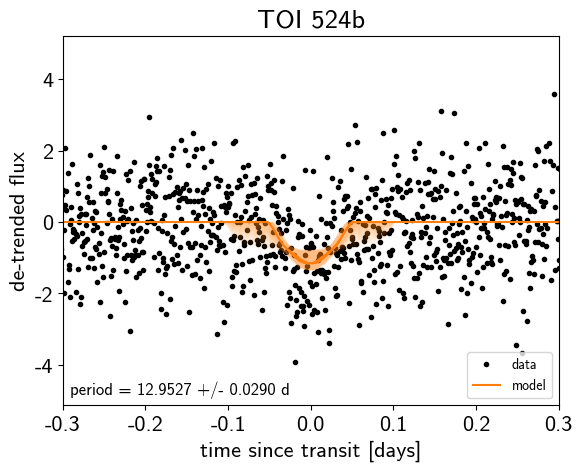

In [10]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we plot the physical radius of the planet using the stellar radius constraint from the TOI list, and the impact parameter (remember that we're using circular orbits).

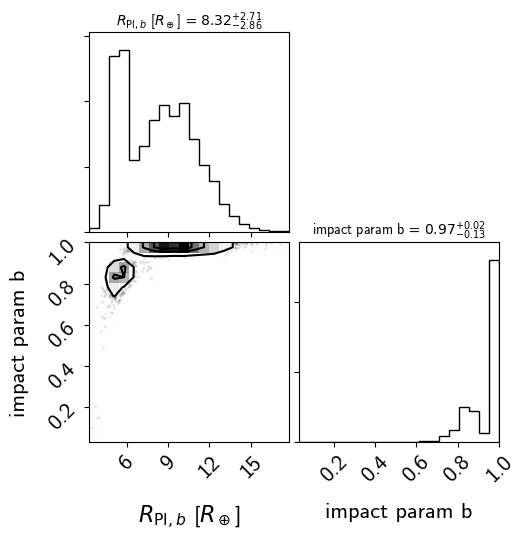

In [11]:
# Convert to Earth radii
r_pl = trace["r_pl"] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

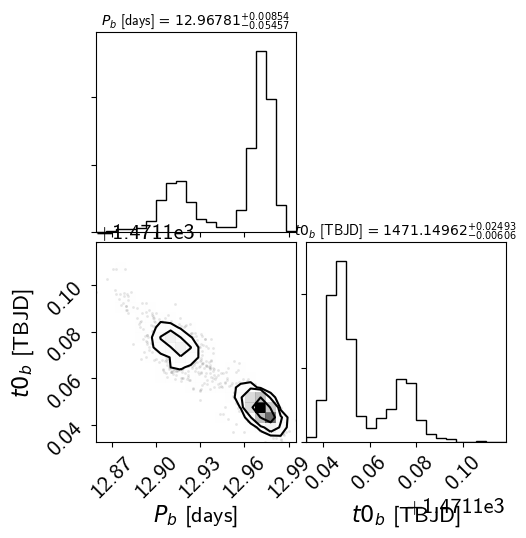

In [12]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

Finally, here are the posterior constraints on the stellar properties.
These won't be exactly the same as the prior because the duration of the transits (and the assumption of circular orbits )

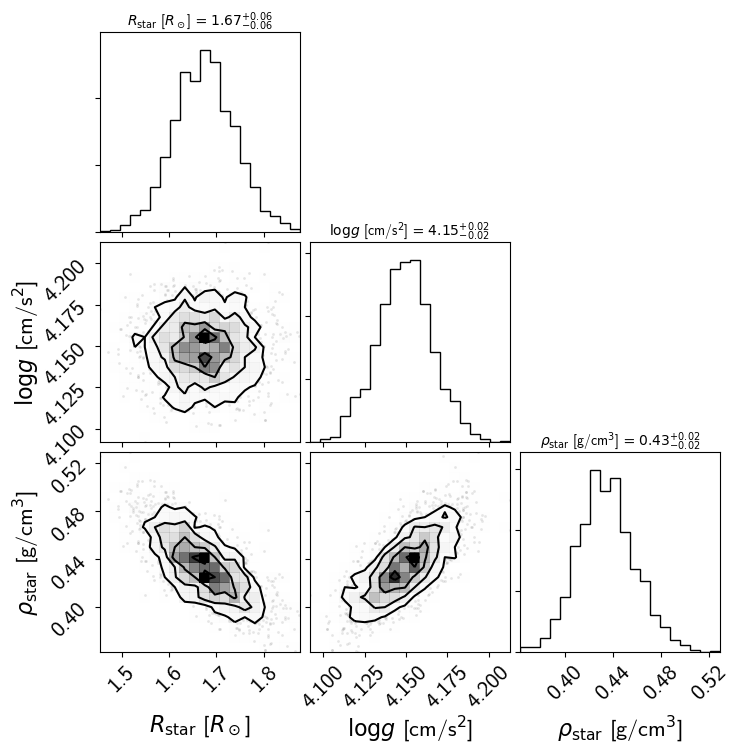

In [13]:
labels = ["$R_\mathrm{star}$ [$R_\odot$]", "$\log g$ [cm/s$^2$]",
          r"$\rho_\mathrm{star}$ [g/cm$^3$]"]
samples = np.vstack((trace["r_star"], trace["logg_star"], trace["rho_star"])).T
corner.corner(samples, labels=labels,
              show_titles=True,
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


and BibTeX entries:

In [15]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficient, uninformative sampling of limb darke

## Environment

This notebook was run with the following conda environment:

In [16]:
!conda env export

name: tessatlas
channels:
  - defaults
dependencies:
  - astropy=3.1.2=py37h7b6447c_0
  - atomicwrites=1.3.0=py37_1
  - attrs=19.1.0=py37_1
  - blas=1.0=mkl
  - ca-certificates=2019.1.23=0
  - certifi=2019.3.9=py37_0
  - cycler=0.10.0=py37_0
  - dbus=1.13.6=h746ee38_0
  - expat=2.2.6=he6710b0_0
  - fontconfig=2.13.0=h9420a91_0
  - freetype=2.9.1=h8a8886c_1
  - glib=2.56.2=hd408876_0
  - gst-plugins-base=1.14.0=hbbd80ab_1
  - gstreamer=1.14.0=hb453b48_1
  - icu=58.2=h9c2bf20_1
  - intel-openmp=2019.3=199
  - jpeg=9b=h024ee3a_2
  - kiwisolver=1.0.1=py37hf484d3e_0
  - libedit=3.1.20181209=hc058e9b_0
  - libffi=3.2.1=hd88cf55_4
  - libgcc-ng=8.2.0=hdf63c60_1
  - libgfortran-ng=7.3.0=hdf63c60_0
  - libpng=1.6.36=hbc83047_0
  - libstdcxx-ng=8.2.0=hdf63c60_1
  - libuuid=1.0.3=h1bed415_2
  - libxcb=1.13=h1bed415_1
  - libxml2=2.9.9=he19cac6_0
  - matplotlib=3.0.3=py37h5429711_0
  - mkl=2019.3=199
  - mkl_fft=1.0.10=py37ha843d7b_0
  - mkl_random=1.0.2=py37hd81dba3_0
  - more-itertools=6.0.0=py3